# Всероссийская олимпиада студентов «Я — профессионал»

## Машинное обучение. Полуфинал для студентов бакалавриата и магистратуры.
старт:24 фев 2021, 00:00:00\
финиш:2 мрт 2021, 23:59:59

### 1. Постановка задачи

В реальной жизни для изучения свойств целевого пласта на месторождении бурятся скважины, после чего в них опускаются специальные устройства - каротажные зонды. С их помощью проводится запись различных геофизических полей (например, радиоактивность или плотность), создаваемых горными породами. Подобные исследования называются геофизическими исследования скважин - ГИС. На основе полученных данных специалисты петрофизики проводят интерпретацию и сообщают информацию о том, на какой глубине находится пласт-коллектор, который может накапливать и отдавать флюиды. Типичный пример различных каротажных кривых и их совместной интерпретации представлен на рисунке ниже:

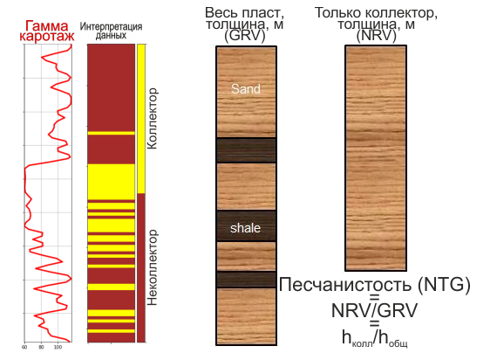

На основе полученной интерпретации можно посчитать такое свойство как песчанистость в зоне бурения скважины. **Песчанистость** — это отношение толщин пластов-коллекторов к общей толщине геологического образования, данная характеристика позволяет геологам делать предположения об экономической эффективности работы с этим месторождением. К сожалению, бурение скважин является очень дорогостоящей операцией, поэтому мы используем различные алгоритмы картопостроения с целью прогноза свойств в межскважинном пространстве. В качестве данных в представленной задаче используется информация из синтетической модели месторождения, которая была построена на основе геологического обнажения Шестаково, Кемеровская область. По его описанию были определены различные геологические параметры (размеры и геометрия тел, их связанность и значение песчанистости), которые в дальнейшем использовались при построении 3D модели. Подобный подход позволил достаточно точно отобразить реальную геологию (которая обычно не доступна для визуального анализа) и использовать полученный результат в качестве полигона для опробования и оценки различных подходов.

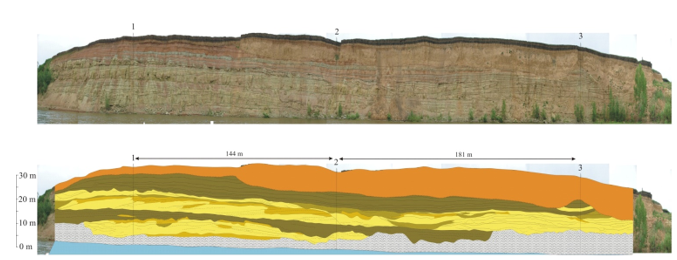

В предоставленном наборе данных имеется информация о 10% скважинных данных (в реальной жизни их может быть менее 1% от площади месторождения!), используя которые, Вам предлагается построить алгоритм, который бы предсказывал значения песчанистости в точках с отсутствующими значениями.

**Вход:** тренировочный датасет (Training wells.csv) с заполненными значениями песчанистости, а также тестовый датасет (Empty part.csv) с пропущенными значениями песчанистости, для которого вы должны предсказать эти значения. https://disk.yandex.ru/d/M6J9r7yvR8m3GQ?w=1.\
**Выход:** файл с предсказанием песчанитости для тестового файла. В выходном файле последовательность строк сохранить, само предсказание песчанистости добавить четвёртым столбцом в датасет с заголовком столбца NTG, как это сделано в тренировочном датасете. Получившийся файл загрузить в систему.\
**Критерии оценивания:** в качестве метрики оценивания используется метрика RMSE, участники ранжируются относительно значения этой метрики (от меньшего к большему).

# 2. Исследовательский анализ данных

In [11]:
import pandas as pd
import numpy as np

data_train = pd.read_csv(r'.\data\Training_wells.csv')
print('\033[1mРазмер набора данных:\033[0m',data_train.shape)
print('\033[1mПропуски:\n\033[0m',data_train.isnull().sum())

#Видно, что X и Y - это разделенный по '-' столбец Well. Проверю, что данные совпадают
data_train['X_splitted'] = data_train['Well'].str.split('-',expand=True)[0].astype('int')
print('\033[1mX и X извлеченные совпадают:\033[0m',(data_train['X']==data_train['X_splitted']).value_counts()[1]==data_train.shape[0])
data_train['Y_splitted'] = data_train['Well'].str.split('-',expand=True)[1].astype('int')
print('\033[1mY и Y извлеченные совпадают:\033[0m',(data_train['Y']==data_train['Y_splitted']).value_counts()[1]==data_train.shape[0])

#Тк данные совпадают, можно избавиться от лишних, созданных столбцов
data_train.drop(['X_splitted','Y_splitted','Well'],axis=1,inplace=True)

print('\033[1mТипы данных:\n\033[0m',data_train.dtypes)
print('\033[1mУникальных X:\033[0m', len(data_train['X'].unique()))
print('\033[1mУникальных Y:\033[0m', len(data_train['Y'].unique()))
data_train.head()

Размер набора данных: (138, 4)
Пропуски:
 Well    0
X       0
Y       0
NTG     0
dtype: int64
X и X извлеченные совпадают: True
Y и Y извлеченные совпадают: True
Типы данных:
 X        int64
Y        int64
NTG    float64
dtype: object
Уникальных X: 43
Уникальных Y: 30


,X,Y,NTG
0,201,907,0.2006
1,201,914,0.3624
2,201,924,0.4381
3,202,922,0.4289
4,202,925,0.4021


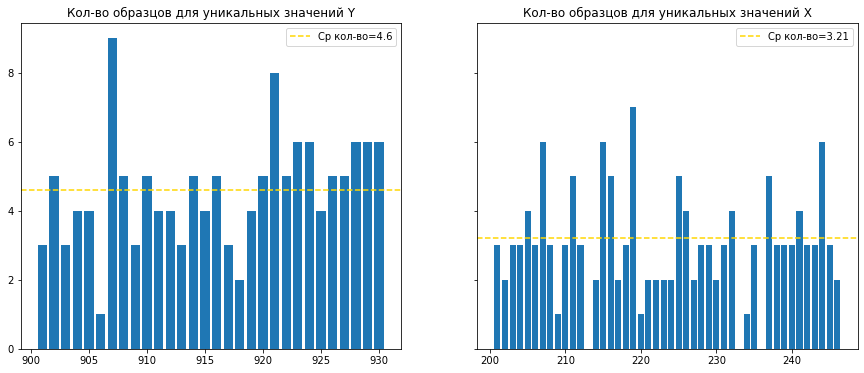

Уникальных X: 43
Уникальных Y: 30


In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(15,6)
[ax1, ax2] = axs
ax1.bar(data_train['Y'].value_counts().index,data_train['Y'].value_counts())
ax1.axhline(data_train['Y'].value_counts().mean(), color='gold', linestyle='--',label="Ср кол-во="+str(data_train['Y'].value_counts().mean()))
ax1.set_title('Кол-во образцов для уникальных значений Y')
ax1.legend()

ax2.bar(data_train['X'].value_counts().index,data_train['X'].value_counts())
ax2.axhline(data_train['X'].value_counts().mean(), color='gold', linestyle='--',label="Ср кол-во="+str(round(data_train['X'].value_counts().mean(),2)))
ax2.set_title('Кол-во образцов для уникальных значений X')

ax2.legend()
plt.show()
print('\033[1mУникальных X:\033[0m', len(data_train['X'].unique()))
print('\033[1mУникальных Y:\033[0m', len(data_train['Y'].unique()))

<function matplotlib.pyplot.show(*args, **kw)>

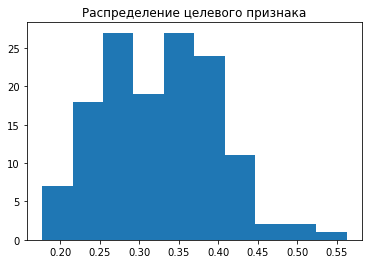

In [5]:
plt.hist(data_train['NTG'])
plt.title('Распределение целевого признака')
plt.show

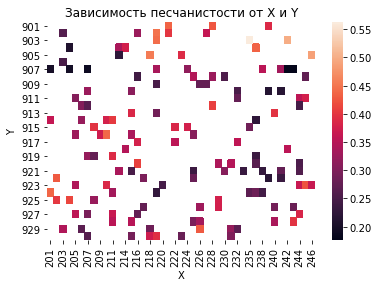

In [8]:
import seaborn as sns

sns.heatmap(pd.pivot_table(data_train, values='NTG', index=['Y'],
                    columns=['X'], aggfunc=np.sum))
plt.title('Зависимость песчанистости от X и Y')
plt.show()

### 3. Генерация новых признаков

Тк обрабатываем гео-данные, для генерации новых признаков найдем ближайшие скважины и используем значение песчанитости, расстояние до них и различные статистики для генерации новых признаков.

Попробую поиск соседей через NearestNeighbors и BallTree.
Идеальный алгоритм находил бы не просто ближайшие точки, а точки, которые образуют замкнутый многоугольник минимальной площади.

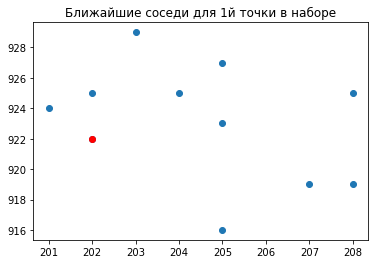

,X,Y,NTG,Neighbours_NTG_mean,Neighbours_NTG_median,Neighbours_NTG_std,Neighbours_NTG_scope,Neighbours_NTG_skew,Neighbours_NTG_kurt,Neighbours_dist_mean,...,0_Neighbours_NTG,1_Neighbours_NTG,2_Neighbours_NTG,3_Neighbours_NTG,4_Neighbours_NTG,5_Neighbours_NTG,6_Neighbours_NTG,7_Neighbours_NTG,8_Neighbours_NTG,9_Neighbours_NTG
0,201,907,0.2006,0.26755,0.26435,0.054651,0.1727,0.081893,-1.109747,5.511025,...,2.236068,3.000000,4.242641,5.385165,5.656854,6.000000,6.708204,7.000000,7.071068,7.810250
1,201,914,0.3624,0.29675,0.31330,0.057652,0.1997,-0.420811,-0.398085,6.289005,...,4.472136,5.000000,5.000000,5.385165,6.324555,7.000000,7.071068,7.211103,7.615773,7.810250
2,201,924,0.4381,0.34991,0.34415,0.049195,0.1607,0.127338,-1.005637,4.998142,...,1.414214,2.236068,3.162278,4.123106,5.000000,5.385165,6.708204,7.071068,7.071068,7.810250
3,202,922,0.4289,0.35481,0.34415,0.046612,0.1606,0.327545,-0.803634,5.086148,...,2.236068,3.000000,3.162278,3.605551,5.830952,5.830952,6.708204,6.708204,6.708204,7.071068
4,202,925,0.4021,0.34783,0.34415,0.059816,0.1744,0.141772,-1.234846,4.186151,...,1.414214,2.000000,3.000000,3.605551,3.605551,4.123106,5.385165,5.656854,6.000000,7.071068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,245,908,0.2719,0.30906,0.28980,0.115216,0.3230,0.452383,-1.188225,3.959676,...,2.236068,3.000000,3.162278,3.162278,3.162278,4.123106,4.123106,4.472136,5.830952,6.324555
134,245,911,0.3780,0.28818,0.25910,0.098154,0.3130,0.675905,-0.647799,4.221700,...,1.000000,1.414214,3.000000,4.123106,4.472136,5.000000,5.385165,5.656854,6.082763,6.082763
135,245,923,0.4239,0.31142,0.28625,0.057423,0.1610,0.286824,-1.585277,3.493836,...,1.000000,1.000000,2.236068,3.162278,3.605551,4.123106,4.123106,4.472136,5.385165,5.830952
136,246,905,0.4900,0.30470,0.30260,0.099180,0.3230,0.368393,-0.798014,5.591802,...,3.162278,3.605551,4.472136,4.472136,5.385165,6.082763,6.324555,7.071068,7.280110,8.062258


In [9]:
from sklearn.neighbors import BallTree
from scipy import stats

def calculate_stats(data, column):
    """Рассчет статистик для выбранного столбца
       Результат: датафрейм"""
    
    data[column+'_mean'] = data[column].apply(lambda x: np.mean(x))
    data[column+'_median'] = data[column].apply(lambda x: np.median(x))
    data[column+'_std'] = data[column].apply(lambda x: np.std(x))
    data[column+'_scope'] = data[column].apply(lambda x: np.max(x)-np.min(x))
    data[column+'_skew'] = data[column].apply(lambda x: stats.skew(x))
    data[column+'_kurt'] = data[column].apply(lambda x: stats.kurtosis(x))
    return data

def extraxt_info(data,column,neighbours):
    for i in range(neighbours-1):
        data[str(i)+'_'+column] = data['Neighbours_dist'].apply(lambda x: x[i])
    return data


def generate_new_features(data,neighbours):
    df = data.copy()
    bt = BallTree(pd.DataFrame(data_train.drop('NTG',axis=1)), metric='euclidean')
    dist, ind = bt.query(df[['X','Y']], k=neighbours)
    #Индексы ближайших соседей, без 1го столбца, тк в нем исходная точка\
    ind_final = ind[:,1:]
    dist_final = dist[:,1:]
    df['Neighbours_idx'] = [d for d in ind_final]
    df['Neighbours_dist'] = [d for d in dist_final]
    df['Neighbours_NTG'] = [list(data_train.loc[d,'NTG']) for d in df['Neighbours_idx']]
    plt.scatter(df.iloc[ind[3],0],df.iloc[ind[3],1])
    plt.scatter(df.iloc[3,0],df.iloc[3,1],color='r')
    plt.title('Ближайшие соседи для 1й точки в наборе')
    plt.show()
    #Рассчит статистик
    df =  calculate_stats(df,'Neighbours_NTG')
    df =  calculate_stats(df,'Neighbours_dist')
    #Извлечение инфо о ближайших скважин
    extraxt_info(df,'Neighbours_dist',neighbours)
    extraxt_info(df,'Neighbours_NTG',neighbours)
    #Удаление лишних столбцов
    df.drop([ 'Neighbours_idx', 'Neighbours_dist', 'Neighbours_NTG'],axis=1,inplace=True)
    return df

data_train_with_10neighbours_stats = generate_new_features(data_train,11)
data_train_with_10neighbours_stats

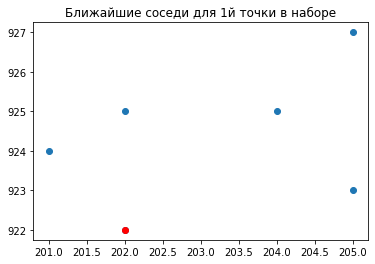

,X,Y,NTG,Neighbours_NTG_mean,Neighbours_NTG_median,Neighbours_NTG_std,Neighbours_NTG_scope,Neighbours_NTG_skew,Neighbours_NTG_kurt,Neighbours_dist_mean,...,0_Neighbours_dist,1_Neighbours_dist,2_Neighbours_dist,3_Neighbours_dist,4_Neighbours_dist,0_Neighbours_NTG,1_Neighbours_NTG,2_Neighbours_NTG,3_Neighbours_NTG,4_Neighbours_NTG
0,201,907,0.2006,0.24544,0.2517,0.039093,0.1087,0.235065,-1.228903,4.104146,...,2.236068,3.000000,4.242641,5.385165,5.656854,2.236068,3.000000,4.242641,5.385165,5.656854
1,201,914,0.3624,0.30540,0.3061,0.021547,0.0609,-0.930823,-0.461791,5.236371,...,4.472136,5.000000,5.000000,5.385165,6.324555,4.472136,5.000000,5.000000,5.385165,6.324555
2,201,924,0.4381,0.38890,0.4021,0.033204,0.0858,-0.261043,-1.613783,3.187133,...,1.414214,2.236068,3.162278,4.123106,5.000000,1.414214,2.236068,3.162278,4.123106,5.000000
3,202,922,0.4289,0.39074,0.4021,0.035542,0.0950,-0.122856,-1.521229,3.566970,...,2.236068,3.000000,3.162278,3.605551,5.830952,2.236068,3.000000,3.162278,3.605551,5.830952
4,202,925,0.4021,0.39610,0.4136,0.038729,0.0950,-0.326530,-1.698623,2.725063,...,1.414214,2.000000,3.000000,3.605551,3.605551,1.414214,2.000000,3.000000,3.605551,3.605551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,245,908,0.2719,0.31604,0.3566,0.121629,0.3130,0.031660,-1.479523,2.944580,...,2.236068,3.000000,3.162278,3.162278,3.162278,2.236068,3.000000,3.162278,3.162278,3.162278
134,245,911,0.3780,0.25410,0.2463,0.059922,0.1780,0.558691,-0.752949,2.801891,...,1.000000,1.414214,3.000000,4.123106,4.472136,1.000000,1.414214,3.000000,4.123106,4.472136
135,245,923,0.4239,0.30560,0.2816,0.050870,0.1127,0.312358,-1.794268,2.200779,...,1.000000,1.000000,2.236068,3.162278,3.605551,1.000000,1.000000,2.236068,3.162278,3.605551
136,246,905,0.4900,0.29216,0.2719,0.119548,0.3230,0.707952,-0.834784,4.219453,...,3.162278,3.605551,4.472136,4.472136,5.385165,3.162278,3.605551,4.472136,4.472136,5.385165


In [10]:
data_train_with_5neighbours_stats = generate_new_features(data_train,6)
data_train_with_5neighbours_stats

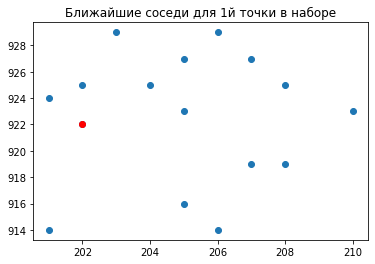

,X,Y,NTG,Neighbours_NTG_mean,Neighbours_NTG_median,Neighbours_NTG_std,Neighbours_NTG_scope,Neighbours_NTG_skew,Neighbours_NTG_kurt,Neighbours_dist_mean,...,5_Neighbours_NTG,6_Neighbours_NTG,7_Neighbours_NTG,8_Neighbours_NTG,9_Neighbours_NTG,10_Neighbours_NTG,11_Neighbours_NTG,12_Neighbours_NTG,13_Neighbours_NTG,14_Neighbours_NTG
0,201,907,0.2006,0.288493,0.3054,0.063825,0.2074,0.014587,-1.123059,7.118245,...,6.000000,6.708204,7.000000,7.071068,7.810250,8.602325,9.848858,10.630146,11.180340,11.401754
1,201,914,0.3624,0.311907,0.3205,0.064499,0.2315,-0.115804,-0.611585,7.003137,...,7.000000,7.071068,7.211103,7.615773,7.810250,8.062258,8.246211,8.246211,8.602325,9.000000
2,201,924,0.4381,0.341093,0.3431,0.050179,0.1652,0.095359,-0.998026,6.337912,...,5.385165,6.708204,7.071068,7.071068,7.810250,8.485281,8.602325,8.944272,9.055385,10.000000
3,202,922,0.4289,0.345647,0.3431,0.047261,0.1699,0.262069,-0.701492,6.070906,...,5.830952,6.708204,6.708204,6.708204,7.071068,7.071068,8.062258,8.062258,8.062258,8.944272
4,202,925,0.4021,0.344173,0.3431,0.053755,0.1744,0.203446,-0.948541,5.645212,...,4.123106,5.385165,5.656854,6.000000,7.071068,7.810250,8.246211,8.485281,9.055385,9.219544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,245,908,0.2719,0.325967,0.3534,0.105721,0.3230,0.058245,-1.267983,5.460180,...,4.123106,4.123106,4.472136,5.830952,6.324555,7.071068,7.071068,8.944272,9.219544,10.000000
134,245,911,0.3780,0.304593,0.2719,0.100367,0.3230,0.571434,-0.741365,5.602562,...,5.000000,5.385165,5.656854,6.082763,6.082763,7.615773,8.062258,8.544004,8.544004,9.055385
135,245,923,0.4239,0.300253,0.2816,0.059511,0.1792,0.269379,-1.459844,4.551621,...,4.123106,4.123106,4.472136,5.385165,5.830952,5.830952,6.082763,7.071068,7.071068,7.280110
136,246,905,0.4900,0.333967,0.3534,0.112054,0.3855,0.294443,-0.766192,6.866819,...,6.082763,6.324555,7.071068,7.280110,8.062258,8.246211,8.602325,9.055385,10.000000,11.180340


In [11]:
data_train_with_15neighbours_stats = generate_new_features(data_train,16)
data_train_with_15neighbours_stats

data_train перемешанный

In [12]:
data_train_shuffeled = data_train.sample(frac=1,random_state=0)
X_shuffeled = data_train_shuffeled.drop('NTG',axis=1)
y_shuffeled = data_train_shuffeled['NTG']
X_shuffeled.head()

,X,Y
8,204,904
68,222,917
27,209,916
118,241,910
24,208,915


data_train train_test_split

In [13]:
from sklearn.model_selection import train_test_split

X = data_train.drop('NTG',axis=1)
y = data_train['NTG']
x_train,x_valid,y_train,y_valid = train_test_split(X, y, test_size=0.25, random_state=240,shuffle=True)

data_train with 5 neighbours

In [14]:

X_with_5neighbours_stats = data_train_with_5neighbours_stats.drop('NTG',axis=1)
y_with_5neighbours_stats = data_train_with_5neighbours_stats['NTG']
x_train_5nn,x_valid_5nn,y_train_5nn,y_valid_5nn = train_test_split(X_with_5neighbours_stats, y_with_5neighbours_stats, test_size=0.25, random_state=240,shuffle=True)

data_5nn_shuffeled = data_train_with_5neighbours_stats.sample(frac=1,random_state=0)
X_5nn_shuffeled = data_5nn_shuffeled.drop('NTG',axis=1)
y_5nn_shuffeled = data_5nn_shuffeled['NTG']

data_train with 10 neighbours

In [15]:

X_with_10neighbours_stats = data_train_with_10neighbours_stats.drop('NTG',axis=1)
y_with_10neighbours_stats = data_train_with_10neighbours_stats['NTG']
x_train_10nn,x_valid_10nn,y_train_10nn,y_valid_10nn = train_test_split(X_with_10neighbours_stats, y_with_10neighbours_stats, test_size=0.25, random_state=240,shuffle=True)

data_10nn_shuffeled = data_train_with_10neighbours_stats.sample(frac=1,random_state=0)
X_10nn_shuffeled = data_10nn_shuffeled.drop('NTG',axis=1)
y_10nn_shuffeled = data_10nn_shuffeled['NTG']

data_train with 15 neighbours

In [16]:

X_with_15neighbours_stats = data_train_with_15neighbours_stats.drop('NTG',axis=1)
y_with_15neighbours_stats = data_train_with_15neighbours_stats['NTG']
x_train_15nn,x_valid_15nn,y_train_15nn,y_valid_15nn = train_test_split(X_with_15neighbours_stats, y_with_15neighbours_stats, test_size=0.25, random_state=240,shuffle=True)

data_15nn_shuffeled = data_train_with_15neighbours_stats.sample(frac=1,random_state=0)
X_15nn_shuffeled = data_15nn_shuffeled.drop('NTG',axis=1)
y_15nn_shuffeled = data_15nn_shuffeled['NTG']

**data_train with poly and neighbours**

In [17]:
def nn_poly_concat(deg,nn_set,data_set):
    from sklearn.preprocessing import PolynomialFeatures
    
    
    poly =  PolynomialFeatures(degree=deg,include_bias=False)
    
    poly_df = pd.DataFrame(poly.fit_transform(data_set))
    poly_df.columns= poly.get_feature_names(data_set.columns)
    poly_df.drop(['X','Y'],axis=1,inplace=True)  
    poly_nn_test = pd.concat([poly_df,nn_set],axis=1)
    return poly_nn_test

In [18]:
poly4_5nn_set = nn_poly_concat(4,data_train_with_5neighbours_stats,data_train.drop('NTG',axis=1))

X_poly4_5nn = poly4_5nn_set.drop('NTG',axis=1)
y_poly4_5nn = poly4_5nn_set['NTG']
x_train_p4_5nn,x_valid_p4_5nn,y_train_p4_5nn,y_valid_p4_5nn = train_test_split(X_poly4_5nn, y_poly4_5nn, test_size=0.25, random_state=240,shuffle=True)

data_5nn_poly_shuffeled = poly4_5nn_set.sample(frac=1,random_state=0)
X_5nn_poly_shuffeled = data_5nn_poly_shuffeled.drop('NTG',axis=1)
y_5nn_poly_shuffeled = data_5nn_poly_shuffeled['NTG']

In [19]:
X_poly4_5nn

,X^2,X Y,Y^2,X^3,X^2 Y,X Y^2,Y^3,X^4,X^3 Y,X^2 Y^2,...,0_Neighbours_dist,1_Neighbours_dist,2_Neighbours_dist,3_Neighbours_dist,4_Neighbours_dist,0_Neighbours_NTG,1_Neighbours_NTG,2_Neighbours_NTG,3_Neighbours_NTG,4_Neighbours_NTG
0,40401.0,182307.0,822649.0,8120601.0,36643707.0,165352449.0,746142643.0,1.632241e+09,7.365385e+09,3.323584e+10,...,2.236068,3.000000,4.242641,5.385165,5.656854,2.236068,3.000000,4.242641,5.385165,5.656854
1,40401.0,183714.0,835396.0,8120601.0,36926514.0,167914596.0,763551944.0,1.632241e+09,7.422229e+09,3.375083e+10,...,4.472136,5.000000,5.000000,5.385165,6.324555,4.472136,5.000000,5.000000,5.385165,6.324555
2,40401.0,185724.0,853776.0,8120601.0,37330524.0,171608976.0,788889024.0,1.632241e+09,7.503435e+09,3.449340e+10,...,1.414214,2.236068,3.162278,4.123106,5.000000,1.414214,2.236068,3.162278,4.123106,5.000000
3,40804.0,186244.0,850084.0,8242408.0,37621288.0,171716968.0,783777448.0,1.664966e+09,7.599500e+09,3.468683e+10,...,2.236068,3.000000,3.162278,3.605551,5.830952,2.236068,3.000000,3.162278,3.605551,5.830952
4,40804.0,186850.0,855625.0,8242408.0,37743700.0,172836250.0,791453125.0,1.664966e+09,7.624227e+09,3.491292e+10,...,1.414214,2.000000,3.000000,3.605551,3.605551,1.414214,2.000000,3.000000,3.605551,3.605551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,60025.0,222460.0,824464.0,14706125.0,54502700.0,201993680.0,748613312.0,3.603001e+09,1.335316e+10,4.948845e+10,...,2.236068,3.000000,3.162278,3.162278,3.162278,2.236068,3.000000,3.162278,3.162278,3.162278
134,60025.0,223195.0,829921.0,14706125.0,54682775.0,203330645.0,756058031.0,3.603001e+09,1.339728e+10,4.981601e+10,...,1.000000,1.414214,3.000000,4.123106,4.472136,1.000000,1.414214,3.000000,4.123106,4.472136
135,60025.0,226135.0,851929.0,14706125.0,55403075.0,208722605.0,786330467.0,3.603001e+09,1.357375e+10,5.113704e+10,...,1.000000,1.000000,2.236068,3.162278,3.605551,1.000000,1.000000,2.236068,3.162278,3.605551
136,60516.0,222630.0,819025.0,14886936.0,54766980.0,201480150.0,741217625.0,3.662186e+09,1.347268e+10,4.956412e+10,...,3.162278,3.605551,4.472136,4.472136,5.385165,3.162278,3.605551,4.472136,4.472136,5.385165


data_train with poly7 and 15 neighbours

In [20]:
poly7_15nn_set = nn_poly_concat(7,data_train_with_15neighbours_stats,data_train.drop('NTG',axis=1))

X_poly7_15nn = poly7_15nn_set.drop('NTG',axis=1)
y_poly7_15nn = poly7_15nn_set['NTG']
x_train_p7_15nn,x_valid_p7_15nn,y_train_p7_15nn,y_valid_p7_15nn = train_test_split(X_poly7_15nn, y_poly7_15nn, test_size=0.25, random_state=240,shuffle=True)

data_15nn_poly_shuffeled = poly7_15nn_set.sample(frac=1,random_state=0)
X_15nn_poly_shuffeled = data_15nn_poly_shuffeled.drop('NTG',axis=1)
y_15nn_poly_shuffeled = data_15nn_poly_shuffeled['NTG']

In [21]:
poly4_5nn_set = nn_poly_concat(4,data_train_with_5neighbours_stats,data_train.drop('NTG',axis=1))

X_poly4_5nn = poly4_5nn_set.drop('NTG',axis=1)
y_poly4_5nn = poly4_5nn_set['NTG']
x_train_p4_5nn,x_valid_p4_5nn,y_train_p4_5nn,y_valid_p4_5nn = train_test_split(X_poly4_5nn, y_poly4_5nn, test_size=0.25, random_state=240,shuffle=True)

data_5nn_poly_shuffeled = poly4_5nn_set.sample(frac=1,random_state=0)
X_5nn_poly_shuffeled = data_5nn_poly_shuffeled.drop('NTG',axis=1)
y_5nn_poly_shuffeled = data_5nn_poly_shuffeled['NTG']

In [22]:
x_train_p4_5nn

,X^2,X Y,Y^2,X^3,X^2 Y,X Y^2,Y^3,X^4,X^3 Y,X^2 Y^2,...,0_Neighbours_dist,1_Neighbours_dist,2_Neighbours_dist,3_Neighbours_dist,4_Neighbours_dist,0_Neighbours_NTG,1_Neighbours_NTG,2_Neighbours_NTG,3_Neighbours_NTG,4_Neighbours_NTG
60,47961.0,199071.0,826281.0,10503459.0,43596549.0,180955539.0,751089429.0,2.300258e+09,9.547644e+09,3.962926e+10,...,2.000000,3.162278,4.000000,4.123106,4.123106,2.000000,3.162278,4.000000,4.123106,4.123106
113,57121.0,220358.0,850084.0,13651919.0,52665562.0,203170076.0,783777448.0,3.262809e+09,1.258707e+10,4.855765e+10,...,1.414214,2.000000,2.236068,2.236068,2.828427,1.414214,2.000000,2.236068,2.236068,2.828427
45,46225.0,199520.0,861184.0,9938375.0,42896800.0,185154560.0,799178752.0,2.136751e+09,9.222812e+09,3.980823e+10,...,1.414214,2.000000,2.828427,3.162278,3.605551,1.414214,2.000000,2.828427,3.162278,3.605551
85,51984.0,207024.0,824464.0,11852352.0,47201472.0,187977792.0,748613312.0,2.702336e+09,1.076194e+10,4.285894e+10,...,1.414214,2.000000,2.236068,3.000000,4.000000,1.414214,2.000000,2.236068,3.000000,4.000000
129,59536.0,224480.0,846400.0,14526784.0,54773120.0,206521600.0,778688000.0,3.544535e+09,1.336464e+10,5.039127e+10,...,1.000000,2.828427,3.000000,3.162278,3.162278,1.000000,2.828427,3.000000,3.162278,3.162278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,42436.0,188284.0,835396.0,8741816.0,38786504.0,172091576.0,763551944.0,1.800814e+09,7.990020e+09,3.545086e+10,...,2.000000,2.236068,2.236068,2.236068,3.162278,2.000000,2.236068,2.236068,2.236068,3.162278
89,52441.0,212054.0,857476.0,12008989.0,48560366.0,196362004.0,794022776.0,2.750058e+09,1.112032e+10,4.496690e+10,...,1.000000,3.000000,3.605551,3.605551,4.242641,1.000000,3.000000,3.605551,3.605551,4.242641
121,58564.0,218526.0,815409.0,14172488.0,52883292.0,197328978.0,736314327.0,3.429742e+09,1.279776e+10,4.775361e+10,...,3.605551,4.000000,4.123106,4.123106,4.472136,3.605551,4.000000,4.123106,4.123106,4.472136
86,51984.0,207936.0,831744.0,11852352.0,47409408.0,189637632.0,758550528.0,2.702336e+09,1.080935e+10,4.323738e+10,...,3.162278,3.605551,4.000000,4.123106,4.472136,3.162278,3.605551,4.000000,4.123106,4.472136


In [23]:
poly8_15nn_set = nn_poly_concat(8,data_train_with_15neighbours_stats,data_train.drop('NTG',axis=1))

X_poly8_15nn = poly8_15nn_set.drop('NTG',axis=1)
y_poly8_15nn = poly8_15nn_set['NTG']
x_train_p8_15nn,x_valid_p8_15nn,y_train_p8_15nn,y_valid_p8_15nnn = train_test_split(X_poly8_15nn, y_poly8_15nn, test_size=0.25, random_state=240,shuffle=True)

data_15nn_p8_shuffeled = poly8_15nn_set.sample(frac=1,random_state=0)
X_15nn_p8_shuffeled = data_15nn_p8_shuffeled.drop('NTG',axis=1)
y_15nn_p8_shuffeled = data_15nn_p8_shuffeled['NTG']

In [24]:
poly8_15nn_set

,X^2,X Y,Y^2,X^3,X^2 Y,X Y^2,Y^3,X^4,X^3 Y,X^2 Y^2,...,5_Neighbours_NTG,6_Neighbours_NTG,7_Neighbours_NTG,8_Neighbours_NTG,9_Neighbours_NTG,10_Neighbours_NTG,11_Neighbours_NTG,12_Neighbours_NTG,13_Neighbours_NTG,14_Neighbours_NTG
0,40401.0,182307.0,822649.0,8120601.0,36643707.0,165352449.0,746142643.0,1.632241e+09,7.365385e+09,3.323584e+10,...,6.000000,6.708204,7.000000,7.071068,7.810250,8.602325,9.848858,10.630146,11.180340,11.401754
1,40401.0,183714.0,835396.0,8120601.0,36926514.0,167914596.0,763551944.0,1.632241e+09,7.422229e+09,3.375083e+10,...,7.000000,7.071068,7.211103,7.615773,7.810250,8.062258,8.246211,8.246211,8.602325,9.000000
2,40401.0,185724.0,853776.0,8120601.0,37330524.0,171608976.0,788889024.0,1.632241e+09,7.503435e+09,3.449340e+10,...,5.385165,6.708204,7.071068,7.071068,7.810250,8.485281,8.602325,8.944272,9.055385,10.000000
3,40804.0,186244.0,850084.0,8242408.0,37621288.0,171716968.0,783777448.0,1.664966e+09,7.599500e+09,3.468683e+10,...,5.830952,6.708204,6.708204,6.708204,7.071068,7.071068,8.062258,8.062258,8.062258,8.944272
4,40804.0,186850.0,855625.0,8242408.0,37743700.0,172836250.0,791453125.0,1.664966e+09,7.624227e+09,3.491292e+10,...,4.123106,5.385165,5.656854,6.000000,7.071068,7.810250,8.246211,8.485281,9.055385,9.219544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,60025.0,222460.0,824464.0,14706125.0,54502700.0,201993680.0,748613312.0,3.603001e+09,1.335316e+10,4.948845e+10,...,4.123106,4.123106,4.472136,5.830952,6.324555,7.071068,7.071068,8.944272,9.219544,10.000000
134,60025.0,223195.0,829921.0,14706125.0,54682775.0,203330645.0,756058031.0,3.603001e+09,1.339728e+10,4.981601e+10,...,5.000000,5.385165,5.656854,6.082763,6.082763,7.615773,8.062258,8.544004,8.544004,9.055385
135,60025.0,226135.0,851929.0,14706125.0,55403075.0,208722605.0,786330467.0,3.603001e+09,1.357375e+10,5.113704e+10,...,4.123106,4.123106,4.472136,5.385165,5.830952,5.830952,6.082763,7.071068,7.071068,7.280110
136,60516.0,222630.0,819025.0,14886936.0,54766980.0,201480150.0,741217625.0,3.662186e+09,1.347268e+10,4.956412e+10,...,6.082763,6.324555,7.071068,7.280110,8.062258,8.246211,8.602325,9.055385,10.000000,11.180340


### Тестовая выборка

In [6]:
import pandas as pd
import numpy as np

data_test0 = pd.read_csv(r'.\data\Empty_part.csv')
data_test = data_test0.copy()
print('\033[1mРазмер тесиового набора данных:\033[0m',data_test0.shape)
print('\033[1mПропуски:\n\033[0m',data_test0.isnull().sum())

#Видно, что X и Y - это разделенный по '-' столбец Well. Проверю, что данные совпадают
data_test['X_splitted'] = data_test['Well'].str.split('-',expand=True)[0].astype('int')
print('\033[1mX и X извлеченные совпадают:\033[0m',(data_test['X']==data_test['X_splitted']).value_counts()[1]==data_test.shape[0])
data_test['Y_splitted'] = data_test['Well'].str.split('-',expand=True)[1].astype('int')
print('\033[1mY и Y извлеченные совпадают:\033[0m',(data_test['Y']==data_test['Y_splitted']).value_counts()[1]==data_test.shape[0])

#Тк данные совпадают, можно избавиться от лишних, созданных столбцов
data_test.drop(['X_splitted','Y_splitted','Well'],axis=1,inplace=True)

print('\033[1mТипы данных:\n\033[0m',data_test.dtypes)
print('\033[1mУникальных X:\033[0m', len(data_test['X'].unique()))
print('\033[1mУникальных Y:\033[0m', len(data_test['Y'].unique()))
data_test.head()

Размер тесиового набора данных: (1242, 3)
Пропуски:
 Well    0
X       0
Y       0
dtype: int64
X и X извлеченные совпадают: True
Y и Y извлеченные совпадают: True
Типы данных:
 X    int64
Y    int64
dtype: object
Уникальных X: 46
Уникальных Y: 30


,X,Y
0,201,901
1,201,902
2,201,903
3,201,904
4,201,905


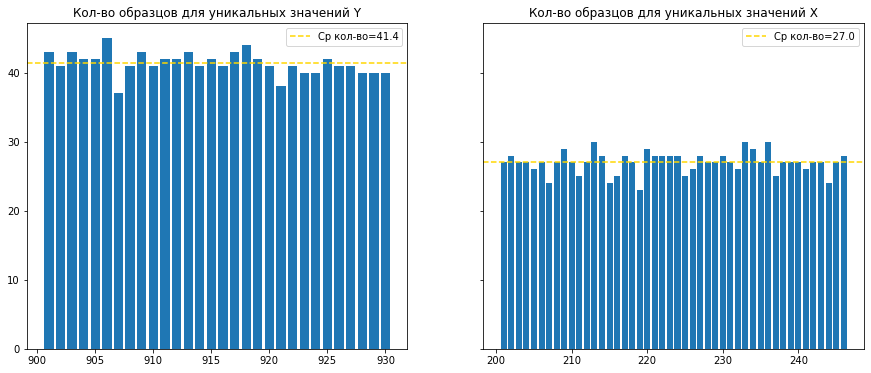

Уникальных X: 46
Уникальных Y: 30


In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(15,6)
[ax1, ax2] = axs
ax1.bar(data_test['Y'].value_counts().index,data_test['Y'].value_counts())
ax1.axhline(data_test['Y'].value_counts().mean(), color='gold', linestyle='--',label="Ср кол-во="+str(data_test['Y'].value_counts().mean()))
ax1.set_title('Кол-во образцов для уникальных значений Y')
ax1.legend()

ax2.bar(data_test['X'].value_counts().index,data_test['X'].value_counts())
ax2.axhline(data_test['X'].value_counts().mean(), color='gold', linestyle='--',label="Ср кол-во="+str(round(data_test['X'].value_counts().mean(),2)))
ax2.set_title('Кол-во образцов для уникальных значений X')

ax2.legend()
plt.show()
print('\033[1mУникальных X:\033[0m', len(data_test['X'].unique()))
print('\033[1mУникальных Y:\033[0m', len(data_test['Y'].unique()))

In [28]:
# data_test_15neighbours_stats = data_test

In [29]:
from sklearn.preprocessing import PolynomialFeatures


poly7 =  PolynomialFeatures(degree=7,include_bias=False)

poly7_df_test = pd.DataFrame(poly7.fit_transform(data_test))
poly7_df_test.columns= poly7.get_feature_names(data_test.columns)
poly7_df_test.drop(['X','Y'],axis=1,inplace=True)




poly7_15nn_test = pd.concat([poly7_df_test,data_test_15neighbours_stats],axis=1)
poly7_15nn_test

,X^2,X Y,Y^2,X^3,X^2 Y,X Y^2,Y^3,X^4,X^3 Y,X^2 Y^2,...,X^7,X^6 Y,X^5 Y^2,X^4 Y^3,X^3 Y^4,X^2 Y^5,X Y^6,Y^7,X,Y
0,40401.0,181101.0,811801.0,8120601.0,36401301.0,163172001.0,731432701.0,1.632241e+09,7.316662e+09,3.279757e+10,...,1.325478e+16,5.941569e+16,2.663360e+17,1.193874e+18,5.351645e+18,2.398922e+19,1.075338e+20,4.820294e+20,201,901
1,40401.0,181302.0,813604.0,8120601.0,36441702.0,163534404.0,733870808.0,1.632241e+09,7.324782e+09,3.287042e+10,...,1.325478e+16,5.948163e+16,2.669275e+17,1.197854e+18,5.375444e+18,2.412264e+19,1.082518e+20,4.857869e+20,201,902
2,40401.0,181503.0,815409.0,8120601.0,36482103.0,163897209.0,736314327.0,1.632241e+09,7.332903e+09,3.294334e+10,...,1.325478e+16,5.954758e+16,2.675197e+17,1.201842e+18,5.399321e+18,2.425665e+19,1.089739e+20,4.895694e+20,201,903
3,40401.0,181704.0,817216.0,8120601.0,36522504.0,164260416.0,738763264.0,1.632241e+09,7.341023e+09,3.301634e+10,...,1.325478e+16,5.961352e+16,2.681126e+17,1.205840e+18,5.423278e+18,2.439126e+19,1.097000e+20,4.933771e+20,201,904
4,40401.0,181905.0,819025.0,8120601.0,36562905.0,164624025.0,741217625.0,1.632241e+09,7.349144e+09,3.308943e+10,...,1.325478e+16,5.967947e+16,2.687061e+17,1.209846e+18,5.447315e+18,2.452647e+19,1.104301e+20,4.972102e+20,201,905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237,60516.0,227796.0,857476.0,14886936.0,56037816.0,210939096.0,794022776.0,3.662186e+09,1.378530e+10,5.189102e+10,...,5.451873e+16,2.052209e+17,7.724983e+17,2.907859e+18,1.094584e+19,4.120265e+19,1.550962e+20,5.838172e+20,246,926
1238,60516.0,228042.0,859329.0,14886936.0,56098332.0,211394934.0,796597983.0,3.662186e+09,1.380019e+10,5.200315e+10,...,5.451873e+16,2.054425e+17,7.741676e+17,2.917290e+18,1.099320e+19,4.142561e+19,1.561038e+20,5.882449e+20,246,927
1239,60516.0,228288.0,861184.0,14886936.0,56158848.0,211851264.0,799178752.0,3.662186e+09,1.381508e+10,5.211541e+10,...,5.451873e+16,2.056642e+17,7.758388e+17,2.926741e+18,1.104072e+19,4.164953e+19,1.571169e+20,5.927012e+20,246,928
1240,60516.0,228534.0,863041.0,14886936.0,56219364.0,212308086.0,801765089.0,3.662186e+09,1.382996e+10,5.222779e+10,...,5.451873e+16,2.058858e+17,7.775118e+17,2.936213e+18,1.108838e+19,4.187442e+19,1.581355e+20,5.971865e+20,246,929


Тестовый набор с ближайшими соседями

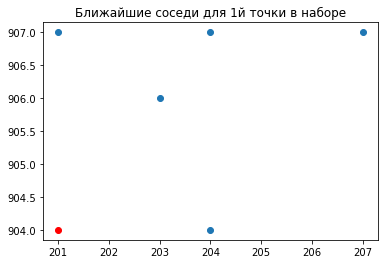

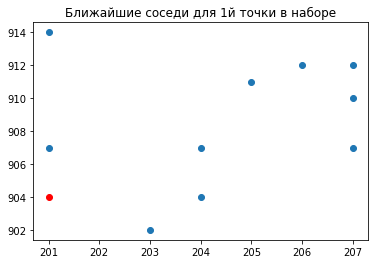

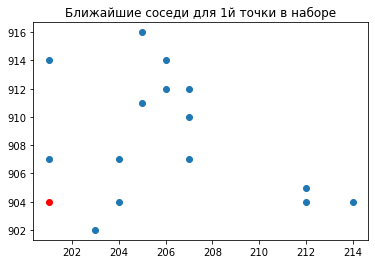

(1242, 24) (1242, 34) (1242, 44)


In [16]:
from sklearn.neighbors import BallTree
from scipy import stats

def calculate_stats(data, column):
    """Рассчет статистик для выбранного столбца
       Результат: датафрейм"""
    
    data[column+'_mean'] = data[column].apply(lambda x: np.mean(x))
    data[column+'_median'] = data[column].apply(lambda x: np.median(x))
    data[column+'_std'] = data[column].apply(lambda x: np.std(x))
    data[column+'_scope'] = data[column].apply(lambda x: np.max(x)-np.min(x))
    data[column+'_skew'] = data[column].apply(lambda x: stats.skew(x))
    data[column+'_kurt'] = data[column].apply(lambda x: stats.kurtosis(x))
    return data

def extraxt_info(data,column,neighbours):
    for i in range(neighbours-1):
        data[str(i)+'_'+column] = data['Neighbours_dist'].apply(lambda x: x[i])
    return data

def generate_new_features(data,neighbours):
    df = data.copy()
    bt = BallTree(pd.DataFrame(data_train.drop('NTG',axis=1)), metric='euclidean')
    dist, ind = bt.query(df[['X','Y']], k=neighbours)
    #Индексы ближайших соседей, без 1го столбца, тк в нем исходная точка\
    ind_final = ind[:,1:]
    dist_final = dist[:,1:]
    df['Neighbours_idx'] = [d for d in ind_final]
    df['Neighbours_dist'] = [d for d in dist_final]
    df['Neighbours_NTG'] = [list(data_train.loc[d,'NTG']) for d in df['Neighbours_idx']]
    plt.scatter(data_train.iloc[ind_final[3],0],data_train.iloc[ind_final[3],1])
    plt.scatter(df.iloc[3,0],df.iloc[3,1],color='r')
    plt.title('Ближайшие соседи для 1й точки в наборе')
    plt.show()
    #Рассчит статистик
    df =  calculate_stats(df,'Neighbours_NTG')
    df =  calculate_stats(df,'Neighbours_dist')
    #Извлечение инфо о ближайших скважин
    extraxt_info(df,'Neighbours_dist',neighbours)
    extraxt_info(df,'Neighbours_NTG',neighbours)
    #Удаление лишних столбцов
    df.drop([ 'Neighbours_idx', 'Neighbours_dist', 'Neighbours_NTG'],axis=1,inplace=True)
    return df


data_test_5neighbours_stats = generate_new_features(data_test,6)
data_test_10neighbours_stats = generate_new_features(data_test,11)
data_test_15neighbours_stats = generate_new_features(data_test,16)
print(data_test_5neighbours_stats.shape,data_test_10neighbours_stats.shape,data_test_15neighbours_stats.shape)

**Тестовый набор с ближайшими соседями и полиномиальными фичами**

In [31]:
data_test_poly4_15nn = nn_poly_concat(4,data_test_15neighbours_stats,data_test)
data_test_poly4_15nn

,X^2,X Y,Y^2,X^3,X^2 Y,X Y^2,Y^3,X^4,X^3 Y,X^2 Y^2,...,5_Neighbours_NTG,6_Neighbours_NTG,7_Neighbours_NTG,8_Neighbours_NTG,9_Neighbours_NTG,10_Neighbours_NTG,11_Neighbours_NTG,12_Neighbours_NTG,13_Neighbours_NTG,14_Neighbours_NTG
0,40401.0,181101.0,811801.0,8120601.0,36401301.0,163172001.0,731432701.0,1.632241e+09,7.316662e+09,3.279757e+10,...,10.770330,10.816654,11.401754,11.704700,12.083046,12.529964,13.000000,13.341664,13.928388,15.033296
1,40401.0,181302.0,813604.0,8120601.0,36441702.0,163534404.0,733870808.0,1.632241e+09,7.324782e+09,3.287042e+10,...,9.848858,10.000000,11.180340,11.180340,11.401754,11.661904,12.000000,13.000000,13.152946,14.560220
2,40401.0,181503.0,815409.0,8120601.0,36482103.0,163897209.0,736314327.0,1.632241e+09,7.332903e+09,3.294334e+10,...,8.944272,9.219544,10.295630,10.816654,11.000000,11.045361,11.180340,12.083046,13.038405,13.601471
3,40401.0,181704.0,817216.0,8120601.0,36522504.0,164260416.0,738763264.0,1.632241e+09,7.341023e+09,3.301634e+10,...,8.062258,8.485281,9.433981,10.000000,10.000000,11.000000,11.045361,11.180340,12.649111,13.000000
4,40401.0,181905.0,819025.0,8120601.0,36562905.0,164624025.0,741217625.0,1.632241e+09,7.349144e+09,3.308943e+10,...,7.211103,7.810250,8.602325,9.000000,9.219544,10.295630,11.000000,11.045361,11.704700,12.206556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237,60516.0,227796.0,857476.0,14886936.0,56037816.0,210939096.0,794022776.0,3.662186e+09,1.378530e+10,5.189102e+10,...,5.385165,6.000000,6.324555,6.324555,6.403124,7.071068,8.062258,8.246211,8.944272,9.219544
1238,60516.0,228042.0,859329.0,14886936.0,56098332.0,211394934.0,796597983.0,3.662186e+09,1.380019e+10,5.200315e+10,...,6.082763,6.082763,6.324555,7.071068,7.280110,7.810250,8.544004,8.602325,9.486833,9.848858
1239,60516.0,228288.0,861184.0,14886936.0,56158848.0,211851264.0,799178752.0,3.662186e+09,1.381508e+10,5.211541e+10,...,6.000000,6.324555,7.280110,7.810250,8.246211,8.602325,8.944272,9.219544,9.848858,10.630146
1240,60516.0,228534.0,863041.0,14886936.0,56219364.0,212308086.0,801765089.0,3.662186e+09,1.382996e+10,5.222779e+10,...,6.324555,6.708204,8.246211,8.602325,9.219544,9.433981,9.433981,9.899495,10.295630,11.313708


In [32]:
data_test_poly4_5nn = nn_poly_concat(4,data_test_5neighbours_stats,data_test)
data_test_poly4_5nn

,X^2,X Y,Y^2,X^3,X^2 Y,X Y^2,Y^3,X^4,X^3 Y,X^2 Y^2,...,0_Neighbours_dist,1_Neighbours_dist,2_Neighbours_dist,3_Neighbours_dist,4_Neighbours_dist,0_Neighbours_NTG,1_Neighbours_NTG,2_Neighbours_NTG,3_Neighbours_NTG,4_Neighbours_NTG
0,40401.0,181101.0,811801.0,8120601.0,36401301.0,163172001.0,731432701.0,1.632241e+09,7.316662e+09,3.279757e+10,...,4.242641,5.385165,6.000000,6.708204,8.485281,4.242641,5.385165,6.000000,6.708204,8.485281
1,40401.0,181302.0,813604.0,8120601.0,36441702.0,163534404.0,733870808.0,1.632241e+09,7.324782e+09,3.287042e+10,...,3.605551,4.472136,5.000000,5.830952,7.810250,3.605551,4.472136,5.000000,5.830952,7.810250
2,40401.0,181503.0,815409.0,8120601.0,36482103.0,163897209.0,736314327.0,1.632241e+09,7.332903e+09,3.294334e+10,...,3.162278,3.605551,4.000000,5.000000,7.211103,3.162278,3.605551,4.000000,5.000000,7.211103
3,40401.0,181704.0,817216.0,8120601.0,36522504.0,164260416.0,738763264.0,1.632241e+09,7.341023e+09,3.301634e+10,...,2.828427,3.000000,3.000000,4.242641,6.708204,2.828427,3.000000,3.000000,4.242641,6.708204
4,40401.0,181905.0,819025.0,8120601.0,36562905.0,164624025.0,741217625.0,1.632241e+09,7.349144e+09,3.308943e+10,...,2.236068,3.162278,3.605551,3.605551,6.324555,2.236068,3.162278,3.605551,3.605551,6.324555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237,60516.0,227796.0,857476.0,14886936.0,56037816.0,210939096.0,794022776.0,3.662186e+09,1.378530e+10,5.189102e+10,...,3.000000,3.000000,3.162278,3.605551,3.605551,3.000000,3.000000,3.162278,3.605551,3.605551
1238,60516.0,228042.0,859329.0,14886936.0,56098332.0,211394934.0,796597983.0,3.662186e+09,1.380019e+10,5.200315e+10,...,3.162278,3.162278,4.000000,4.123106,4.472136,3.162278,3.162278,4.000000,4.123106,4.472136
1239,60516.0,228288.0,861184.0,14886936.0,56158848.0,211851264.0,799178752.0,3.662186e+09,1.381508e+10,5.211541e+10,...,3.000000,3.605551,5.000000,5.099020,5.385165,3.000000,3.605551,5.000000,5.099020,5.385165
1240,60516.0,228534.0,863041.0,14886936.0,56219364.0,212308086.0,801765089.0,3.662186e+09,1.382996e+10,5.222779e+10,...,3.162278,4.242641,6.000000,6.082763,6.082763,3.162278,4.242641,6.000000,6.082763,6.082763


In [33]:
data_test_poly8_15nn = nn_poly_concat(8,data_test_15neighbours_stats,data_test)
data_test_poly8_15nn

,X^2,X Y,Y^2,X^3,X^2 Y,X Y^2,Y^3,X^4,X^3 Y,X^2 Y^2,...,5_Neighbours_NTG,6_Neighbours_NTG,7_Neighbours_NTG,8_Neighbours_NTG,9_Neighbours_NTG,10_Neighbours_NTG,11_Neighbours_NTG,12_Neighbours_NTG,13_Neighbours_NTG,14_Neighbours_NTG
0,40401.0,181101.0,811801.0,8120601.0,36401301.0,163172001.0,731432701.0,1.632241e+09,7.316662e+09,3.279757e+10,...,10.770330,10.816654,11.401754,11.704700,12.083046,12.529964,13.000000,13.341664,13.928388,15.033296
1,40401.0,181302.0,813604.0,8120601.0,36441702.0,163534404.0,733870808.0,1.632241e+09,7.324782e+09,3.287042e+10,...,9.848858,10.000000,11.180340,11.180340,11.401754,11.661904,12.000000,13.000000,13.152946,14.560220
2,40401.0,181503.0,815409.0,8120601.0,36482103.0,163897209.0,736314327.0,1.632241e+09,7.332903e+09,3.294334e+10,...,8.944272,9.219544,10.295630,10.816654,11.000000,11.045361,11.180340,12.083046,13.038405,13.601471
3,40401.0,181704.0,817216.0,8120601.0,36522504.0,164260416.0,738763264.0,1.632241e+09,7.341023e+09,3.301634e+10,...,8.062258,8.485281,9.433981,10.000000,10.000000,11.000000,11.045361,11.180340,12.649111,13.000000
4,40401.0,181905.0,819025.0,8120601.0,36562905.0,164624025.0,741217625.0,1.632241e+09,7.349144e+09,3.308943e+10,...,7.211103,7.810250,8.602325,9.000000,9.219544,10.295630,11.000000,11.045361,11.704700,12.206556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237,60516.0,227796.0,857476.0,14886936.0,56037816.0,210939096.0,794022776.0,3.662186e+09,1.378530e+10,5.189102e+10,...,5.385165,6.000000,6.324555,6.324555,6.403124,7.071068,8.062258,8.246211,8.944272,9.219544
1238,60516.0,228042.0,859329.0,14886936.0,56098332.0,211394934.0,796597983.0,3.662186e+09,1.380019e+10,5.200315e+10,...,6.082763,6.082763,6.324555,7.071068,7.280110,7.810250,8.544004,8.602325,9.486833,9.848858
1239,60516.0,228288.0,861184.0,14886936.0,56158848.0,211851264.0,799178752.0,3.662186e+09,1.381508e+10,5.211541e+10,...,6.000000,6.324555,7.280110,7.810250,8.246211,8.602325,8.944272,9.219544,9.848858,10.630146
1240,60516.0,228534.0,863041.0,14886936.0,56219364.0,212308086.0,801765089.0,3.662186e+09,1.382996e+10,5.222779e+10,...,6.324555,6.708204,8.246211,8.602325,9.219544,9.433981,9.433981,9.899495,10.295630,11.313708


# 3. Подбор моделей

### Случайный лес default с обычными и полиномиальальными признаками

In [105]:
rmse_rf_pipe_list = []
neg_rmse_cross_val_list = []

for i in range(1,11):
    print(i)
    steps = [
        ('poly', PolynomialFeatures(degree=i,include_bias=False)),
        ('model', RandomForestRegressor(random_state=0))
    ]
    
    
    rf_pipe = Pipeline(steps)
    neg_rmse_cross_val = np.mean(cross_val_score(rf_pipe, x_train, y_train, cv=3,scoring='neg_root_mean_squared_error'))
    print('ner rmse кросс-валидация',neg_rmse_cross_val)
    rf_pipe.fit(x_train,y_train)
    print('Прогноз для 1й строки',rf_pipe.predict(pd.DataFrame(x_train.iloc[0,:]).T))
    print('Данные по строке',data_train.iloc[0,2])
    pred = rf_pipe.predict(x_valid)
    rmse_rf_pipe = np.sqrt(mean_squared_error(y_valid,pred))
    print('rmse valid',rmse_rf_pipe)
    rmse_rf_pipe_list.append(rmse_rf_pipe)
    neg_rmse_cross_val_list.append(-1*neg_rmse_cross_val)
    print()

1
ner rmse кросс-валидация -0.06601924941971916
Прогноз для 1й строки [0.261218]
Данные по строке 0.2006
rmse valid 0.05512483861745079

2
ner rmse кросс-валидация -0.0669312253388733
Прогноз для 1й строки [0.263923]
Данные по строке 0.2006
rmse valid 0.052445236261402

3
ner rmse кросс-валидация -0.06746322246367303
Прогноз для 1й строки [0.269116]
Данные по строке 0.2006
rmse valid 0.05356139264913

4
ner rmse кросс-валидация -0.06685391955457115
Прогноз для 1й строки [0.270122]
Данные по строке 0.2006
rmse valid 0.05074450722055671

5
ner rmse кросс-валидация -0.06703095302701871
Прогноз для 1й строки [0.27344]
Данные по строке 0.2006
rmse valid 0.0503076670978546

6
ner rmse кросс-валидация -0.06661984763055809
Прогноз для 1й строки [0.270659]
Данные по строке 0.2006
rmse valid 0.050828676450826935

7
ner rmse кросс-валидация -0.06665270395753402
Прогноз для 1й строки [0.272326]
Данные по строке 0.2006
rmse valid 0.050287904193752134

8
ner rmse кросс-валидация -0.06535665834505229

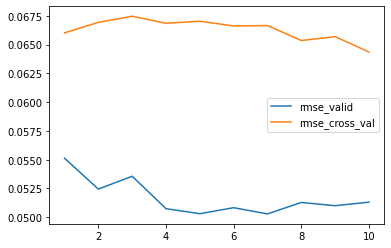

In [106]:
plt.plot(range(1,11),rmse_rf_pipe_list)
plt.plot(range(1,11),neg_rmse_cross_val_list)
plt.legend(['rmse_valid','rmse_cross_val'])

Случайный лес с дефолтными параметрами показывает наименьшее rmse на валидационной выборке при степени полинома 7, при этом значение rmse для 3 фолдов при тренировке не наименьшее

### Случайный лес GridSearch с обычными признаками

In [107]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold



param_grid = {
    'max_depth': [2,4,7, 10, 20, 60, None],
    'max_features': ['auto', 'sqrt','log2'],
    'min_samples_leaf': [2, 4, 5],
    'min_samples_split': [2,5, 10],
    'n_estimators': [50, 100, 200, 600, 1000, 1600, 2000]
}

    
    
# Create a based model
cv = KFold(n_splits=3, shuffle=True, random_state=241)
rf = RandomForestRegressor(random_state=241)
# Instantiate the grid search model
gs = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = cv, n_jobs = -1, verbose = 2,scoring='neg_root_mean_squared_error')
gs.fit(x_train,y_train)
print('GS best_score',gs.best_score_)

print('Прогноз для 1й строки',regr_rf.predict(pd.DataFrame(x_train.iloc[0,:]).T))
print('Данные по строке',data_train.iloc[0,2])
pred = regr_rf.predict(x_valid)
rmse = np.sqrt(mean_squared_error(y_valid,pred))
print('rmse valid',rmse)

regr_rf_gs_final = gs.best_estimator_

Fitting 3 folds for each of 1323 candidates, totalling 3969 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 15.3min


GS best_score -0.06151879089494242
Прогноз для 1й строки [0.261218]
Данные по строке 0.2006
rmse valid 0.05512483861745079


[Parallel(n_jobs=-1)]: Done 3969 out of 3969 | elapsed: 18.6min finished


In [108]:
regr_rf_gs_final

RandomForestRegressor(max_depth=7, min_samples_leaf=2, n_estimators=50,
                      random_state=241)

Улучшилось значение rmse при тренировке, ухудшилось на валидации

### Случайный лес RandomizedSearch с полиномиальными признаками

In [164]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

for i in range(1,9):

    steps = [
        ('poly', PolynomialFeatures(degree=i,include_bias=False)),
        ('model', RandomForestRegressor(random_state=0))
    ]
    parameters  = {
        'model__bootstrap': [True,False],
        'model__max_depth': [2,4,7, 10, 30, 60, 100, None],
        'model__max_features': ['auto', 'sqrt','log2'],
        'model__min_samples_leaf': [2, 4, 5],
        'model__min_samples_split': [2,5, 10],
        'model__n_estimators': [50, 100, 200, 600, 1000, 1600, 2000]
    }
    
    rf_pipe2 = Pipeline(steps)
    
    # Create a based model
    cv = KFold(n_splits=3, shuffle=True, random_state=241)
    # Instantiate the grid search model
    gs2 = RandomizedSearchCV(estimator = rf_pipe2, param_distributions = parameters, 
                              cv = cv, n_jobs = -1, verbose = 2,scoring='neg_root_mean_squared_error')
    gs2.fit(x_train,y_train)
    print('GS best_score',gs2.best_score_)
    regr_rf_gs_final_poly = gs2.best_estimator_
    
    
    print('Прогноз для 1й строки',regr_rf_gs_final_poly.predict(pd.DataFrame(x_train.iloc[0,:]).T))
    print('Данные по строке',data_train.iloc[0,2])
    pred2 = regr_rf_gs_final_poly.predict(x_valid)
    rmse_regr_rf_gs_final_poly = np.sqrt(mean_squared_error(y_valid,pred2))
    print('rmse valid',rmse_regr_rf_gs_final_poly)
    

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   13.5s finished


GS best_score -0.06799740900028205
Прогноз для 1й строки [0.28854674]
Данные по строке 0.2006
rmse valid 0.05925334127768209
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   19.2s finished


GS best_score -0.06662025271129263
Прогноз для 1й строки [0.29553445]
Данные по строке 0.2006
rmse valid 0.05699289625597247
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


GS best_score -0.06562685516792767
Прогноз для 1й строки [0.28748823]
Данные по строке 0.2006
rmse valid 0.06494919332536105
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   17.1s finished


GS best_score -0.0633138342831032
Прогноз для 1й строки [0.28998383]
Данные по строке 0.2006
rmse valid 0.05130751893530066
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.8s finished


GS best_score -0.06664961504701994
Прогноз для 1й строки [0.30070826]
Данные по строке 0.2006
rmse valid 0.056293442753188344
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   16.6s finished


GS best_score -0.0628151137403798
Прогноз для 1й строки [0.28833375]
Данные по строке 0.2006
rmse valid 0.049797145709661726
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   14.2s finished


GS best_score -0.06449061154764439
Прогноз для 1й строки [0.29739429]
Данные по строке 0.2006
rmse valid 0.05333558093729453
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.5s finished


GS best_score -0.062029275763581304
Прогноз для 1й строки [0.29624536]
Данные по строке 0.2006
rmse valid 0.04893093319005183


#### RandomForestRegressor  GridSearchCV poly features bias

In [92]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np


steps = [
    ('poly', PolynomialFeatures(degree=7)),
    ('model', RandomForestRegressor(random_state=0))
]
parameters  = {
    'model__bootstrap': [True,False],
    'model__max_depth': [2,4,7, 10, 30, 60, 100, None],
    'model__max_features': ['auto', 'sqrt','log2'],
    'model__min_samples_leaf': [2, 4, 5],
    'model__min_samples_split': [2,5, 10],
    'model__n_estimators': [50, 100, 200, 600, 1000, 1600, 2000]
}

rf_pipe3 = Pipeline(steps)

# Create a based model
cv = KFold(n_splits=3, shuffle=True, random_state=241)
# Instantiate the grid search model
gs3 = GridSearchCV(estimator = rf_pipe3, param_grid = parameters, 
                          cv = cv, n_jobs = -1, verbose = 2,scoring='neg_root_mean_squared_error')
gs3.fit(x_train,y_train)
print('GS best_score',gs3.best_score_)
regr_rf_gs_final_poly2 = gs3.best_estimator_


print('Прогноз для 1й строки',regr_rf_gs_final_poly2.predict(pd.DataFrame(x_train.iloc[0,:]).T))
print('Данные по строке',data_train.iloc[0,2])
pred2 = regr_rf_gs_final_poly2.predict(x_valid)
rmse_regr_rf_gs_final_poly2 = np.sqrt(mean_squared_error(y_valid,pred2))
print('rmse valid',rmse_regr_rf_gs_final_poly2)


Fitting 3 folds for each of 3024 candidates, totalling 9072 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 452.9min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 456.3min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 460.2min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 464.5min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 468.9min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 473.4min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 478.4min
[Parallel(n_jobs=-1)]: Done 9072 out of 

GS best_score -0.0590695728901251
Прогноз для 1й строки [0.28624894]
Данные по строке 0.2006
rmse valid 0.05081343386309408


In [122]:
regr_rf_gs_final_poly2_refit = regr_rf_gs_final_poly2.fit(X_shuffeled, y_shuffeled)
pred3 = regr_rf_gs_final_poly2_refit.predict(x_valid)
rmse_regr_rf_gs_final_poly2_refit = np.sqrt(mean_squared_error(y_valid,pred3))
print('rmse valid',rmse_regr_rf_gs_final_poly2_refit)
regr_rf_gs_final_poly2_refit

rmse valid 0.03019049032373102


In [124]:
regr_rf_gs_final_poly2_refit

Pipeline(steps=[('poly', PolynomialFeatures(degree=7)),
                ('model',
                 RandomForestRegressor(max_depth=7, min_samples_leaf=2,
                                       n_estimators=50, random_state=0))])

### Прогноз RandomForestRegressor  GridSearchCV poly features bias

In [128]:
predictions_1_rf_poly7_gs = regr_rf_gs_final_poly2_refit.predict(data_test)
predictions_1_rf_poly7_gs

array([0.3078511 , 0.3019997 , 0.32113546, ..., 0.38801363, 0.38801363,
       0.38801363])

In [133]:
data_test0['NTG'] = predictions_1_rf_poly7_gs
data_test0

,Well,X,Y,NTG
0,201-901,201,901,0.307851
1,201-902,201,902,0.302000
2,201-903,201,903,0.321135
3,201-904,201,904,0.278315
4,201-905,201,905,0.262618
...,...,...,...,...
1237,246-926,246,926,0.388014
1238,246-927,246,927,0.388014
1239,246-928,246,928,0.388014
1240,246-929,246,929,0.388014


In [147]:
data_test0.to_csv(r'.\data\attempts\1_data_test.csv',index=False)
X_shuffeled.to_csv(r'.\data\attempts\1_X_shuffeled.csv',index=False)
y_shuffeled.to_csv(r'.\data\attempts\1_y_shuffeled.csv',index=False)

In [146]:
# Сохранение модели и тест загрузки
import pickle

with open(r'.\data\attempts\1_regr_rf_gs_final_poly_refit.pkl', 'wb') as output:
       pickle.dump(regr_rf_gs_final_poly2_refit, output)
        
# Загружаем сохраненный файл
with open(r'.\data\attempts\1_regr_rf_gs_final_poly_refit.pkl', 'rb') as pkl_file:
    p1 = pickle.load(pkl_file)
p1.predict(data_test)

array([0.3078511 , 0.3019997 , 0.32113546, ..., 0.38801363, 0.38801363,
       0.38801363])

#### RandomForestRegressor  GridSearchCV poly features

In [165]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np


steps = [
    ('poly', PolynomialFeatures(degree=8,include_bias=False)),
    ('model', RandomForestRegressor(random_state=0))
]
parameters  = {
    'model__bootstrap': [True,False],
    'model__max_depth': [2,4,7, 10, 30, 60, 100, None],
    'model__max_features': ['auto', 'sqrt','log2'],
    'model__min_samples_leaf': [2, 4, 5],
    'model__min_samples_split': [2,5, 10],
    'model__n_estimators': [50, 100, 200, 600, 1000, 1600, 2000]
}

rf_pipe3 = Pipeline(steps)

# Create a based model
cv = KFold(n_splits=3, shuffle=True, random_state=241)
# Instantiate the grid search model
gs3 = GridSearchCV(estimator = rf_pipe3, param_grid = parameters, 
                          cv = cv, n_jobs = -1, verbose = 2,scoring='neg_root_mean_squared_error')
gs3.fit(x_train,y_train)
print('GS best_score',gs3.best_score_)
regr_rf_gs_final_poly2 = gs3.best_estimator_


print('Прогноз для 1й строки',regr_rf_gs_final_poly2.predict(pd.DataFrame(x_train.iloc[0,:]).T))
print('Данные по строке',data_train.iloc[0,2])
pred2 = regr_rf_gs_final_poly2.predict(x_valid)
rmse_regr_rf_gs_final_poly2 = np.sqrt(mean_squared_error(y_valid,pred2))
print('rmse valid',rmse_regr_rf_gs_final_poly2)


Fitting 3 folds for each of 3024 candidates, totalling 9072 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 30.4min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 34.9min


GS best_score -0.05847891531146751
Прогноз для 1й строки [0.283729]
Данные по строке 0.2006
rmse valid 0.05210496133510957


[Parallel(n_jobs=-1)]: Done 9072 out of 9072 | elapsed: 39.6min finished


In [166]:
regr_rf_gs_final_poly2_refit = regr_rf_gs_final_poly2.fit(X_shuffeled, y_shuffeled)
pred3 = regr_rf_gs_final_poly2_refit.predict(x_valid)
rmse_regr_rf_gs_final_poly2_refit = np.sqrt(mean_squared_error(y_valid,pred3))
print('rmse valid',rmse_regr_rf_gs_final_poly2_refit)
regr_rf_gs_final_poly2_refit

rmse valid 0.02586907332552574


Pipeline(steps=[('poly', PolynomialFeatures(degree=8, include_bias=False)),
                ('model',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=2,
                                       n_estimators=50, random_state=0))])

In [170]:
regr_rf_gs_final_poly2_refit

Pipeline(steps=[('poly', PolynomialFeatures(degree=8, include_bias=False)),
                ('model',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=2,
                                       n_estimators=50, random_state=0))])

In [26]:
# Загружаем сохраненный файл
with open(r'.\data\attempts\3_regr_rf_gs_final_poly_refit.pkl', 'rb') as pkl_file:
    p3 = pickle.load(pkl_file)


array([0.3078511 , 0.3019997 , 0.31804146, ..., 0.38772467, 0.38772467,
       0.38772467])

In [56]:
top_10_features_idxs = list(pd.DataFrame(p3.steps[1][1].feature_importances_).reset_index().sort_values(by=0,ascending=False).iloc[:10]['index'])
top_15_features_idxs = list(pd.DataFrame(p3.steps[1][1].feature_importances_).reset_index().sort_values(by=0,ascending=False).iloc[:15]['index'])
top_15_features_idxs

[42, 33, 13, 25, 1, 34, 43, 18, 8, 26, 4, 19, 41, 12, 32]

In [75]:
top_10_features_idxs

[42, 33, 13, 25, 1, 34, 43, 18, 8, 26]

### Прогноз RandomForestRegressor  GridSearchCV poly features

In [171]:
regr_rf_gs_final_poly2_refit

Pipeline(steps=[('poly', PolynomialFeatures(degree=8, include_bias=False)),
                ('model',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=2,
                                       n_estimators=50, random_state=0))])

In [167]:
predictions_3_rf_poly7_gs = regr_rf_gs_final_poly2_refit.predict(data_test)
predictions_3_rf_poly7_gs

array([0.3078511 , 0.3019997 , 0.31804146, ..., 0.38772467, 0.38772467,
       0.38772467])

In [168]:
data_test02 = data_test0.copy()
data_test02['NTG'] = predictions_3_rf_poly7_gs
data_test02

,Well,X,Y,NTG
0,201-901,201,901,0.307851
1,201-902,201,902,0.302000
2,201-903,201,903,0.318041
3,201-904,201,904,0.279159
4,201-905,201,905,0.263461
...,...,...,...,...
1237,246-926,246,926,0.386548
1238,246-927,246,927,0.386809
1239,246-928,246,928,0.387725
1240,246-929,246,929,0.387725


In [169]:
data_test02.to_csv(r'.\data\attempts\3_data_test.csv',index=False)
X_shuffeled.to_csv(r'.\data\attempts\3_X_shuffeled.csv',index=False)
y_shuffeled.to_csv(r'.\data\attempts\3_y_shuffeled.csv',index=False)

In [172]:
# Сохранение модели и тест загрузки
import pickle

with open(r'.\data\attempts\3_regr_rf_gs_final_poly_refit.pkl', 'wb') as output:
       pickle.dump(regr_rf_gs_final_poly2_refit, output)
        
# Загружаем сохраненный файл
with open(r'.\data\attempts\3_regr_rf_gs_final_poly_refit.pkl', 'rb') as pkl_file:
    p3 = pickle.load(pkl_file)
p3.predict(data_test)

array([0.3078511 , 0.3019997 , 0.31804146, ..., 0.38772467, 0.38772467,
       0.38772467])

### RandomForestRegressor top 10 features selection

In [81]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np


poly_trans = p3.steps[0][1]
x_train_poly = poly_trans.transform(x_train)
x_train_poly_fs = x_train_poly[:,top_10_features_idxs]

x_valid_poly = poly_trans.transform(x_valid)
x_valid_poly_fs = x_valid_poly[:,top_10_features_idxs]

parameters  = {
    'bootstrap': [True,False],
    'max_depth': [2,4,7, 10, 30, 60, 100, None],
    'max_features': ['auto', 'sqrt','log2'],
    'min_samples_leaf': [2, 4, 5],
    'min_samples_split': [2,5, 10],
    'n_estimators': [50, 100, 200, 600, 1000, 1600, 2000]
}

rf_future_sel = RandomForestRegressor(random_state=0)

# Create a based model
cv = KFold(n_splits=3, shuffle=True, random_state=241)
# Instantiate the grid search model
gs7 = GridSearchCV(estimator = rf_future_sel, param_grid = parameters, 
                          cv = cv, n_jobs = -1, verbose = 2,scoring='neg_root_mean_squared_error')
gs7.fit(x_train_poly_fs,y_train)
print('GS best_score',gs7.best_score_)
rf_future_sel_final = gs7.best_estimator_


pred7 = rf_future_sel_final.predict(x_valid_poly_fs)
rmse_rf_future_sel_final = np.sqrt(mean_squared_error(y_valid,pred7))
print('rmse valid',rmse_rf_future_sel_final)


Fitting 3 folds for each of 3024 candidates, totalling 9072 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 26.8min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 29.8min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 33.2min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 36.9min


GS best_score -0.05688992473940532


[Parallel(n_jobs=-1)]: Done 9072 out of 9072 | elapsed: 40.8min finished


ValueError: Number of features of the model must match the input. Model n_features is 10 and input n_features is 2 

In [83]:
X_shuffeled_poly = poly_trans.transform(X_shuffeled)
X_shuffeled_fs = X_shuffeled_poly[:,top_10_features_idxs]

rf_future_sel_final_refit = rf_future_sel_final.fit(X_shuffeled_fs, y_shuffeled)
pred77 = rf_future_sel_final_refit.predict(x_valid_poly_fs)
rmse_rf_future_sel_final_refit = np.sqrt(mean_squared_error(y_valid,pred77))
print('rmse valid',rmse_rf_future_sel_final_refit)
rf_future_sel_final

rmse valid 0.034266308380544015


RandomForestRegressor(max_depth=7, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=50, random_state=0)

### RandomForestRegressor top 15 features selection

In [84]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np




poly_trans = p3.steps[0][1]
x_train_poly = poly_trans.transform(x_train)
x_train_poly_fs15 = x_train_poly[:,top_15_features_idxs]

x_valid_poly = poly_trans.transform(x_valid)
x_valid_poly_fs15 = x_valid_poly[:,top_15_features_idxs]

parameters  = {
    'bootstrap': [True,False],
    'max_depth': [2,4,7, 10, 30, 60, 100, None],
    'max_features': ['auto', 'sqrt','log2'],
    'min_samples_leaf': [2, 4, 5],
    'min_samples_split': [2,5, 10],
    'n_estimators': [50, 100, 200, 600, 1000, 1600, 2000]
}

rf_future_sel15 = RandomForestRegressor(random_state=0)

# Create a based model
cv = KFold(n_splits=3, shuffle=True, random_state=241)
# Instantiate the grid search model
gs7_fs15 = GridSearchCV(estimator = rf_future_sel15, param_grid = parameters, 
                          cv = cv, n_jobs = -1, verbose = 2,scoring='neg_root_mean_squared_error')
gs7_fs15.fit(x_train_poly_fs15,y_train)
print('GS best_score',gs7_fs15.best_score_)
rf_future_sel15_final = gs7_fs15.best_estimator_


pred7_fs15 = rf_future_sel15_final.predict(x_valid_poly_fs15)
rmse_rf_future_sel15_final = np.sqrt(mean_squared_error(y_valid,pred7_fs15))
print('rmse valid',rmse_rf_future_sel15_final)


Fitting 3 folds for each of 3024 candidates, totalling 9072 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 68.8min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 73.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 77.9min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 82.6min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 86.9min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 91.6min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 96.6min
[Parallel(n_jobs=-1)]: Done 9072 out of 9072 | 

GS best_score -0.057212993681697


ValueError: Number of features of the model must match the input. Model n_features is 15 and input n_features is 10 

In [85]:
pred7_fs15 = rf_future_sel15_final.predict(x_valid_poly_fs15)
rmse_rf_future_sel15_final = np.sqrt(mean_squared_error(y_valid,pred7_fs15))
print('rmse valid',rmse_rf_future_sel15_final)

rmse valid 0.0536355076034691


In [86]:
X_shuffeled_poly = poly_trans.transform(X_shuffeled)
X_shuffeled_fs15 = X_shuffeled_poly[:,top_15_features_idxs]

rf_future_sel15_final_refit = rf_future_sel15_final.fit(X_shuffeled_fs15, y_shuffeled)
pred77_fs15 = rf_future_sel15_final_refit.predict(x_valid_poly_fs15)
rmse_rf_future_sel15_final_refit = np.sqrt(mean_squared_error(y_valid,pred77_fs15))
print('rmse valid',rmse_rf_future_sel15_final_refit)
rf_future_sel15_final

rmse valid 0.030379346317608087


RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=200, random_state=0)

### Прогноз RandomForestRegressor FutureSelection Top15

In [87]:


predictions_7_rf_poly7_gs_fs15 = rf_future_sel15_final.predict(poly_trans.transform(data_test)[:,top_15_features_idxs])
predictions_7_rf_poly7_gs_fs15

array([0.30557506, 0.30205816, 0.3224077 , ..., 0.36824981, 0.36596246,
       0.3657952 ])

In [88]:
data_test07 = data_test0.copy()
data_test07['NTG'] = predictions_7_rf_poly7_gs_fs15
data_test07

,Well,X,Y,NTG
0,201-901,201,901,0.305575
1,201-902,201,902,0.302058
2,201-903,201,903,0.322408
3,201-904,201,904,0.267401
4,201-905,201,905,0.256928
...,...,...,...,...
1237,246-926,246,926,0.361235
1238,246-927,246,927,0.367709
1239,246-928,246,928,0.368250
1240,246-929,246,929,0.365962


In [91]:
data_test07.to_csv(r'.\data\attempts\7_data_test.csv',index=False)
pd.DataFrame(X_shuffeled_fs15).to_csv(r'.\data\attempts\7_X_shuffeled.csv',index=False)
y_shuffeled.to_csv(r'.\data\attempts\7_y_shuffeled.csv',index=False)

# Сохранение модели и тест загрузки
import pickle

with open(r'.\data\attempts\7_predictions_7_rf_poly7_gs_fs15.pkl', 'wb') as output:
       pickle.dump(rf_future_sel15_final_refit, output)
        
# Загружаем сохраненный файл
with open(r'.\data\attempts\7_predictions_7_rf_poly7_gs_fs15.pkl', 'rb') as pkl_file:
    p7 = pickle.load(pkl_file)
p7.predict(poly_trans.transform(data_test)[:,top_15_features_idxs])

array([0.30557506, 0.30205816, 0.3224077 , ..., 0.36824981, 0.36596246,
       0.3657952 ])

### RandomForest nn_set

In [ ]:
y_with_5neighbours_stats = data_train_with_5neighbours_stats['NTG']
x_train_5nn,x_valid_5nn,y_train_5nn,y_valid_5nn 

In [348]:

def rf_random_search_executor(x_t,y_t,x_v,y_v):
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.model_selection import cross_val_score
    from sklearn.metrics import mean_squared_error
    import numpy as np
    
    
    
    parameters  = {
        'bootstrap': [True,False],
        'max_depth': [2,4,7, 10, 30, 60, 100, None],
        'max_features': ['auto', 'sqrt','log2'],
        'min_samples_leaf': [2, 4, 5],
        'min_samples_split': [2,5, 10],
        'n_estimators': [50, 100, 200, 600, 1000, 1600, 2000]
    }
    
    rf_future_sel15 = RandomForestRegressor(random_state=0)
    
    # Create a based model
    cv = KFold(n_splits=3, shuffle=True, random_state=241)
    # Instantiate the grid search model
    gs7_fs15 = RandomizedSearchCV(estimator = rf_future_sel15, param_distributions = parameters, 
                              cv = cv, n_jobs = -1, verbose = 2,scoring='neg_root_mean_squared_error')
    gs7_fs15.fit(x_t,y_t)
    print('GS best_score',gs7_fs15.best_score_)
    rf_future_sel15_final = gs7_fs15.best_estimator_
    
    
    pred7_fs15 = rf_future_sel15_final.predict(x_v)
    rmse_rf_future_sel15_final = np.sqrt(mean_squared_error(y_v,pred7_fs15))
    print('rmse valid',rmse_rf_future_sel15_final)
    return rf_future_sel15_final

rf_random_search_executor(x_train_5nn,y_train_5nn,x_valid_5nn,y_valid_5nn )

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


GS best_score -0.06608007083361343
rmse valid 0.0579185765068319


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   18.1s finished


RandomForestRegressor(max_depth=7, min_samples_leaf=5, n_estimators=50,
                      random_state=0)

In [349]:
rf_random_search_executor(x_train_10nn,y_train_10nn,x_valid_10nn,y_valid_10nn )

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.7s finished


GS best_score -0.06183640442195513
rmse valid 0.06372186693048153


RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=5,
                      random_state=0)

In [350]:
rf_random_search_executor(x_train_15nn,y_train_15nn,x_valid_15nn,y_valid_10nn )

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   13.6s finished


GS best_score -0.06652808057673448
rmse valid 0.05381206362729757


RandomForestRegressor(max_depth=7, min_samples_leaf=2, n_estimators=600,
                      random_state=0)

Набор данных с 15 соседями сработал лучше всего

### RandomForest 15nn_set poly8

In [ ]:
poly8_15nn_set = nn_poly_concat(8,data_train_with_15neighbours_stats,data_train)

X_poly8_15nn = poly8_15nn_set.drop('NTG',axis=1)
y_poly8_15nn = poly8_15nn_set['NTG']
x_train_p8_15nn,x_valid_p8_15nn,y_train_p8_15nn,y_valid_p8_15nnn = train_test_split(X_poly8_15nn, y_poly8_15nn, test_size=0.25, random_state=240,shuffle=True)

data_15nn_p8_shuffeled = poly8_15nn_set.sample(frac=1,random_state=0)
X_15nn_p8_shuffeled = data_15nn_p8_shuffeled.drop('NTG',axis=1)
y_15nn_p8_shuffeled = data_15nn_p8_shuffeled['NTG']

In [403]:
parameters  = {
    'bootstrap': [True,False],
    'max_depth': [2,4,7, 10, 30, 60, 100, None],
    'max_features': ['auto', 'sqrt','log2'],
    'min_samples_leaf': [2, 4, 5],
    'min_samples_split': [2,5, 10],
    'n_estimators': [50, 100, 200, 600, 1000, 1600, 2000]
}

rf_p8_nn15 = RandomForestRegressor(random_state=0)

# Create a based model
cv = KFold(n_splits=3, shuffle=True, random_state=241)
# Instantiate the grid search model
gs_p8_nn15 = RandomizedSearchCV(estimator = rf_p8_nn15, param_distributions = parameters, 
                          cv = cv, n_jobs = -1, verbose = 2,scoring='neg_root_mean_squared_error')
gs_p8_nn15.fit(x_train_p8_15nn,y_train_p8_15nn)
print('GS best_score',gs_p8_nn15.best_score_)
rf_gs_p8_nn15_final = gs_p8_nn15.best_estimator_


pred_16 = rf_gs_p8_nn15_final.predict(x_valid_p8_15nn)
rmse_p8_nn15_final = np.sqrt(mean_squared_error(y_valid_p8_15nnn,pred_16))
print('rmse valid',rmse_p8_nn15_final)



Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


GS best_score -0.06463086260228768
rmse valid 0.050960543952537365


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.3s finished


### Прогноз RandomForest 15nn_set poly8

In [406]:
p8_nn15_final_refit = rf_gs_p8_nn15_final.fit (X_15nn_p8_shuffeled, y_15nn_p8_shuffeled)

In [407]:
make_test_predictions_save_model(p8_nn15_final_refit,data_test_poly8_15nn,'\\16_data_test.csv',X_15nn_p8_shuffeled, y_15nn_p8_shuffeled,'\\16_X_shuffeled.csv','\\16_y_shuffeled.csv','\\16_rf_p8_nn15.pkl')


      Well    X    Y       NTG
0  201-901  201  901  0.288638
1  201-902  201  902  0.277304
2  201-903  201  903  0.270771
3  201-904  201  904  0.248219
4  201-905  201  905  0.248651
[0.28863842 0.27730392 0.27077146 ... 0.38951921 0.39131663 0.40970079]


In [418]:
len(X_15nn_p8_shuffeled.columns)

86

### Прогноз RandomForest 15nn_set poly8

In [426]:
top_40_features_name = list(pd.DataFrame(p8_nn15_final_refit.feature_importances_,X_15nn_p8_shuffeled.columns).reset_index().sort_values(by=0,ascending=False).iloc[:40]['index'])


['Neighbours_NTG_mean',
 'X Y^6',
 'X Y^7',
 'Y^2',
 'Y',
 'Y^3',
 'X Y^4',
 'Y^6',
 'Y^8',
 'X Y^5',
 'Y^7',
 'Y^4',
 'Y^5',
 'Neighbours_NTG_std',
 'X^3 Y^3',
 'X^5 Y',
 'X^2 Y^6',
 'Neighbours_dist_mean',
 'X^3 Y^4',
 'X^4 Y^3']

In [434]:
p8_nn15_final_refit_40f = rf_gs_p8_nn15_final.fit (X_15nn_p8_shuffeled[top_40_features_name], y_15nn_p8_shuffeled)

In [435]:
make_test_predictions_save_model(p8_nn15_final_refit_40f,data_test_poly8_15nn[top_40_features_name],'\\17_data_test.csv',X_15nn_p8_shuffeled[top_40_features_name], y_15nn_p8_shuffeled,'\\17_X_shuffeled.csv','\\17_y_shuffeled.csv','\\17_rf_p8_nn15_40f.pkl')


      Well    X    Y       NTG
0  201-901  201  901  0.252527
1  201-902  201  902  0.252527
2  201-903  201  903  0.252527
3  201-904  201  904  0.248774
4  201-905  201  905  0.247131
[0.25252667 0.25252667 0.25252667 ... 0.38941338 0.38983792 0.3929055 ]


### GradientBoostingRegressor default с обычными и полиномиальальными признаками

In [148]:
from sklearn.ensemble import GradientBoostingRegressor

rmse_gb_pipe_list = []
neg_rmse_cross_val_list_gb = []


for i in range(1,11):
    print(i)
    steps = [
        ('poly', PolynomialFeatures(degree=i,include_bias=False)),
        ('model', GradientBoostingRegressor(random_state=0))
    ]
    
    
    gb_pipe = Pipeline(steps)
    neg_rmse_cross_val_gb = np.mean(cross_val_score(gb_pipe, x_train, y_train, cv=3,scoring='neg_root_mean_squared_error'))
    print('ner rmse кросс-валидация',neg_rmse_cross_val_gb)
    gb_pipe.fit(x_train,y_train)
    print('Прогноз для 1й строки',gb_pipe.predict(pd.DataFrame(x_train.iloc[0,:]).T))
    print('Данные по строке',data_train.iloc[0,2])
    pred_gb = gb_pipe.predict(x_valid)
    rmse_gb_pipe = np.sqrt(mean_squared_error(y_valid,pred_gb))
    print('rmse valid',rmse_gb_pipe)
    rmse_gb_pipe_list.append(rmse_gb_pipe)
    neg_rmse_cross_val_list_gb.append(-1*neg_rmse_cross_val_gb)
    print()

1
ner rmse кросс-валидация -0.06555698465961027
Прогноз для 1й строки [0.28373403]
Данные по строке 0.2006
rmse valid 0.060880551678840045

2
ner rmse кросс-валидация -0.06488015034023992
Прогноз для 1й строки [0.28205444]
Данные по строке 0.2006
rmse valid 0.05114397306552973

3
ner rmse кросс-валидация -0.0651840255955317
Прогноз для 1й строки [0.27252971]
Данные по строке 0.2006
rmse valid 0.052906115647782345

4
ner rmse кросс-валидация -0.06641748352059977
Прогноз для 1й строки [0.27841099]
Данные по строке 0.2006
rmse valid 0.05057400218384421

5
ner rmse кросс-валидация -0.06824407862882025
Прогноз для 1й строки [0.27249118]
Данные по строке 0.2006
rmse valid 0.04966601429435013

6
ner rmse кросс-валидация -0.0670488307540431
Прогноз для 1й строки [0.27779503]
Данные по строке 0.2006
rmse valid 0.050110485478786986

7
ner rmse кросс-валидация -0.06536402024820233
Прогноз для 1й строки [0.2654602]
Данные по строке 0.2006
rmse valid 0.052879394836197365

8
ner rmse кросс-валидация

### GradientBoostingRegressor RandomizedSearch с полиномиальными признаками

In [150]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

for i in range(1,9):
    print(i)
    steps = [
        ('poly', PolynomialFeatures(degree=i,include_bias=False)),
        ('model', GradientBoostingRegressor(random_state=0))
    ]

    
    parameters={'model__n_estimators':[100, 200, 600, 1000, 1600, 2000,5000], 
                'model__learning_rate': [0.001, 0.05, 0.02, 0.01], 
                'model__max_depth':[3,5,7,10,20], 
                'model__min_samples_leaf':[3,5,9,17], 
                'model__min_samples_split': [2,5, 10],
                'model__max_features':['auto', 'sqrt', 'log2'] }
    gb_pipe2 = Pipeline(steps)
    
    # Create a based model
    cv = KFold(n_splits=3, shuffle=True, random_state=241)
    # Instantiate the grid search model
    gs_gb2 = RandomizedSearchCV(estimator = gb_pipe2, param_distributions = parameters, 
                              cv = cv, n_jobs = -1, verbose = 2,scoring='neg_root_mean_squared_error')
    gs_gb2.fit(x_train,y_train)
    print('GS best_score',gs_gb2.best_score_)
    regr_gb_gs_final_poly = gs_gb2.best_estimator_
    
    
    print('Прогноз для 1й строки',regr_gb_gs_final_poly.predict(pd.DataFrame(x_train.iloc[0,:]).T))
    print('Данные по строке',data_train.iloc[0,2])
    pred_gb2 = regr_gb_gs_final_poly.predict(x_valid)
    rmse_regr_gb_gs_final_poly2 = np.sqrt(mean_squared_error(y_valid,pred_gb2))
    print('rmse valid',rmse_regr_gb_gs_final_poly2)
    

1
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


GS best_score -0.06364778684330362
Прогноз для 1й строки [0.27502998]
Данные по строке 0.2006
rmse valid 0.05466978166700572
2
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.1s finished


GS best_score -0.06354795553545499
Прогноз для 1й строки [0.27074839]
Данные по строке 0.2006
rmse valid 0.05465349488567961
3
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


GS best_score -0.0626443914905368
Прогноз для 1й строки [0.28788789]
Данные по строке 0.2006
rmse valid 0.05558036541585019
4
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


GS best_score -0.060984534968071845
Прогноз для 1й строки [0.27317022]
Данные по строке 0.2006
rmse valid 0.05159181284178652
5
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.2s finished


GS best_score -0.0605282545622318
Прогноз для 1й строки [0.271572]
Данные по строке 0.2006
rmse valid 0.053175831921363846
6
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.0s finished


GS best_score -0.0622835697837135
Прогноз для 1й строки [0.25974379]
Данные по строке 0.2006
rmse valid 0.05419733150354051
7
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   14.1s finished


GS best_score -0.06339425708475083
Прогноз для 1й строки [0.27167432]
Данные по строке 0.2006
rmse valid 0.048308828452756566
8
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.9s finished


GS best_score -0.06083349083953998
Прогноз для 1й строки [0.28363848]
Данные по строке 0.2006
rmse valid 0.05120906414006342


In [153]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

steps = [
    ('poly', PolynomialFeatures(degree=7,include_bias=False)),
    ('model', GradientBoostingRegressor(random_state=0))
]


parameters={'model__n_estimators':[100, 200, 600, 1000, 1600,5000], 
            'model__learning_rate': [0.001, 0.05,  0.01], 
            'model__max_depth':[3,5,7,10,20], 
            'model__min_samples_leaf':[3,5,9,17], 
            'model__min_samples_split': [2,5, 9],
            'model__max_features':['auto', 'sqrt', 'log2'] }
gb_pipe2 = Pipeline(steps)

# Create a based model
cv = KFold(n_splits=3, shuffle=True, random_state=241)
# Instantiate the grid search model
gs_gb2 = GridSearchCV(estimator = gb_pipe2, param_grid = parameters, 
                          cv = cv, n_jobs = -1, verbose = 2,scoring='neg_root_mean_squared_error')
gs_gb2.fit(x_train,y_train)
print('GS best_score',gs_gb2.best_score_)
regr_gb_gs_final_poly = gs_gb2.best_estimator_


print('Прогноз для 1й строки',regr_gb_gs_final_poly.predict(pd.DataFrame(x_train.iloc[0,:]).T))
print('Данные по строке',data_train.iloc[0,2])
pred_gb2 = regr_gb_gs_final_poly.predict(x_valid)
rmse_regr_gb_gs_final_poly2 = np.sqrt(mean_squared_error(y_valid,pred_gb2))
print('rmse valid',rmse_regr_gb_gs_final_poly2)


Fitting 3 folds for each of 3240 candidates, totalling 9720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

GS best_score -0.061539255125506974
Прогноз для 1й строки [0.28098945]
Данные по строке 0.2006
rmse valid 0.05157979152861511


In [155]:
regr_gb_gs_final_poly2_refit = regr_gb_gs_final_poly.fit(X_shuffeled, y_shuffeled)
pred_gb3 = regr_gb_gs_final_poly2_refit.predict(x_valid)
rmse_regr_gb_gs_final_poly2_refit = np.sqrt(mean_squared_error(y_valid,pred_gb3))
print('rmse valid',rmse_regr_gb_gs_final_poly2_refit)

rmse valid 0.027345771539240768


### Прогноз GradientBoosting poly features

In [158]:
predictions_2_gb_poly7_gs = regr_gb_gs_final_poly.predict(data_test)
predictions_2_gb_poly7_gs

array([0.26931495, 0.26931495, 0.26931495, ..., 0.3673406 , 0.3671743 ,
       0.3671743 ])

In [160]:
data_test01 = data_test0.copy()
data_test01['NTG'] = predictions_2_gb_poly7_gs
data_test01

,Well,X,Y,NTG
0,201-901,201,901,0.269315
1,201-902,201,902,0.269315
2,201-903,201,903,0.269315
3,201-904,201,904,0.244981
4,201-905,201,905,0.244909
...,...,...,...,...
1237,246-926,246,926,0.361755
1238,246-927,246,927,0.366944
1239,246-928,246,928,0.367341
1240,246-929,246,929,0.367174


In [116]:
data_test01.to_csv(r'.\data\attempts\2_data_test.csv',index=False)
X_shuffeled.to_csv(r'.\data\attempts\2_X_shuffeled.csv',index=False)
y_shuffeled.to_csv(r'.\data\attempts\2_y_shuffeled.csv',index=False)

# Сохранение модели и тест загрузки
import pickle

with open(r'.\data\attempts\2_regr_gb_gs_final_poly.pkl', 'wb') as output:
       pickle.dump(regr_gb_gs_final_poly, output)
        
# Загружаем сохраненный файл
with open(r'.\data\attempts\2_regr_gb_gs_final_poly.pkl', 'rb') as pkl_file:
    p2 = pickle.load(pkl_file)
p2.predict(data_test)




NameError: name 'data_test01' is not defined

In [182]:
predictions_5_gb_poly7_gs = regr_gb_gs_final_poly2_refit.predict(data_test)
predictions_5_gb_poly7_gs

array([0.26931495, 0.26931495, 0.26931495, ..., 0.3673406 , 0.3671743 ,
       0.3671743 ])

In [188]:
np.unique((predictions_2_gb_poly7_gs==predictions_5_gb_poly7_gs))

array([ True])

### xgboostRegressor RandomizedSearch с полиномиальными признаками

In [174]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

for i in range(1,9):
    print(i)
    steps = [
        ('poly', PolynomialFeatures(degree=i,include_bias=False)),
        ('model', XGBRegressor(random_state=0))
    ]


    
    parameters = {'model__nthread':[4], #when use hyperthread, xgboost may become slower
              'model__objective':['reg:linear'],
              'model__learning_rate': [.03, 0.05, .07,0.001], #so called `eta` value
              'model__max_depth': [5, 6, 7],
              'model__min_child_weight': [1,4],
              'model__silent': [1],
              'model__subsample': [0.7],
              'model__colsample_bytree': [0.7],
              'model__n_estimators': [100,200,400,1000]}
    
    
    xgb_pipe = Pipeline(steps)
    
    # Create a based model
    cv = KFold(n_splits=3, shuffle=True, random_state=241)
    # Instantiate the grid search model
    gs_xgb = RandomizedSearchCV(estimator = xgb_pipe, param_distributions = parameters, 
                              cv = cv, n_jobs = -1, verbose = 2,scoring='neg_root_mean_squared_error')
    gs_xgb.fit(x_train,y_train)
    print('GS best_score',gs_xgb.best_score_)
    regr_xgb_gs_poly = gs_xgb.best_estimator_
    
    
    print('Прогноз для 1й строки',regr_xgb_gs_poly.predict(pd.DataFrame(x_train.iloc[0,:]).T))
    print('Данные по строке',data_train.iloc[0,2])
    pred_xgb = regr_xgb_gs_poly.predict(x_valid)
    rmse_regr_xgb_gs_poly = np.sqrt(mean_squared_error(y_valid,pred_xgb))
    print('rmse valid',rmse_regr_xgb_gs_poly)
    

1
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.1s finished


[23:55:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[23:55:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


GS best_score -0.08089321512551852
Прогноз для 1й строки [0.28684825]
Данные по строке 0.2006
rmse valid 0.06734326468441917
2
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.8s finished


[23:55:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[23:55:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


GS best_score -0.06275647439258734
Прогноз для 1й строки [0.27619663]
Данные по строке 0.2006
rmse valid 0.05690994910528191
3
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.5s finished


[23:56:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


GS best_score -0.06168454189288109
Прогноз для 1й строки [0.2727663]
Данные по строке 0.2006
rmse valid 0.05526749004479788
4
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.9s finished


[23:56:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


GS best_score -0.05995758431881023
Прогноз для 1й строки [0.27801666]
Данные по строке 0.2006
rmse valid 0.054403259127296495
5
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.3s finished


[23:56:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


GS best_score -0.061450242480068175
Прогноз для 1й строки [0.2699537]
Данные по строке 0.2006
rmse valid 0.05510993605269839
6
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.7s finished


[23:56:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


GS best_score -0.06263386137064507
Прогноз для 1й строки [0.25317824]
Данные по строке 0.2006
rmse valid 0.05860483402940622
7
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.8s finished


[23:56:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


GS best_score -0.06218944976388341
Прогноз для 1й строки [0.28131506]
Данные по строке 0.2006
rmse valid 0.05042903803215421
8
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.9s finished


[23:56:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


GS best_score -0.06278733041444536
Прогноз для 1й строки [0.25298667]
Данные по строке 0.2006
rmse valid 0.05281688145880095


In [175]:
regr_xgb_gs_poly

Pipeline(steps=[('poly', PolynomialFeatures(degree=8, include_bias=False)),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.7, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.07,
                              max_delta_step=0, max_depth=7, min_child_weight=4,
                              missing=nan, monotone_constraints='()',
                              n_estimators=200, n_jobs=4, nthread=4,
                              num_parallel_tree=1, objective='reg:linear',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, silent=1, subsample=0.7,
                              tree_method='exact', validate_parameters=1,
                              verbosity=No

In [177]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np


steps = [
    ('poly', PolynomialFeatures(degree=7,include_bias=False)),
    ('model', XGBRegressor(random_state=0))
]



parameters = {'model__nthread':[4], #when use hyperthread, xgboost may become slower
          'model__objective':['reg:linear'],
          'model__learning_rate': [.03, 0.05, .07,0.001, .1], #so called `eta` value
          'model__max_depth': [5, 6, 7,15],
          'model__min_child_weight': [1,4,6],
          'model__silent': [1],
          'model__subsample': [0.7],
          'model__colsample_bytree': [0.7],
          'model__n_estimators': [100,200,400,1000]}


xgb_pipe2 = Pipeline(steps)

# Create a based model
cv = KFold(n_splits=3, shuffle=True, random_state=241)
# Instantiate the grid search model
gs_xgb2 = GridSearchCV(estimator = xgb_pipe2, param_grid = parameters, 
                          cv = cv, n_jobs = -1, verbose = 2,scoring='neg_root_mean_squared_error')
gs_xgb2.fit(x_train,y_train)
print('GS best_score',gs_xgb2.best_score_)
regr_xgb_gs_poly2 = gs_xgb2.best_estimator_


print('Прогноз для 1й строки',regr_xgb_gs_poly2.predict(pd.DataFrame(x_train.iloc[0,:]).T))
print('Данные по строке',data_train.iloc[0,2])
pred_xgb2 = regr_xgb_gs_poly2.predict(x_valid)
rmse_regr_xgb_gs_poly2 = np.sqrt(mean_squared_error(y_valid,pred_xgb2))
print('rmse valid',rmse_regr_xgb_gs_poly2)


Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  2.1min finished


[00:02:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


GS best_score -0.05969925986123675
Прогноз для 1й строки [0.25860175]
Данные по строке 0.2006
rmse valid 0.052121120544788783


In [178]:
regr_xgb_gs_poly2_refit = regr_xgb_gs_poly2.fit(X_shuffeled, y_shuffeled)
pred_xgb4 = regr_xgb_gs_poly2_refit.predict(x_valid)
rmse_regr_xgb_gs_poly2_refit = np.sqrt(mean_squared_error(y_valid,pred_xgb4))
print('rmse valid',rmse_regr_xgb_gs_poly2_refit)

[00:05:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:05:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


rmse valid 0.017521915796125845


### Прогноз XGB poly features

In [179]:
predictions_3_xgb_poly_gs = regr_xgb_gs_poly2_refit.predict(data_test)
predictions_3_xgb_poly_gs

array([0.2772581 , 0.2772581 , 0.2950533 , ..., 0.39235815, 0.3852782 ,
       0.3852782 ], dtype=float32)

In [180]:

data_test03 = data_test0.copy()
data_test03['NTG'] = predictions_3_xgb_poly_gs
data_test03

,Well,X,Y,NTG
0,201-901,201,901,0.277258
1,201-902,201,902,0.277258
2,201-903,201,903,0.295053
3,201-904,201,904,0.263579
4,201-905,201,905,0.256738
...,...,...,...,...
1237,246-926,246,926,0.377363
1238,246-927,246,927,0.384043
1239,246-928,246,928,0.392358
1240,246-929,246,929,0.385278


In [181]:
data_test03.to_csv(r'.\data\attempts\4_data_test.csv',index=False)
X_shuffeled.to_csv(r'.\data\attempts\4_X_shuffeled.csv',index=False)
y_shuffeled.to_csv(r'.\data\attempts\4_y_shuffeled.csv',index=False)

# Сохранение модели и тест загрузки
import pickle

with open(r'.\data\attempts\4_regr_xgb_gs_poly.pkl', 'wb') as output:
       pickle.dump(regr_xgb_gs_poly2_refit, output)
        
# Загружаем сохраненный файл
with open(r'.\data\attempts\4_regr_xgb_gs_poly.pkl', 'rb') as pkl_file:
    p4 = pickle.load(pkl_file)
p4.predict(data_test)

array([0.2772581 , 0.2772581 , 0.2950533 , ..., 0.39235815, 0.3852782 ,
       0.3852782 ], dtype=float32)

### XGBoost nearest_neighbour_set gridsearch

In [17]:
data_train_with_5neighbours_stats

,X,Y,NTG,Neighbours_NTG_mean,Neighbours_NTG_median,Neighbours_NTG_std,Neighbours_NTG_scope,Neighbours_NTG_skew,Neighbours_NTG_kurt,Neighbours_dist_mean,...,0_Neighbours_dist,1_Neighbours_dist,2_Neighbours_dist,3_Neighbours_dist,4_Neighbours_dist,0_Neighbours_NTG,1_Neighbours_NTG,2_Neighbours_NTG,3_Neighbours_NTG,4_Neighbours_NTG
0,201,907,0.2006,0.24544,0.2517,0.039093,0.1087,0.235065,-1.228903,4.104146,...,2.236068,3.000000,4.242641,5.385165,5.656854,2.236068,3.000000,4.242641,5.385165,5.656854
1,201,914,0.3624,0.30540,0.3061,0.021547,0.0609,-0.930823,-0.461791,5.236371,...,4.472136,5.000000,5.000000,5.385165,6.324555,4.472136,5.000000,5.000000,5.385165,6.324555
2,201,924,0.4381,0.38890,0.4021,0.033204,0.0858,-0.261043,-1.613783,3.187133,...,1.414214,2.236068,3.162278,4.123106,5.000000,1.414214,2.236068,3.162278,4.123106,5.000000
3,202,922,0.4289,0.39074,0.4021,0.035542,0.0950,-0.122856,-1.521229,3.566970,...,2.236068,3.000000,3.162278,3.605551,5.830952,2.236068,3.000000,3.162278,3.605551,5.830952
4,202,925,0.4021,0.39610,0.4136,0.038729,0.0950,-0.326530,-1.698623,2.725063,...,1.414214,2.000000,3.000000,3.605551,3.605551,1.414214,2.000000,3.000000,3.605551,3.605551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,245,908,0.2719,0.31604,0.3566,0.121629,0.3130,0.031660,-1.479523,2.944580,...,2.236068,3.000000,3.162278,3.162278,3.162278,2.236068,3.000000,3.162278,3.162278,3.162278
134,245,911,0.3780,0.25410,0.2463,0.059922,0.1780,0.558691,-0.752949,2.801891,...,1.000000,1.414214,3.000000,4.123106,4.472136,1.000000,1.414214,3.000000,4.123106,4.472136
135,245,923,0.4239,0.30560,0.2816,0.050870,0.1127,0.312358,-1.794268,2.200779,...,1.000000,1.000000,2.236068,3.162278,3.605551,1.000000,1.000000,2.236068,3.162278,3.605551
136,246,905,0.4900,0.29216,0.2719,0.119548,0.3230,0.707952,-0.834784,4.219453,...,3.162278,3.605551,4.472136,4.472136,5.385165,3.162278,3.605551,4.472136,4.472136,5.385165


In [22]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import numpy as np

def nnset_xgb_grid_search(train_x, train_y, valid_x, valid_y):
    
    parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07,0.001, .1], #so called `eta` value
              'max_depth': [5, 6, 7,15],
              'min_child_weight': [1,4,6],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [100,200,400,1000]}
    
    
    xgb = XGBRegressor(random_state=241)
    
    # Create a based model
    cv = KFold(n_splits=3, shuffle=True, random_state=241)
    # Instantiate the grid search model
    gs_xgb = GridSearchCV(estimator = xgb, param_grid = parameters, 
                              cv = cv, n_jobs = -1, verbose = 2,scoring='neg_root_mean_squared_error')
    gs_xgb.fit(train_x,train_y)
    print('GS best_score',gs_xgb.best_score_)
    regr_gs_xgb = gs_xgb.best_estimator_
    
    
    pred_xgb_nn = regr_gs_xgb.predict(valid_x)
    rmse_pred_xgb_nn = np.sqrt(mean_squared_error(valid_y,pred_xgb_nn))
    print('rmse valid',rmse_pred_xgb_nn)
    return regr_gs_xgb


regr_gs_xgb_5nn = nnset_xgb_grid_search(x_train_5nn,y_train_5nn,x_valid_5nn,y_valid_5nn)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.5min finished


[22:00:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[22:00:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


GS best_score -0.06659175826328133
rmse valid 0.06413444242455818


In [24]:
regr_gs_xgb_10nn = nnset_xgb_grid_search(x_train_10nn,y_train_10nn, x_valid_10nn,y_valid_10nn)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.4min


[22:04:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[22:04:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


GS best_score -0.0606588989493868
rmse valid 0.062352081773506145


[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.6min finished


In [43]:
regr_gs_xgb_15nn = nnset_xgb_grid_search(x_train_15nn,y_train_15nn,x_valid_15nn,y_valid_15nn)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.8min finished


[22:31:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[22:31:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


GS best_score -0.06599789160862533
rmse valid 0.05741240460510565


In [45]:
regr_gs_xgb_p7_15nn = nnset_xgb_grid_search(x_train_p7_15nn,y_train_p7_15nn,x_valid_p7_15nn,y_valid_p7_15nn)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  2.2min finished


[22:35:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[22:35:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


GS best_score -0.06467739633574952
rmse valid 0.05243687728153123


In [60]:
xgb_top_futures_frame = pd.DataFrame(x_train_p7_15nn.columns,regr_gs_xgb_p7_15nn.feature_importances_).reset_index().sort_values(by='index',ascending=False)
xgb_top_10_features = list(xgb_top_futures_frame.iloc[:10][0])
xgb_top_15_features = list(xgb_top_futures_frame.iloc[:15][0])
xgb_top_20_features = list(xgb_top_futures_frame.iloc[:20][0])
xgb_top_30_features = list(xgb_top_futures_frame.iloc[:30][0])
xgb_top_40_features = list(xgb_top_futures_frame.iloc[:40][0])
xgb_top_60_features = list(xgb_top_futures_frame.iloc[:60][0])



In [65]:
regr_gs_xgb_p7_15nn_fs10 = nnset_xgb_grid_search(x_train_p7_15nn[xgb_top_10_features],y_train_p7_15nn,
                                            x_valid_p7_15nn[xgb_top_10_features],y_valid_p7_15nn)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.4min finished


[23:03:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[23:03:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


GS best_score -0.06019511285573661
rmse valid 0.05247806222428061


In [66]:
regr_gs_xgb_p7_15nn_fs15 = nnset_xgb_grid_search(x_train_p7_15nn[xgb_top_15_features],y_train_p7_15nn,
                                            x_valid_p7_15nn[xgb_top_15_features],y_valid_p7_15nn)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:  1.3min


[23:04:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[23:04:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


GS best_score -0.06055589819363059
rmse valid 0.05224755233209836


[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.4min finished


In [67]:
regr_gs_xgb_p7_20nn_fs15 = nnset_xgb_grid_search(x_train_p7_15nn[xgb_top_20_features],y_train_p7_15nn,
                                            x_valid_p7_15nn[xgb_top_20_features],y_valid_p7_15nn)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.5min finished


[23:06:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[23:06:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


GS best_score -0.060507522897420396
rmse valid 0.05112114936508422


In [68]:
regr_gs_xgb_p7_30nn_fs15 = nnset_xgb_grid_search(x_train_p7_15nn[xgb_top_30_features],y_train_p7_15nn,
                                            x_valid_p7_15nn[xgb_top_30_features],y_valid_p7_15nn)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.6min finished


[23:07:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[23:07:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


GS best_score -0.06120236682751096
rmse valid 0.052492809251284016


In [69]:
regr_gs_xgb_p7_40nn_fs15 = nnset_xgb_grid_search(x_train_p7_15nn[xgb_top_40_features],y_train_p7_15nn,
                                            x_valid_p7_15nn[xgb_top_40_features],y_valid_p7_15nn)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  2.2min finished


[23:10:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[23:10:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


GS best_score -0.061521915127902914
rmse valid 0.050432797905168594


In [70]:
regr_gs_xgb_p7_60nn_fs15 = nnset_xgb_grid_search(x_train_p7_15nn[xgb_top_60_features],y_train_p7_15nn,
                                            x_valid_p7_15nn[xgb_top_60_features],y_valid_p7_15nn)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  2.7min finished


[23:12:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[23:12:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


GS best_score -0.0646880951075776
rmse valid 0.0540307985451242


### Прогноз XGBoost poly+15nneighbours 40top features grid search

In [112]:
regr_gs_xgb_p7_40nn_fs15_refit = regr_gs_xgb_p7_40nn_fs15.fit(X_15nn_poly_shuffeled [xgb_top_40_features], y_15nn_poly_shuffeled)
pred_xgb_nn14_top40fs = regr_gs_xgb_p7_40nn_fs15_refit.predict(x_valid_p7_15nn[xgb_top_40_features])
rmse_pred_xgb_nn14_top40fs = np.sqrt(mean_squared_error(y_valid_p7_15nn,pred_xgb_nn14_top40fs))
print('rmse valid',rmse_pred_xgb_nn14_top40fs)

[00:08:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:08:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


rmse valid 0.0021887091533344567


In [113]:
pred_xgb_nn14_top40fs

array([0.25029674, 0.3756578 , 0.42467028, 0.26035208, 0.33787444,
       0.37679508, 0.40497568, 0.28623328, 0.27347705, 0.425361  ,
       0.41991884, 0.35513967, 0.2683969 , 0.17912894, 0.28285998,
       0.2916425 , 0.32442987, 0.36577752, 0.3269085 , 0.24147697,
       0.34744874, 0.19743912, 0.27633426, 0.30203104, 0.38624316,
       0.27551538, 0.26157188, 0.2978121 , 0.44468474, 0.40279442,
       0.32074228, 0.324171  , 0.2712187 , 0.37989306, 0.29223695],
      dtype=float32)

In [115]:
predictions_8_xgb_poly_nn_fs15 = regr_gs_xgb_p7_40nn_fs15_refit.predict(poly7_15nn_test[xgb_top_40_features])

data_test08 = data_test0.copy()
data_test08['NTG'] = predictions_8_xgb_poly_nn_fs15
data_test08

,Well,X,Y,NTG
0,201-901,201,901,0.275030
1,201-902,201,902,0.275030
2,201-903,201,903,0.290644
3,201-904,201,904,0.233531
4,201-905,201,905,0.225111
...,...,...,...,...
1237,246-926,246,926,0.397305
1238,246-927,246,927,0.403888
1239,246-928,246,928,0.377355
1240,246-929,246,929,0.404775


In [117]:
data_test08.to_csv(r'.\data\attempts\8_data_test.csv',index=False)
X_15nn_poly_shuffeled [xgb_top_40_features].to_csv(r'.\data\attempts\8_X_shuffeled.csv',index=False)
y_15nn_poly_shuffeled.to_csv(r'.\data\attempts\8_y_shuffeled.csv',index=False)

# Сохранение модели и тест загрузки
import pickle

with open(r'.\data\attempts\8_regr_gs_xgb_p7_40nn_fs15.pkl', 'wb') as output:
       pickle.dump(regr_gs_xgb_p7_40nn_fs15_refit, output)
        
# Загружаем сохраненный файл
with open(r'.\data\attempts\8_regr_gs_xgb_p7_40nn_fs15.pkl', 'rb') as pkl_file:
    p8 = pickle.load(pkl_file)
p8.predict(poly7_15nn_test[xgb_top_40_features])




array([0.27503043, 0.27503043, 0.29064384, ..., 0.3773554 , 0.4047753 ,
       0.39362648], dtype=float32)

### CatBoostRegressor poly

In [199]:





from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

for i in range(1,9):
    print(i)
    steps = [
        ('poly', PolynomialFeatures(degree=i,include_bias=False)),
        ('model',CatBoostRegressor(random_state=0))
    ]


    
    parameters = {
'model__depth' : [3,6,7,8,9,10],
'model__max_bin': [10,32,46],
'model__l2_leaf_reg' : [3,10,20,30],
'model__bagging_temperature' : [0,0.5,1,10,100],
'model__random_strength' : [1,5,10],
'model__learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3],
'model__iterations':[50,250,100,500,1000],
"model__max_ctr_complexity" : (1,4)  }
    
    
    catb_pipe = Pipeline(steps)
    
    # Create a based model
    cv = KFold(n_splits=3, shuffle=True, random_state=241)
    # Instantiate the grid search model
    gs_catb = RandomizedSearchCV(estimator = catb_pipe, param_distributions = parameters, 
                              cv = cv, n_jobs = -1, verbose = 2,scoring='neg_root_mean_squared_error')
    gs_catb.fit(x_train,y_train)
    print('GS best_score',gs_catb.best_score_)
    regr_gs_catb_poly = gs_catb.best_estimator_
    
    
    print('Прогноз для 1й строки',regr_gs_catb_poly.predict(pd.DataFrame(x_train.iloc[0,:]).T))
    print('Данные по строке',data_train.iloc[0,2])
    pred_catb = regr_gs_catb_poly.predict(x_valid)
    rmse_regr_gs_catb_poly = np.sqrt(mean_squared_error(y_valid,pred_catb))
    print('rmse valid',rmse_regr_gs_catb_poly)
    

1
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   20.8s finished


0:	learn: 0.0724882	total: 1.64ms	remaining: 80.3ms
1:	learn: 0.0715593	total: 2.87ms	remaining: 68.8ms
2:	learn: 0.0707739	total: 3.96ms	remaining: 62ms
3:	learn: 0.0705399	total: 5.02ms	remaining: 57.8ms
4:	learn: 0.0700349	total: 6.08ms	remaining: 54.7ms
5:	learn: 0.0692073	total: 7.13ms	remaining: 52.3ms
6:	learn: 0.0673309	total: 8.16ms	remaining: 50.1ms
7:	learn: 0.0659041	total: 9.23ms	remaining: 48.5ms
8:	learn: 0.0650462	total: 10.2ms	remaining: 46.3ms
9:	learn: 0.0642139	total: 11.2ms	remaining: 44.8ms
10:	learn: 0.0632693	total: 12.3ms	remaining: 43.4ms
11:	learn: 0.0622211	total: 13.3ms	remaining: 42.1ms
12:	learn: 0.0615657	total: 14.4ms	remaining: 40.9ms
13:	learn: 0.0603639	total: 15.4ms	remaining: 39.7ms
14:	learn: 0.0597149	total: 16.5ms	remaining: 38.6ms
15:	learn: 0.0589617	total: 17.6ms	remaining: 37.4ms
16:	learn: 0.0582491	total: 18.6ms	remaining: 36.2ms
17:	learn: 0.0570084	total: 19.7ms	remaining: 35ms
18:	learn: 0.0570025	total: 20.2ms	remaining: 33ms
19:	learn

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   48.8s finished


0:	learn: 0.0739276	total: 6.96ms	remaining: 6.95s
1:	learn: 0.0738977	total: 8.52ms	remaining: 4.25s
2:	learn: 0.0737457	total: 11.7ms	remaining: 3.88s
3:	learn: 0.0735433	total: 14.9ms	remaining: 3.71s
4:	learn: 0.0734145	total: 17.9ms	remaining: 3.57s
5:	learn: 0.0732477	total: 19.2ms	remaining: 3.18s
6:	learn: 0.0730861	total: 20.9ms	remaining: 2.97s
7:	learn: 0.0729251	total: 25ms	remaining: 3.1s
8:	learn: 0.0727976	total: 28.4ms	remaining: 3.13s
9:	learn: 0.0726212	total: 31.5ms	remaining: 3.12s
10:	learn: 0.0724839	total: 34.7ms	remaining: 3.12s
11:	learn: 0.0723203	total: 37.8ms	remaining: 3.11s
12:	learn: 0.0721976	total: 41ms	remaining: 3.11s
13:	learn: 0.0721236	total: 42.2ms	remaining: 2.97s
14:	learn: 0.0719553	total: 45.4ms	remaining: 2.98s
15:	learn: 0.0717743	total: 48.6ms	remaining: 2.99s
16:	learn: 0.0716436	total: 51.8ms	remaining: 2.99s
17:	learn: 0.0715650	total: 53ms	remaining: 2.89s
18:	learn: 0.0713969	total: 56.1ms	remaining: 2.9s
19:	learn: 0.0712270	total: 58

202:	learn: 0.0526131	total: 439ms	remaining: 1.72s
203:	learn: 0.0524886	total: 441ms	remaining: 1.72s
204:	learn: 0.0523840	total: 443ms	remaining: 1.72s
205:	learn: 0.0522612	total: 446ms	remaining: 1.72s
206:	learn: 0.0521708	total: 448ms	remaining: 1.71s
207:	learn: 0.0520937	total: 449ms	remaining: 1.71s
208:	learn: 0.0519968	total: 451ms	remaining: 1.71s
209:	learn: 0.0519776	total: 453ms	remaining: 1.7s
210:	learn: 0.0519252	total: 453ms	remaining: 1.7s
211:	learn: 0.0518873	total: 454ms	remaining: 1.69s
212:	learn: 0.0518488	total: 457ms	remaining: 1.69s
213:	learn: 0.0517796	total: 459ms	remaining: 1.69s
214:	learn: 0.0516861	total: 461ms	remaining: 1.68s
215:	learn: 0.0515987	total: 463ms	remaining: 1.68s
216:	learn: 0.0515507	total: 464ms	remaining: 1.67s
217:	learn: 0.0514633	total: 466ms	remaining: 1.67s
218:	learn: 0.0513990	total: 469ms	remaining: 1.67s
219:	learn: 0.0513241	total: 471ms	remaining: 1.67s
220:	learn: 0.0512353	total: 473ms	remaining: 1.67s
221:	learn: 0.

416:	learn: 0.0413073	total: 876ms	remaining: 1.23s
417:	learn: 0.0412732	total: 878ms	remaining: 1.22s
418:	learn: 0.0412446	total: 881ms	remaining: 1.22s
419:	learn: 0.0412215	total: 882ms	remaining: 1.22s
420:	learn: 0.0411830	total: 883ms	remaining: 1.21s
421:	learn: 0.0411360	total: 885ms	remaining: 1.21s
422:	learn: 0.0410934	total: 887ms	remaining: 1.21s
423:	learn: 0.0410643	total: 889ms	remaining: 1.21s
424:	learn: 0.0410433	total: 890ms	remaining: 1.2s
425:	learn: 0.0409950	total: 893ms	remaining: 1.2s
426:	learn: 0.0409466	total: 896ms	remaining: 1.2s
427:	learn: 0.0408946	total: 898ms	remaining: 1.2s
428:	learn: 0.0408638	total: 901ms	remaining: 1.2s
429:	learn: 0.0408281	total: 903ms	remaining: 1.2s
430:	learn: 0.0407700	total: 906ms	remaining: 1.2s
431:	learn: 0.0407353	total: 907ms	remaining: 1.19s
432:	learn: 0.0407031	total: 909ms	remaining: 1.19s
433:	learn: 0.0406488	total: 911ms	remaining: 1.19s
434:	learn: 0.0406338	total: 912ms	remaining: 1.18s
435:	learn: 0.04060

622:	learn: 0.0340305	total: 1.32s	remaining: 801ms
623:	learn: 0.0339965	total: 1.33s	remaining: 799ms
624:	learn: 0.0339405	total: 1.33s	remaining: 797ms
625:	learn: 0.0339026	total: 1.33s	remaining: 795ms
626:	learn: 0.0338470	total: 1.33s	remaining: 794ms
627:	learn: 0.0338045	total: 1.34s	remaining: 792ms
628:	learn: 0.0337728	total: 1.34s	remaining: 790ms
629:	learn: 0.0337442	total: 1.34s	remaining: 788ms
630:	learn: 0.0337120	total: 1.34s	remaining: 786ms
631:	learn: 0.0336662	total: 1.34s	remaining: 784ms
632:	learn: 0.0336213	total: 1.35s	remaining: 782ms
633:	learn: 0.0336028	total: 1.35s	remaining: 780ms
634:	learn: 0.0335753	total: 1.35s	remaining: 778ms
635:	learn: 0.0335406	total: 1.35s	remaining: 776ms
636:	learn: 0.0335105	total: 1.36s	remaining: 774ms
637:	learn: 0.0335092	total: 1.36s	remaining: 771ms
638:	learn: 0.0334608	total: 1.36s	remaining: 769ms
639:	learn: 0.0334361	total: 1.36s	remaining: 767ms
640:	learn: 0.0333937	total: 1.37s	remaining: 765ms
641:	learn: 

810:	learn: 0.0278643	total: 1.76s	remaining: 411ms
811:	learn: 0.0278194	total: 1.77s	remaining: 409ms
812:	learn: 0.0277932	total: 1.77s	remaining: 407ms
813:	learn: 0.0277630	total: 1.77s	remaining: 405ms
814:	learn: 0.0277382	total: 1.77s	remaining: 403ms
815:	learn: 0.0277193	total: 1.78s	remaining: 401ms
816:	learn: 0.0276950	total: 1.78s	remaining: 399ms
817:	learn: 0.0276556	total: 1.78s	remaining: 396ms
818:	learn: 0.0276301	total: 1.78s	remaining: 394ms
819:	learn: 0.0276002	total: 1.79s	remaining: 392ms
820:	learn: 0.0275804	total: 1.79s	remaining: 390ms
821:	learn: 0.0275455	total: 1.79s	remaining: 388ms
822:	learn: 0.0275068	total: 1.79s	remaining: 386ms
823:	learn: 0.0274729	total: 1.8s	remaining: 384ms
824:	learn: 0.0274331	total: 1.8s	remaining: 382ms
825:	learn: 0.0274086	total: 1.8s	remaining: 380ms
826:	learn: 0.0273867	total: 1.8s	remaining: 378ms
827:	learn: 0.0273490	total: 1.81s	remaining: 375ms
828:	learn: 0.0273239	total: 1.81s	remaining: 373ms
829:	learn: 0.02

GS best_score -0.06047317032098298
Прогноз для 1й строки [0.28002549]
Данные по строке 0.2006
rmse valid 0.04690187625942861
3
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   21.5s finished


0:	learn: 0.0730609	total: 2.83ms	remaining: 280ms
1:	learn: 0.0709899	total: 5.14ms	remaining: 252ms
2:	learn: 0.0697052	total: 7.61ms	remaining: 246ms
3:	learn: 0.0676184	total: 10.1ms	remaining: 243ms
4:	learn: 0.0658950	total: 12.5ms	remaining: 237ms
5:	learn: 0.0643758	total: 14.8ms	remaining: 231ms
6:	learn: 0.0631378	total: 17ms	remaining: 226ms
7:	learn: 0.0617694	total: 19.3ms	remaining: 222ms
8:	learn: 0.0606615	total: 21.5ms	remaining: 218ms
9:	learn: 0.0594760	total: 23.9ms	remaining: 216ms
10:	learn: 0.0589295	total: 26.2ms	remaining: 212ms
11:	learn: 0.0576449	total: 28.4ms	remaining: 208ms
12:	learn: 0.0569470	total: 30.6ms	remaining: 205ms
13:	learn: 0.0565062	total: 32.8ms	remaining: 201ms
14:	learn: 0.0560664	total: 33.8ms	remaining: 192ms
15:	learn: 0.0554404	total: 36ms	remaining: 189ms
16:	learn: 0.0546099	total: 38.7ms	remaining: 189ms
17:	learn: 0.0542554	total: 40.9ms	remaining: 187ms
18:	learn: 0.0537452	total: 43.2ms	remaining: 184ms
19:	learn: 0.0523878	total

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   31.8s finished


0:	learn: 0.0729154	total: 9.94ms	remaining: 984ms
1:	learn: 0.0713935	total: 17.1ms	remaining: 839ms
2:	learn: 0.0697605	total: 25.8ms	remaining: 834ms
3:	learn: 0.0683014	total: 34.1ms	remaining: 817ms
4:	learn: 0.0661613	total: 35.1ms	remaining: 667ms
5:	learn: 0.0646466	total: 36.6ms	remaining: 574ms
6:	learn: 0.0635443	total: 45.1ms	remaining: 599ms
7:	learn: 0.0629126	total: 53.2ms	remaining: 612ms
8:	learn: 0.0616339	total: 61ms	remaining: 617ms
9:	learn: 0.0601997	total: 62.5ms	remaining: 562ms
10:	learn: 0.0591971	total: 65.5ms	remaining: 530ms
11:	learn: 0.0578271	total: 73.4ms	remaining: 538ms
12:	learn: 0.0569085	total: 81.6ms	remaining: 546ms
13:	learn: 0.0565385	total: 89.5ms	remaining: 550ms
14:	learn: 0.0556212	total: 98.7ms	remaining: 559ms
15:	learn: 0.0543854	total: 107ms	remaining: 561ms
16:	learn: 0.0538286	total: 115ms	remaining: 563ms
17:	learn: 0.0532780	total: 124ms	remaining: 564ms
18:	learn: 0.0525471	total: 134ms	remaining: 573ms
19:	learn: 0.0520542	total: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   27.1s finished


0:	learn: 0.0738454	total: 5.36ms	remaining: 1.33s
1:	learn: 0.0735789	total: 7.79ms	remaining: 967ms
2:	learn: 0.0733620	total: 10.3ms	remaining: 846ms
3:	learn: 0.0730290	total: 12.9ms	remaining: 792ms
4:	learn: 0.0726093	total: 15.2ms	remaining: 747ms
5:	learn: 0.0725096	total: 17.6ms	remaining: 715ms
6:	learn: 0.0723078	total: 20ms	remaining: 695ms
7:	learn: 0.0720431	total: 22.4ms	remaining: 678ms
8:	learn: 0.0717569	total: 24.8ms	remaining: 664ms
9:	learn: 0.0716087	total: 27.1ms	remaining: 650ms
10:	learn: 0.0714047	total: 29.5ms	remaining: 641ms
11:	learn: 0.0712090	total: 32ms	remaining: 634ms
12:	learn: 0.0708933	total: 34.4ms	remaining: 628ms
13:	learn: 0.0706449	total: 36.6ms	remaining: 617ms
14:	learn: 0.0704803	total: 38.7ms	remaining: 607ms
15:	learn: 0.0703130	total: 41.1ms	remaining: 601ms
16:	learn: 0.0701179	total: 43.2ms	remaining: 593ms
17:	learn: 0.0698276	total: 45.5ms	remaining: 586ms
18:	learn: 0.0695772	total: 47.7ms	remaining: 580ms
19:	learn: 0.0694289	total

228:	learn: 0.0461308	total: 439ms	remaining: 40.3ms
229:	learn: 0.0460779	total: 442ms	remaining: 38.4ms
230:	learn: 0.0460710	total: 443ms	remaining: 36.4ms
231:	learn: 0.0460301	total: 445ms	remaining: 34.5ms
232:	learn: 0.0460053	total: 447ms	remaining: 32.6ms
233:	learn: 0.0459145	total: 449ms	remaining: 30.7ms
234:	learn: 0.0458629	total: 450ms	remaining: 28.8ms
235:	learn: 0.0458346	total: 453ms	remaining: 26.8ms
236:	learn: 0.0457842	total: 455ms	remaining: 24.9ms
237:	learn: 0.0456815	total: 456ms	remaining: 23ms
238:	learn: 0.0456198	total: 458ms	remaining: 21.1ms
239:	learn: 0.0454575	total: 460ms	remaining: 19.2ms
240:	learn: 0.0453642	total: 463ms	remaining: 17.3ms
241:	learn: 0.0452870	total: 465ms	remaining: 15.4ms
242:	learn: 0.0452216	total: 467ms	remaining: 13.4ms
243:	learn: 0.0451709	total: 468ms	remaining: 11.5ms
244:	learn: 0.0451391	total: 470ms	remaining: 9.6ms
245:	learn: 0.0450184	total: 472ms	remaining: 7.68ms
246:	learn: 0.0448885	total: 474ms	remaining: 5.7

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   35.8s finished


0:	learn: 0.0733552	total: 14.3ms	remaining: 702ms
1:	learn: 0.0722430	total: 31.9ms	remaining: 765ms
2:	learn: 0.0702613	total: 47.4ms	remaining: 743ms
3:	learn: 0.0688789	total: 56.2ms	remaining: 647ms
4:	learn: 0.0679315	total: 58.6ms	remaining: 527ms
5:	learn: 0.0659081	total: 72.1ms	remaining: 529ms
6:	learn: 0.0643233	total: 86.9ms	remaining: 534ms
7:	learn: 0.0632817	total: 105ms	remaining: 554ms
8:	learn: 0.0624363	total: 121ms	remaining: 549ms
9:	learn: 0.0613225	total: 138ms	remaining: 552ms
10:	learn: 0.0606636	total: 153ms	remaining: 541ms
11:	learn: 0.0603258	total: 168ms	remaining: 533ms
12:	learn: 0.0597047	total: 184ms	remaining: 523ms
13:	learn: 0.0588337	total: 203ms	remaining: 522ms
14:	learn: 0.0578574	total: 222ms	remaining: 518ms
15:	learn: 0.0574687	total: 226ms	remaining: 480ms
16:	learn: 0.0571053	total: 243ms	remaining: 471ms
17:	learn: 0.0561653	total: 258ms	remaining: 459ms
18:	learn: 0.0554888	total: 272ms	remaining: 444ms
19:	learn: 0.0546761	total: 289ms	

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   24.7s finished


0:	learn: 0.0737839	total: 6.26ms	remaining: 3.12s
1:	learn: 0.0731807	total: 9.44ms	remaining: 2.35s
2:	learn: 0.0722446	total: 12.4ms	remaining: 2.05s
3:	learn: 0.0715478	total: 17.1ms	remaining: 2.12s
4:	learn: 0.0708194	total: 21.2ms	remaining: 2.1s
5:	learn: 0.0702355	total: 25.5ms	remaining: 2.1s
6:	learn: 0.0694082	total: 32.4ms	remaining: 2.28s
7:	learn: 0.0691781	total: 36.6ms	remaining: 2.25s
8:	learn: 0.0688886	total: 41ms	remaining: 2.24s
9:	learn: 0.0680923	total: 46.2ms	remaining: 2.26s
10:	learn: 0.0670345	total: 50.5ms	remaining: 2.24s
11:	learn: 0.0667055	total: 54.6ms	remaining: 2.22s
12:	learn: 0.0662885	total: 58.8ms	remaining: 2.2s
13:	learn: 0.0656811	total: 64.2ms	remaining: 2.23s
14:	learn: 0.0644936	total: 68.3ms	remaining: 2.21s
15:	learn: 0.0638110	total: 72.6ms	remaining: 2.19s
16:	learn: 0.0631978	total: 76.8ms	remaining: 2.18s
17:	learn: 0.0623375	total: 82.2ms	remaining: 2.2s
18:	learn: 0.0617634	total: 86.2ms	remaining: 2.18s
19:	learn: 0.0609830	total: 

166:	learn: 0.0288768	total: 639ms	remaining: 1.27s
167:	learn: 0.0288146	total: 643ms	remaining: 1.27s
168:	learn: 0.0287311	total: 646ms	remaining: 1.26s
169:	learn: 0.0286166	total: 648ms	remaining: 1.26s
170:	learn: 0.0284674	total: 651ms	remaining: 1.25s
171:	learn: 0.0283933	total: 653ms	remaining: 1.25s
172:	learn: 0.0283103	total: 656ms	remaining: 1.24s
173:	learn: 0.0281813	total: 659ms	remaining: 1.23s
174:	learn: 0.0280322	total: 662ms	remaining: 1.23s
175:	learn: 0.0279827	total: 665ms	remaining: 1.22s
176:	learn: 0.0279144	total: 669ms	remaining: 1.22s
177:	learn: 0.0278771	total: 672ms	remaining: 1.22s
178:	learn: 0.0277443	total: 675ms	remaining: 1.21s
179:	learn: 0.0276354	total: 678ms	remaining: 1.21s
180:	learn: 0.0275519	total: 681ms	remaining: 1.2s
181:	learn: 0.0272710	total: 685ms	remaining: 1.2s
182:	learn: 0.0271540	total: 688ms	remaining: 1.19s
183:	learn: 0.0269673	total: 690ms	remaining: 1.19s
184:	learn: 0.0269093	total: 694ms	remaining: 1.18s
185:	learn: 0.

334:	learn: 0.0172380	total: 1.28s	remaining: 630ms
335:	learn: 0.0172295	total: 1.28s	remaining: 627ms
336:	learn: 0.0172037	total: 1.29s	remaining: 623ms
337:	learn: 0.0171860	total: 1.29s	remaining: 619ms
338:	learn: 0.0171654	total: 1.3s	remaining: 616ms
339:	learn: 0.0170568	total: 1.3s	remaining: 612ms
340:	learn: 0.0169856	total: 1.3s	remaining: 608ms
341:	learn: 0.0169586	total: 1.31s	remaining: 604ms
342:	learn: 0.0168302	total: 1.31s	remaining: 600ms
343:	learn: 0.0167775	total: 1.31s	remaining: 596ms
344:	learn: 0.0166997	total: 1.32s	remaining: 592ms
345:	learn: 0.0166693	total: 1.32s	remaining: 587ms
346:	learn: 0.0166377	total: 1.32s	remaining: 583ms
347:	learn: 0.0165850	total: 1.33s	remaining: 580ms
348:	learn: 0.0165130	total: 1.33s	remaining: 576ms
349:	learn: 0.0164712	total: 1.33s	remaining: 572ms
350:	learn: 0.0164519	total: 1.34s	remaining: 569ms
351:	learn: 0.0163969	total: 1.34s	remaining: 565ms
352:	learn: 0.0163484	total: 1.35s	remaining: 561ms
353:	learn: 0.0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   51.4s finished


0:	learn: 0.0732861	total: 8.33ms	remaining: 4.16s
1:	learn: 0.0727162	total: 10.9ms	remaining: 2.7s
2:	learn: 0.0716807	total: 19.2ms	remaining: 3.17s
3:	learn: 0.0711067	total: 27.2ms	remaining: 3.37s
4:	learn: 0.0703840	total: 33.8ms	remaining: 3.35s
5:	learn: 0.0695948	total: 41.6ms	remaining: 3.42s
6:	learn: 0.0689689	total: 48.5ms	remaining: 3.42s
7:	learn: 0.0683167	total: 57.8ms	remaining: 3.55s
8:	learn: 0.0676373	total: 64.6ms	remaining: 3.52s
9:	learn: 0.0669903	total: 71.7ms	remaining: 3.51s
10:	learn: 0.0663160	total: 78.2ms	remaining: 3.48s
11:	learn: 0.0657616	total: 84.3ms	remaining: 3.43s
12:	learn: 0.0652780	total: 89.8ms	remaining: 3.37s
13:	learn: 0.0646902	total: 96.2ms	remaining: 3.34s
14:	learn: 0.0641175	total: 104ms	remaining: 3.35s
15:	learn: 0.0637259	total: 110ms	remaining: 3.33s
16:	learn: 0.0632518	total: 117ms	remaining: 3.33s
17:	learn: 0.0628392	total: 123ms	remaining: 3.29s
18:	learn: 0.0623251	total: 130ms	remaining: 3.29s
19:	learn: 0.0618208	total: 

170:	learn: 0.0312499	total: 1.03s	remaining: 1.98s
171:	learn: 0.0311580	total: 1.03s	remaining: 1.97s
172:	learn: 0.0311024	total: 1.04s	remaining: 1.96s
173:	learn: 0.0310388	total: 1.04s	remaining: 1.96s
174:	learn: 0.0308982	total: 1.05s	remaining: 1.95s
175:	learn: 0.0307563	total: 1.05s	remaining: 1.94s
176:	learn: 0.0306954	total: 1.06s	remaining: 1.93s
177:	learn: 0.0306367	total: 1.06s	remaining: 1.92s
178:	learn: 0.0304510	total: 1.07s	remaining: 1.91s
179:	learn: 0.0303458	total: 1.07s	remaining: 1.9s
180:	learn: 0.0301959	total: 1.07s	remaining: 1.9s
181:	learn: 0.0301000	total: 1.08s	remaining: 1.89s
182:	learn: 0.0299287	total: 1.08s	remaining: 1.88s
183:	learn: 0.0298236	total: 1.09s	remaining: 1.87s
184:	learn: 0.0297721	total: 1.09s	remaining: 1.86s
185:	learn: 0.0296113	total: 1.1s	remaining: 1.86s
186:	learn: 0.0294706	total: 1.1s	remaining: 1.85s
187:	learn: 0.0293592	total: 1.11s	remaining: 1.84s
188:	learn: 0.0293116	total: 1.12s	remaining: 1.84s
189:	learn: 0.02

335:	learn: 0.0196358	total: 2.03s	remaining: 993ms
336:	learn: 0.0195928	total: 2.04s	remaining: 987ms
337:	learn: 0.0195483	total: 2.05s	remaining: 982ms
338:	learn: 0.0195334	total: 2.05s	remaining: 975ms
339:	learn: 0.0195153	total: 2.06s	remaining: 969ms
340:	learn: 0.0194822	total: 2.06s	remaining: 962ms
341:	learn: 0.0194135	total: 2.07s	remaining: 956ms
342:	learn: 0.0193623	total: 2.07s	remaining: 950ms
343:	learn: 0.0192899	total: 2.08s	remaining: 943ms
344:	learn: 0.0192519	total: 2.08s	remaining: 937ms
345:	learn: 0.0191785	total: 2.09s	remaining: 930ms
346:	learn: 0.0191487	total: 2.09s	remaining: 924ms
347:	learn: 0.0191162	total: 2.1s	remaining: 917ms
348:	learn: 0.0190773	total: 2.1s	remaining: 911ms
349:	learn: 0.0190090	total: 2.11s	remaining: 904ms
350:	learn: 0.0189910	total: 2.11s	remaining: 898ms
351:	learn: 0.0189209	total: 2.12s	remaining: 892ms
352:	learn: 0.0188997	total: 2.13s	remaining: 887ms
353:	learn: 0.0188449	total: 2.14s	remaining: 882ms
354:	learn: 0.

497:	learn: 0.0137917	total: 3.05s	remaining: 12.2ms
498:	learn: 0.0137767	total: 3.06s	remaining: 6.12ms
499:	learn: 0.0137681	total: 3.06s	remaining: 0us
GS best_score -0.0634467509933969
Прогноз для 1й строки [0.27646864]
Данные по строке 0.2006
rmse valid 0.04785964841831022


In [202]:





from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

steps = [
    ('poly', PolynomialFeatures(degree=2,include_bias=False)),
    ('model',CatBoostRegressor(random_state=0))
]



parameters = {
'model__depth' : [3,6,7,10],
'model__max_bin': [10,32,90],
'model__l2_leaf_reg' : [3,10,30],
'model__bagging_temperature' : [0,0.5,1,10,100],
'model__random_strength' : [1,5,10],
'model__learning_rate':[0.03,0.001,0.01,0.1,0.3],
'model__iterations':[50,100,500,1000],
"model__max_ctr_complexity" : (1,4)  }
    
    
catb_pipe2 = Pipeline(steps)

# Create a based model
cv = KFold(n_splits=3, shuffle=True, random_state=241)
# Instantiate the grid search model
gs_catb2 = GridSearchCV(estimator = catb_pipe2, param_grid = parameters, 
                          cv = cv, n_jobs = -1, verbose = 2,scoring='neg_root_mean_squared_error')
gs_catb2.fit(x_train,y_train)
print('GS best_score',gs_catb2.best_score_)
regr_gs_catb_poly2 = gs_catb2.best_estimator_


print('Прогноз для 1й строки',regr_gs_catb_poly2.predict(pd.DataFrame(x_train.iloc[0,:]).T))
print('Данные по строке',data_train.iloc[0,2])
pred_catb2 = regr_gs_catb_poly2.predict(x_valid)
rmse_regr_gs_catb_poly2 = np.sqrt(mean_squared_error(y_valid,pred_catb2))
print('rmse valid',rmse_regr_gs_catb_poly2)


Fitting 3 folds for each of 21600 candidates, totalling 64800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 27.6min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 39.8min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 42.1min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

0:	learn: 0.0720122	total: 4.99ms	remaining: 494ms
1:	learn: 0.0707094	total: 10.3ms	remaining: 502ms
2:	learn: 0.0688904	total: 16.1ms	remaining: 522ms
3:	learn: 0.0678148	total: 21.1ms	remaining: 506ms
4:	learn: 0.0669896	total: 23.4ms	remaining: 444ms
5:	learn: 0.0658173	total: 28.7ms	remaining: 450ms
6:	learn: 0.0641572	total: 34.2ms	remaining: 454ms
7:	learn: 0.0626970	total: 39.3ms	remaining: 452ms
8:	learn: 0.0614045	total: 44.8ms	remaining: 453ms
9:	learn: 0.0606635	total: 50ms	remaining: 450ms
10:	learn: 0.0595984	total: 55.4ms	remaining: 448ms
11:	learn: 0.0595728	total: 56ms	remaining: 411ms
12:	learn: 0.0595697	total: 56.5ms	remaining: 378ms
13:	learn: 0.0586820	total: 62.4ms	remaining: 383ms
14:	learn: 0.0577916	total: 67.5ms	remaining: 383ms
15:	learn: 0.0572535	total: 70.1ms	remaining: 368ms
16:	learn: 0.0564959	total: 71.8ms	remaining: 351ms
17:	learn: 0.0558520	total: 73.6ms	remaining: 335ms
18:	learn: 0.0550900	total: 75.1ms	remaining: 320ms
19:	learn: 0.0542438	total

In [203]:
regr_gs_catb_poly2_refit = regr_gs_catb_poly2.fit(X_shuffeled, y_shuffeled)
pred_catb5 = regr_gs_catb_poly2_refit.predict(x_valid)
rmse_regr_gs_catb_poly2_refit = np.sqrt(mean_squared_error(y_valid,pred_catb5))
print('rmse valid',rmse_regr_gs_catb_poly2_refit)

0:	learn: 0.0701794	total: 2.96ms	remaining: 294ms
1:	learn: 0.0691022	total: 9.63ms	remaining: 472ms
2:	learn: 0.0678604	total: 15.6ms	remaining: 504ms
3:	learn: 0.0665201	total: 21.6ms	remaining: 519ms
4:	learn: 0.0656827	total: 24.4ms	remaining: 463ms
5:	learn: 0.0643294	total: 29.6ms	remaining: 464ms
6:	learn: 0.0629725	total: 34.9ms	remaining: 464ms
7:	learn: 0.0617747	total: 40.1ms	remaining: 462ms
8:	learn: 0.0608346	total: 45.3ms	remaining: 458ms
9:	learn: 0.0598822	total: 50.6ms	remaining: 456ms
10:	learn: 0.0598000	total: 51.3ms	remaining: 415ms
11:	learn: 0.0584101	total: 56.2ms	remaining: 412ms
12:	learn: 0.0573335	total: 61.3ms	remaining: 410ms
13:	learn: 0.0564840	total: 66.4ms	remaining: 408ms
14:	learn: 0.0557211	total: 71.6ms	remaining: 406ms
15:	learn: 0.0546363	total: 77ms	remaining: 404ms
16:	learn: 0.0543806	total: 78.2ms	remaining: 382ms
17:	learn: 0.0537235	total: 83.4ms	remaining: 380ms
18:	learn: 0.0529625	total: 86.1ms	remaining: 367ms
19:	learn: 0.0524325	tot

### Прогноз Catboost poly features

In [204]:
predictions_5_catb_poly_gs = regr_gs_catb_poly2_refit.predict(data_test)
predictions_5_catb_poly_gs

array([0.27185475, 0.26310436, 0.25700907, ..., 0.38939718, 0.37885032,
       0.37305368])

In [205]:
data_test05 = data_test0.copy()
data_test05['NTG'] = predictions_5_catb_poly_gs
data_test05

,Well,X,Y,NTG
0,201-901,201,901,0.271855
1,201-902,201,902,0.263104
2,201-903,201,903,0.257009
3,201-904,201,904,0.241282
4,201-905,201,905,0.239512
...,...,...,...,...
1237,246-926,246,926,0.375249
1238,246-927,246,927,0.382009
1239,246-928,246,928,0.389397
1240,246-929,246,929,0.378850


In [206]:
data_test05.to_csv(r'.\data\attempts\5_data_test.csv',index=False)
X_shuffeled.to_csv(r'.\data\attempts\5_X_shuffeled.csv',index=False)
y_shuffeled.to_csv(r'.\data\attempts\5_y_shuffeled.csv',index=False)

# Сохранение модели и тест загрузки
import pickle

with open(r'.\data\attempts\5_regr_gs_catb_poly.pkl', 'wb') as output:
       pickle.dump(regr_gs_catb_poly2_refit, output)
        
# Загружаем сохраненный файл
with open(r'.\data\attempts\5_regr_gs_catb_poly.pkl', 'rb') as pkl_file:
    p5 = pickle.load(pkl_file)
p5.predict(data_test)

array([0.27185475, 0.26310436, 0.25700907, ..., 0.38939718, 0.37885032,
       0.37305368])

### Catboost default features default parametrs

In [19]:
cat = CatBoostRegressor(random_state=0)

print('ner rmse кросс-валидация',np.mean(cross_val_score(cat, X_shuffeled, y_shuffeled, cv=3,scoring='neg_root_mean_squared_error')))
cat.fit(x_train, y_train)
print('Прогноз для 1й строки',cat.predict(pd.DataFrame(x_train.iloc[0,:]).T))
print('Данные по строке',data_train.iloc[0,:])
pred_cat = cat.predict(x_valid)
rmse_cat = np.sqrt(mean_squared_error(y_valid,pred_cat))
print('rmse train',rmse_cat)

Learning rate set to 0.025524
0:	learn: 0.0696464	total: 733us	remaining: 733ms
1:	learn: 0.0690351	total: 1.94ms	remaining: 966ms
2:	learn: 0.0687172	total: 2.68ms	remaining: 892ms
3:	learn: 0.0683082	total: 3.47ms	remaining: 865ms
4:	learn: 0.0678699	total: 4.61ms	remaining: 917ms
5:	learn: 0.0676046	total: 5.33ms	remaining: 883ms
6:	learn: 0.0672119	total: 6.17ms	remaining: 875ms
7:	learn: 0.0666727	total: 7.15ms	remaining: 887ms
8:	learn: 0.0662632	total: 7.86ms	remaining: 866ms
9:	learn: 0.0658707	total: 8.87ms	remaining: 878ms
10:	learn: 0.0653913	total: 10ms	remaining: 902ms
11:	learn: 0.0650215	total: 11.3ms	remaining: 927ms
12:	learn: 0.0645488	total: 12.2ms	remaining: 925ms
13:	learn: 0.0640685	total: 13ms	remaining: 919ms
14:	learn: 0.0636651	total: 14ms	remaining: 922ms
15:	learn: 0.0632913	total: 14.8ms	remaining: 910ms
16:	learn: 0.0629339	total: 15.6ms	remaining: 899ms
17:	learn: 0.0625193	total: 16.6ms	remaining: 903ms
18:	learn: 0.0621546	total: 17.7ms	remaining: 915ms

274:	learn: 0.0312919	total: 243ms	remaining: 639ms
275:	learn: 0.0312546	total: 244ms	remaining: 640ms
276:	learn: 0.0312281	total: 245ms	remaining: 639ms
277:	learn: 0.0311679	total: 246ms	remaining: 640ms
278:	learn: 0.0311204	total: 247ms	remaining: 639ms
279:	learn: 0.0310392	total: 248ms	remaining: 639ms
280:	learn: 0.0309839	total: 250ms	remaining: 639ms
281:	learn: 0.0309492	total: 251ms	remaining: 638ms
282:	learn: 0.0308618	total: 252ms	remaining: 638ms
283:	learn: 0.0308164	total: 253ms	remaining: 638ms
284:	learn: 0.0307664	total: 254ms	remaining: 637ms
285:	learn: 0.0307386	total: 255ms	remaining: 637ms
286:	learn: 0.0306943	total: 256ms	remaining: 637ms
287:	learn: 0.0306596	total: 258ms	remaining: 637ms
288:	learn: 0.0305831	total: 259ms	remaining: 636ms
289:	learn: 0.0305293	total: 260ms	remaining: 636ms
290:	learn: 0.0304953	total: 261ms	remaining: 635ms
291:	learn: 0.0304574	total: 262ms	remaining: 635ms
292:	learn: 0.0304181	total: 263ms	remaining: 634ms
293:	learn: 

503:	learn: 0.0227060	total: 488ms	remaining: 481ms
504:	learn: 0.0226909	total: 489ms	remaining: 480ms
505:	learn: 0.0226437	total: 491ms	remaining: 479ms
506:	learn: 0.0226072	total: 492ms	remaining: 478ms
507:	learn: 0.0225715	total: 493ms	remaining: 477ms
508:	learn: 0.0225257	total: 494ms	remaining: 476ms
509:	learn: 0.0225039	total: 495ms	remaining: 476ms
510:	learn: 0.0224845	total: 496ms	remaining: 475ms
511:	learn: 0.0224696	total: 497ms	remaining: 474ms
512:	learn: 0.0224250	total: 498ms	remaining: 473ms
513:	learn: 0.0224037	total: 499ms	remaining: 472ms
514:	learn: 0.0223846	total: 500ms	remaining: 471ms
515:	learn: 0.0223699	total: 501ms	remaining: 470ms
516:	learn: 0.0223248	total: 502ms	remaining: 469ms
517:	learn: 0.0223040	total: 503ms	remaining: 468ms
518:	learn: 0.0222851	total: 504ms	remaining: 468ms
519:	learn: 0.0222429	total: 506ms	remaining: 467ms
520:	learn: 0.0222228	total: 507ms	remaining: 466ms
521:	learn: 0.0222042	total: 508ms	remaining: 465ms
522:	learn: 

733:	learn: 0.0169697	total: 736ms	remaining: 267ms
734:	learn: 0.0169611	total: 737ms	remaining: 266ms
735:	learn: 0.0169502	total: 739ms	remaining: 265ms
736:	learn: 0.0169201	total: 740ms	remaining: 264ms
737:	learn: 0.0169117	total: 741ms	remaining: 263ms
738:	learn: 0.0168890	total: 742ms	remaining: 262ms
739:	learn: 0.0168782	total: 743ms	remaining: 261ms
740:	learn: 0.0168523	total: 744ms	remaining: 260ms
741:	learn: 0.0168299	total: 745ms	remaining: 259ms
742:	learn: 0.0168217	total: 746ms	remaining: 258ms
743:	learn: 0.0167997	total: 747ms	remaining: 257ms
744:	learn: 0.0167876	total: 748ms	remaining: 256ms
745:	learn: 0.0167795	total: 749ms	remaining: 255ms
746:	learn: 0.0167715	total: 750ms	remaining: 254ms
747:	learn: 0.0167480	total: 751ms	remaining: 253ms
748:	learn: 0.0167263	total: 752ms	remaining: 252ms
749:	learn: 0.0167033	total: 753ms	remaining: 251ms
750:	learn: 0.0166819	total: 755ms	remaining: 250ms
751:	learn: 0.0166560	total: 756ms	remaining: 249ms
752:	learn: 

972:	learn: 0.0129377	total: 972ms	remaining: 27ms
973:	learn: 0.0129219	total: 972ms	remaining: 26ms
974:	learn: 0.0129064	total: 973ms	remaining: 25ms
975:	learn: 0.0128911	total: 974ms	remaining: 24ms
976:	learn: 0.0128817	total: 975ms	remaining: 23ms
977:	learn: 0.0128667	total: 976ms	remaining: 21.9ms
978:	learn: 0.0128518	total: 977ms	remaining: 20.9ms
979:	learn: 0.0128426	total: 977ms	remaining: 19.9ms
980:	learn: 0.0128280	total: 978ms	remaining: 18.9ms
981:	learn: 0.0128189	total: 979ms	remaining: 17.9ms
982:	learn: 0.0128046	total: 980ms	remaining: 16.9ms
983:	learn: 0.0127904	total: 981ms	remaining: 15.9ms
984:	learn: 0.0127815	total: 982ms	remaining: 14.9ms
985:	learn: 0.0127675	total: 983ms	remaining: 14ms
986:	learn: 0.0127538	total: 984ms	remaining: 13ms
987:	learn: 0.0127450	total: 984ms	remaining: 12ms
988:	learn: 0.0127314	total: 985ms	remaining: 11ms
989:	learn: 0.0127227	total: 986ms	remaining: 9.96ms
990:	learn: 0.0127094	total: 987ms	remaining: 8.96ms
991:	learn:

161:	learn: 0.0445504	total: 145ms	remaining: 751ms
162:	learn: 0.0444926	total: 146ms	remaining: 750ms
163:	learn: 0.0443786	total: 147ms	remaining: 751ms
164:	learn: 0.0442893	total: 148ms	remaining: 751ms
165:	learn: 0.0441824	total: 150ms	remaining: 752ms
166:	learn: 0.0441175	total: 151ms	remaining: 751ms
167:	learn: 0.0440406	total: 152ms	remaining: 753ms
168:	learn: 0.0439797	total: 153ms	remaining: 753ms
169:	learn: 0.0438100	total: 154ms	remaining: 753ms
170:	learn: 0.0437552	total: 155ms	remaining: 753ms
171:	learn: 0.0436848	total: 156ms	remaining: 753ms
172:	learn: 0.0436141	total: 158ms	remaining: 753ms
173:	learn: 0.0434931	total: 159ms	remaining: 753ms
174:	learn: 0.0434342	total: 160ms	remaining: 754ms
175:	learn: 0.0433800	total: 161ms	remaining: 754ms
176:	learn: 0.0432891	total: 162ms	remaining: 754ms
177:	learn: 0.0431758	total: 163ms	remaining: 754ms
178:	learn: 0.0431060	total: 164ms	remaining: 754ms
179:	learn: 0.0430440	total: 165ms	remaining: 753ms
180:	learn: 

382:	learn: 0.0318153	total: 392ms	remaining: 632ms
383:	learn: 0.0317928	total: 394ms	remaining: 632ms
384:	learn: 0.0317609	total: 395ms	remaining: 631ms
385:	learn: 0.0317298	total: 396ms	remaining: 630ms
386:	learn: 0.0316759	total: 397ms	remaining: 629ms
387:	learn: 0.0316456	total: 398ms	remaining: 628ms
388:	learn: 0.0315841	total: 399ms	remaining: 627ms
389:	learn: 0.0315555	total: 400ms	remaining: 626ms
390:	learn: 0.0315274	total: 401ms	remaining: 625ms
391:	learn: 0.0314978	total: 402ms	remaining: 624ms
392:	learn: 0.0314581	total: 403ms	remaining: 623ms
393:	learn: 0.0313936	total: 404ms	remaining: 622ms
394:	learn: 0.0313659	total: 406ms	remaining: 621ms
395:	learn: 0.0313370	total: 407ms	remaining: 620ms
396:	learn: 0.0313097	total: 408ms	remaining: 619ms
397:	learn: 0.0312469	total: 409ms	remaining: 618ms
398:	learn: 0.0311996	total: 410ms	remaining: 617ms
399:	learn: 0.0311670	total: 411ms	remaining: 616ms
400:	learn: 0.0311400	total: 412ms	remaining: 615ms
401:	learn: 

607:	learn: 0.0236284	total: 642ms	remaining: 414ms
608:	learn: 0.0236063	total: 643ms	remaining: 413ms
609:	learn: 0.0235792	total: 644ms	remaining: 412ms
610:	learn: 0.0235550	total: 645ms	remaining: 411ms
611:	learn: 0.0235205	total: 646ms	remaining: 410ms
612:	learn: 0.0234986	total: 647ms	remaining: 409ms
613:	learn: 0.0234721	total: 648ms	remaining: 408ms
614:	learn: 0.0234505	total: 650ms	remaining: 407ms
615:	learn: 0.0234168	total: 651ms	remaining: 406ms
616:	learn: 0.0233955	total: 652ms	remaining: 405ms
617:	learn: 0.0233695	total: 653ms	remaining: 403ms
618:	learn: 0.0233485	total: 654ms	remaining: 402ms
619:	learn: 0.0233263	total: 655ms	remaining: 401ms
620:	learn: 0.0233056	total: 656ms	remaining: 400ms
621:	learn: 0.0232799	total: 657ms	remaining: 399ms
622:	learn: 0.0232556	total: 658ms	remaining: 398ms
623:	learn: 0.0232352	total: 659ms	remaining: 397ms
624:	learn: 0.0232100	total: 660ms	remaining: 396ms
625:	learn: 0.0231864	total: 661ms	remaining: 395ms
626:	learn: 

845:	learn: 0.0181873	total: 885ms	remaining: 161ms
846:	learn: 0.0181746	total: 887ms	remaining: 160ms
847:	learn: 0.0181438	total: 887ms	remaining: 159ms
848:	learn: 0.0181190	total: 888ms	remaining: 158ms
849:	learn: 0.0180963	total: 889ms	remaining: 157ms
850:	learn: 0.0180728	total: 890ms	remaining: 156ms
851:	learn: 0.0180426	total: 891ms	remaining: 155ms
852:	learn: 0.0180302	total: 892ms	remaining: 154ms
853:	learn: 0.0180006	total: 892ms	remaining: 153ms
854:	learn: 0.0179716	total: 893ms	remaining: 151ms
855:	learn: 0.0179476	total: 894ms	remaining: 150ms
856:	learn: 0.0179301	total: 894ms	remaining: 149ms
857:	learn: 0.0179067	total: 895ms	remaining: 148ms
858:	learn: 0.0178895	total: 896ms	remaining: 147ms
859:	learn: 0.0178513	total: 897ms	remaining: 146ms
860:	learn: 0.0178228	total: 897ms	remaining: 145ms
861:	learn: 0.0177949	total: 898ms	remaining: 144ms
862:	learn: 0.0177741	total: 898ms	remaining: 143ms
863:	learn: 0.0177535	total: 899ms	remaining: 142ms
864:	learn: 

35:	learn: 0.0598553	total: 39.2ms	remaining: 1.05s
36:	learn: 0.0595545	total: 40.2ms	remaining: 1.04s
37:	learn: 0.0593251	total: 41.1ms	remaining: 1.04s
38:	learn: 0.0590180	total: 42.1ms	remaining: 1.04s
39:	learn: 0.0587438	total: 43.1ms	remaining: 1.03s
40:	learn: 0.0584364	total: 44.3ms	remaining: 1.03s
41:	learn: 0.0581913	total: 45.5ms	remaining: 1.04s
42:	learn: 0.0578905	total: 46.4ms	remaining: 1.03s
43:	learn: 0.0574770	total: 47.7ms	remaining: 1.04s
44:	learn: 0.0572150	total: 48.7ms	remaining: 1.03s
45:	learn: 0.0570230	total: 49.7ms	remaining: 1.03s
46:	learn: 0.0566559	total: 50.8ms	remaining: 1.03s
47:	learn: 0.0564146	total: 52.1ms	remaining: 1.03s
48:	learn: 0.0562031	total: 53ms	remaining: 1.03s
49:	learn: 0.0558683	total: 54ms	remaining: 1.02s
50:	learn: 0.0555953	total: 55ms	remaining: 1.02s
51:	learn: 0.0554628	total: 55.6ms	remaining: 1.01s
52:	learn: 0.0551704	total: 56.7ms	remaining: 1.01s
53:	learn: 0.0548389	total: 58ms	remaining: 1.02s
54:	learn: 0.0546217

271:	learn: 0.0298665	total: 283ms	remaining: 758ms
272:	learn: 0.0297671	total: 284ms	remaining: 757ms
273:	learn: 0.0296962	total: 285ms	remaining: 756ms
274:	learn: 0.0296068	total: 286ms	remaining: 754ms
275:	learn: 0.0295471	total: 287ms	remaining: 752ms
276:	learn: 0.0294694	total: 288ms	remaining: 751ms
277:	learn: 0.0294260	total: 288ms	remaining: 749ms
278:	learn: 0.0293744	total: 289ms	remaining: 747ms
279:	learn: 0.0293217	total: 290ms	remaining: 746ms
280:	learn: 0.0292578	total: 291ms	remaining: 744ms
281:	learn: 0.0291927	total: 292ms	remaining: 743ms
282:	learn: 0.0291544	total: 292ms	remaining: 741ms
283:	learn: 0.0290993	total: 293ms	remaining: 740ms
284:	learn: 0.0290388	total: 294ms	remaining: 738ms
285:	learn: 0.0289814	total: 295ms	remaining: 736ms
286:	learn: 0.0288962	total: 296ms	remaining: 735ms
287:	learn: 0.0288478	total: 297ms	remaining: 733ms
288:	learn: 0.0287669	total: 298ms	remaining: 732ms
289:	learn: 0.0286970	total: 298ms	remaining: 731ms
290:	learn: 

534:	learn: 0.0187175	total: 531ms	remaining: 461ms
535:	learn: 0.0186824	total: 532ms	remaining: 460ms
536:	learn: 0.0186696	total: 533ms	remaining: 459ms
537:	learn: 0.0186437	total: 533ms	remaining: 458ms
538:	learn: 0.0186243	total: 534ms	remaining: 457ms
539:	learn: 0.0185901	total: 535ms	remaining: 456ms
540:	learn: 0.0185657	total: 536ms	remaining: 455ms
541:	learn: 0.0185466	total: 537ms	remaining: 454ms
542:	learn: 0.0185339	total: 538ms	remaining: 453ms
543:	learn: 0.0185003	total: 539ms	remaining: 452ms
544:	learn: 0.0184742	total: 540ms	remaining: 451ms
545:	learn: 0.0184556	total: 541ms	remaining: 450ms
546:	learn: 0.0184300	total: 542ms	remaining: 449ms
547:	learn: 0.0184136	total: 543ms	remaining: 448ms
548:	learn: 0.0183884	total: 544ms	remaining: 447ms
549:	learn: 0.0183765	total: 545ms	remaining: 446ms
550:	learn: 0.0183604	total: 546ms	remaining: 445ms
551:	learn: 0.0183284	total: 547ms	remaining: 444ms
552:	learn: 0.0183167	total: 548ms	remaining: 443ms
553:	learn: 

796:	learn: 0.0131116	total: 769ms	remaining: 196ms
797:	learn: 0.0130803	total: 769ms	remaining: 195ms
798:	learn: 0.0130733	total: 770ms	remaining: 194ms
799:	learn: 0.0130532	total: 771ms	remaining: 193ms
800:	learn: 0.0130225	total: 772ms	remaining: 192ms
801:	learn: 0.0130157	total: 773ms	remaining: 191ms
802:	learn: 0.0129991	total: 774ms	remaining: 190ms
803:	learn: 0.0129875	total: 775ms	remaining: 189ms
804:	learn: 0.0129678	total: 776ms	remaining: 188ms
805:	learn: 0.0129378	total: 777ms	remaining: 187ms
806:	learn: 0.0129320	total: 777ms	remaining: 186ms
807:	learn: 0.0129157	total: 778ms	remaining: 185ms
808:	learn: 0.0128963	total: 779ms	remaining: 184ms
809:	learn: 0.0128672	total: 780ms	remaining: 183ms
810:	learn: 0.0128605	total: 781ms	remaining: 182ms
811:	learn: 0.0128451	total: 782ms	remaining: 181ms
812:	learn: 0.0128394	total: 783ms	remaining: 180ms
813:	learn: 0.0128221	total: 784ms	remaining: 179ms
814:	learn: 0.0127937	total: 785ms	remaining: 178ms
815:	learn: 

Learning rate set to 0.026043
0:	learn: 0.0736270	total: 1.41ms	remaining: 1.41s
1:	learn: 0.0730244	total: 2.76ms	remaining: 1.38s
2:	learn: 0.0725989	total: 3.88ms	remaining: 1.29s
3:	learn: 0.0723270	total: 4.96ms	remaining: 1.24s
4:	learn: 0.0719178	total: 6.09ms	remaining: 1.21s
5:	learn: 0.0713636	total: 7.33ms	remaining: 1.21s
6:	learn: 0.0708380	total: 8.41ms	remaining: 1.19s
7:	learn: 0.0703244	total: 9.45ms	remaining: 1.17s
8:	learn: 0.0699250	total: 10.5ms	remaining: 1.15s
9:	learn: 0.0694765	total: 11.6ms	remaining: 1.14s
10:	learn: 0.0690368	total: 12.6ms	remaining: 1.14s
11:	learn: 0.0685408	total: 13.8ms	remaining: 1.14s
12:	learn: 0.0682517	total: 15.1ms	remaining: 1.15s
13:	learn: 0.0678329	total: 16.2ms	remaining: 1.14s
14:	learn: 0.0674635	total: 17.2ms	remaining: 1.13s
15:	learn: 0.0671200	total: 18.3ms	remaining: 1.13s
16:	learn: 0.0666868	total: 19.8ms	remaining: 1.15s
17:	learn: 0.0663313	total: 20.9ms	remaining: 1.14s
18:	learn: 0.0660283	total: 21.6ms	remaining

214:	learn: 0.0372744	total: 252ms	remaining: 920ms
215:	learn: 0.0371813	total: 253ms	remaining: 918ms
216:	learn: 0.0371228	total: 254ms	remaining: 916ms
217:	learn: 0.0370341	total: 255ms	remaining: 915ms
218:	learn: 0.0369586	total: 256ms	remaining: 913ms
219:	learn: 0.0368469	total: 258ms	remaining: 913ms
220:	learn: 0.0367907	total: 259ms	remaining: 911ms
221:	learn: 0.0367122	total: 260ms	remaining: 910ms
222:	learn: 0.0366110	total: 261ms	remaining: 908ms
223:	learn: 0.0364831	total: 262ms	remaining: 908ms
224:	learn: 0.0364396	total: 263ms	remaining: 906ms
225:	learn: 0.0363598	total: 264ms	remaining: 905ms
226:	learn: 0.0362889	total: 266ms	remaining: 904ms
227:	learn: 0.0362002	total: 267ms	remaining: 903ms
228:	learn: 0.0361326	total: 268ms	remaining: 901ms
229:	learn: 0.0359998	total: 269ms	remaining: 900ms
230:	learn: 0.0359128	total: 270ms	remaining: 898ms
231:	learn: 0.0358581	total: 271ms	remaining: 897ms
232:	learn: 0.0357952	total: 272ms	remaining: 895ms
233:	learn: 

433:	learn: 0.0262128	total: 502ms	remaining: 654ms
434:	learn: 0.0261641	total: 503ms	remaining: 653ms
435:	learn: 0.0261235	total: 504ms	remaining: 652ms
436:	learn: 0.0261093	total: 505ms	remaining: 651ms
437:	learn: 0.0260974	total: 506ms	remaining: 649ms
438:	learn: 0.0260481	total: 507ms	remaining: 648ms
439:	learn: 0.0260032	total: 508ms	remaining: 646ms
440:	learn: 0.0259660	total: 509ms	remaining: 645ms
441:	learn: 0.0259459	total: 510ms	remaining: 644ms
442:	learn: 0.0259267	total: 511ms	remaining: 642ms
443:	learn: 0.0258850	total: 512ms	remaining: 641ms
444:	learn: 0.0258556	total: 514ms	remaining: 641ms
445:	learn: 0.0258135	total: 515ms	remaining: 640ms
446:	learn: 0.0257752	total: 516ms	remaining: 638ms
447:	learn: 0.0257383	total: 517ms	remaining: 637ms
448:	learn: 0.0257274	total: 518ms	remaining: 636ms
449:	learn: 0.0256870	total: 519ms	remaining: 634ms
450:	learn: 0.0256505	total: 520ms	remaining: 633ms
451:	learn: 0.0256423	total: 521ms	remaining: 631ms
452:	learn: 

658:	learn: 0.0202806	total: 748ms	remaining: 387ms
659:	learn: 0.0202693	total: 749ms	remaining: 386ms
660:	learn: 0.0202524	total: 750ms	remaining: 385ms
661:	learn: 0.0202358	total: 751ms	remaining: 383ms
662:	learn: 0.0202068	total: 752ms	remaining: 382ms
663:	learn: 0.0201902	total: 753ms	remaining: 381ms
664:	learn: 0.0201795	total: 754ms	remaining: 380ms
665:	learn: 0.0201747	total: 754ms	remaining: 378ms
666:	learn: 0.0201253	total: 755ms	remaining: 377ms
667:	learn: 0.0200923	total: 756ms	remaining: 376ms
668:	learn: 0.0200819	total: 756ms	remaining: 374ms
669:	learn: 0.0200717	total: 757ms	remaining: 373ms
670:	learn: 0.0200257	total: 758ms	remaining: 372ms
671:	learn: 0.0199898	total: 758ms	remaining: 370ms
672:	learn: 0.0199609	total: 759ms	remaining: 369ms
673:	learn: 0.0199320	total: 760ms	remaining: 367ms
674:	learn: 0.0199174	total: 760ms	remaining: 366ms
675:	learn: 0.0198892	total: 761ms	remaining: 365ms
676:	learn: 0.0198776	total: 762ms	remaining: 364ms
677:	learn: 

896:	learn: 0.0157110	total: 997ms	remaining: 114ms
897:	learn: 0.0157039	total: 998ms	remaining: 113ms
898:	learn: 0.0156771	total: 999ms	remaining: 112ms
899:	learn: 0.0156543	total: 1s	remaining: 111ms
900:	learn: 0.0156403	total: 1s	remaining: 110ms
901:	learn: 0.0156250	total: 1s	remaining: 109ms
902:	learn: 0.0156099	total: 1s	remaining: 108ms
903:	learn: 0.0155933	total: 1s	remaining: 107ms
904:	learn: 0.0155872	total: 1s	remaining: 106ms
905:	learn: 0.0155648	total: 1.01s	remaining: 104ms
906:	learn: 0.0155586	total: 1.01s	remaining: 103ms
907:	learn: 0.0155479	total: 1.01s	remaining: 102ms
908:	learn: 0.0155296	total: 1.01s	remaining: 101ms
909:	learn: 0.0155105	total: 1.01s	remaining: 99.9ms
910:	learn: 0.0154943	total: 1.01s	remaining: 98.8ms
911:	learn: 0.0154904	total: 1.01s	remaining: 97.7ms
912:	learn: 0.0154820	total: 1.01s	remaining: 96.6ms
913:	learn: 0.0154582	total: 1.01s	remaining: 95.5ms
914:	learn: 0.0154478	total: 1.02s	remaining: 94.4ms
915:	learn: 0.0154337	to

### Catboost GridSearch default features

In [16]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold

from sklearn.metrics import mean_squared_error
import numpy as np


parameters = {
'depth' : [3,7,10],
'max_bin': [10,32,90],
'l2_leaf_reg' : [3,10,30],
'bagging_temperature' : [0,0.5,1,10,100],
'learning_rate':[0.03,0.001,0.01,0.1,0.3],
'iterations':[50,100,500,1000]  }
    
    
catboost = CatBoostRegressor(random_state=0)

# Create a based model
cv = KFold(n_splits=3, shuffle=True, random_state=241)
# Instantiate the grid search model
gs_catboost = GridSearchCV(estimator = catboost, param_grid = parameters, 
                          cv = cv, n_jobs = -1, verbose = 2,scoring='neg_root_mean_squared_error')
gs_catboost.fit(x_train,y_train)
print('GS best_score',gs_catboost.best_score_)
gs_catboost_best = gs_catboost.best_estimator_


print('Прогноз для 1й строки',gs_catboost_best.predict(pd.DataFrame(x_train.iloc[0,:]).T))
print('Данные по строке',data_train.iloc[0,2])
pred_catboost = gs_catboost_best.predict(x_valid)
rmse_gs_catboost_best = np.sqrt(mean_squared_error(y_valid,pred_catboost))
print('rmse valid',rmse_gs_catboost_best)

Fitting 3 folds for each of 2700 candidates, totalling 8100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 27.7min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 31.0min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 42.0min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 51.6min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 63.0min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 71.6min
[Parallel(n_jobs=-1)]: Done 8100 out of 8100 | 

0:	learn: 0.0720748	total: 51.8ms	remaining: 2.54s
1:	learn: 0.0706006	total: 53.5ms	remaining: 1.28s
2:	learn: 0.0687051	total: 55.3ms	remaining: 866ms
3:	learn: 0.0669491	total: 57ms	remaining: 655ms
4:	learn: 0.0652372	total: 58.2ms	remaining: 524ms
5:	learn: 0.0634242	total: 59.4ms	remaining: 436ms
6:	learn: 0.0621094	total: 61ms	remaining: 375ms
7:	learn: 0.0608755	total: 62.6ms	remaining: 329ms
8:	learn: 0.0597465	total: 63.7ms	remaining: 290ms
9:	learn: 0.0585195	total: 65.3ms	remaining: 261ms
10:	learn: 0.0574502	total: 66.7ms	remaining: 237ms
11:	learn: 0.0564595	total: 68.3ms	remaining: 216ms
12:	learn: 0.0555815	total: 69.8ms	remaining: 199ms
13:	learn: 0.0548224	total: 71.5ms	remaining: 184ms
14:	learn: 0.0541744	total: 73ms	remaining: 170ms
15:	learn: 0.0531316	total: 74.6ms	remaining: 158ms
16:	learn: 0.0525974	total: 76.1ms	remaining: 148ms
17:	learn: 0.0516994	total: 77.7ms	remaining: 138ms
18:	learn: 0.0506041	total: 78.9ms	remaining: 129ms
19:	learn: 0.0496381	total: 

In [20]:
gs_catboost_best_refit = gs_catboost_best.fit(X_shuffeled, y_shuffeled)
pred_catb6 = gs_catboost_best_refit.predict(x_valid)
rmse_gs_catboost_best_refit = np.sqrt(mean_squared_error(y_valid,pred_catb6))
print('rmse valid',rmse_gs_catboost_best_refit)

0:	learn: 0.0701437	total: 1.8ms	remaining: 88.2ms
1:	learn: 0.0679608	total: 3.32ms	remaining: 79.8ms
2:	learn: 0.0662336	total: 4.81ms	remaining: 75.4ms
3:	learn: 0.0646804	total: 6.64ms	remaining: 76.4ms
4:	learn: 0.0634055	total: 7.74ms	remaining: 69.6ms
5:	learn: 0.0619069	total: 8.64ms	remaining: 63.3ms
6:	learn: 0.0607852	total: 10.1ms	remaining: 61.8ms
7:	learn: 0.0594713	total: 11.4ms	remaining: 59.8ms
8:	learn: 0.0583778	total: 12.8ms	remaining: 58.1ms
9:	learn: 0.0573150	total: 14.5ms	remaining: 57.8ms
10:	learn: 0.0562117	total: 16ms	remaining: 56.6ms
11:	learn: 0.0551533	total: 17.3ms	remaining: 54.8ms
12:	learn: 0.0546223	total: 18.6ms	remaining: 53ms
13:	learn: 0.0541368	total: 19.5ms	remaining: 50.1ms
14:	learn: 0.0530391	total: 21ms	remaining: 49.1ms
15:	learn: 0.0521920	total: 22.4ms	remaining: 47.6ms
16:	learn: 0.0516486	total: 23.9ms	remaining: 46.4ms
17:	learn: 0.0510822	total: 25.3ms	remaining: 44.9ms
18:	learn: 0.0504821	total: 26.9ms	remaining: 43.9ms
19:	learn:

### Прогноз Catboost GridSearch default features

In [22]:
predictions_6_catb_gs = gs_catboost_best_refit.predict(data_test)
predictions_6_catb_gs

array([0.26510687, 0.26464474, 0.26395614, ..., 0.35699866, 0.35072389,
       0.34875828])

In [23]:
data_test06 = data_test0.copy()
data_test06['NTG'] = predictions_6_catb_gs
data_test06

,Well,X,Y,NTG
0,201-901,201,901,0.265107
1,201-902,201,902,0.264645
2,201-903,201,903,0.263956
3,201-904,201,904,0.249673
4,201-905,201,905,0.246978
...,...,...,...,...
1237,246-926,246,926,0.361946
1238,246-927,246,927,0.356922
1239,246-928,246,928,0.356999
1240,246-929,246,929,0.350724


In [24]:
data_test06.to_csv(r'.\data\attempts\6_data_test.csv',index=False)
X_shuffeled.to_csv(r'.\data\attempts\6_X_shuffeled.csv',index=False)
y_shuffeled.to_csv(r'.\data\attempts\6_y_shuffeled.csv',index=False)

# Сохранение модели и тест загрузки
import pickle

with open(r'.\data\attempts\6_gs_catboost_best_refit.pkl', 'wb') as output:
       pickle.dump(gs_catboost_best_refit, output)
        
# Загружаем сохраненный файл
with open(r'.\data\attempts\6_gs_catboost_best_refit.pkl', 'rb') as pkl_file:
    p6 = pickle.load(pkl_file)
p6.predict(data_test)

array([0.26510687, 0.26464474, 0.26395614, ..., 0.35699866, 0.35072389,
       0.34875828])

### Ridge регрессия default

In [119]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score



ridge = Ridge(alpha=0.01, normalize=True)
print('ner rmse кросс-валидация',np.mean(cross_val_score(ridge, x_train, y_train, cv=3,scoring='neg_root_mean_squared_error')))
ridge.fit(x_train,y_train)
print('Прогноз для 1й строки',ridge.predict(pd.DataFrame(x_train.iloc[0,:]).T))
print('Данные по строке',data_train.iloc[0,:])
pred_ridge = ridge.predict(x_valid)
rmse_ridge = np.sqrt(mean_squared_error(y_valid,pred_ridge))
print('rmse train',rmse_ridge)

ner rmse кросс-валидация -0.07625513296813596
Прогноз для 1й строки [0.33606193]
Данные по строке X      201.0000
Y      907.0000
NTG      0.2006
Name: 0, dtype: float64
rmse train 0.06690512695497199


In [124]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

for i in range(1,9):
    print(i)
    steps = [
        ('scalar', StandardScaler()),
        ('poly', PolynomialFeatures(degree=i)),
        ('model', Ridge())
    ]
    parameters = [ {'model__alpha':[0.01,0.02,0.05,0.07,0.09,1.1,1.3,1.5,1.8,2,10,100,500,600,800],
                   'model__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']} ]
    
    ridge_pipe = Pipeline(steps)
    cv = KFold(n_splits=3, shuffle=True, random_state=241)
    grid_search_rr = GridSearchCV(estimator = ridge_pipe, 
                               param_grid = parameters,
                               scoring = 'neg_root_mean_squared_error', 
                               cv = cv,
                               n_jobs = -1)
    
    grid_search_rr.fit(x_train,y_train)
    grid_search_rr_final = grid_search_rr.best_estimator_
    print('GS best_score',grid_search_rr.best_score_)
    
    print('Прогноз для 1й строки',grid_search_rr_final.predict(pd.DataFrame(x_train.iloc[0,:]).T))
    print('Данные по строке',data_train.iloc[0,2])
    pred = grid_search_rr_final.predict(x_valid)
    rmse = np.sqrt(mean_squared_error(y_valid,pred))
    print('rmse valid',rmse)
    
    
    
    

1
GS best_score -0.0760875348537403
Прогноз для 1й строки [0.32854228]
Данные по строке 0.2006
rmse valid 0.06619397217627003
2
GS best_score -0.07405613501106717
Прогноз для 1й строки [0.32405198]
Данные по строке 0.2006
rmse valid 0.06732527066007957
3
GS best_score -0.0664770796782687
Прогноз для 1й строки [0.33197829]
Данные по строке 0.2006
rmse valid 0.0621588887383886
4
GS best_score -0.06521909772291899
Прогноз для 1й строки [0.33438401]
Данные по строке 0.2006
rmse valid 0.058973638601929265
5
GS best_score -0.06747233003332437
Прогноз для 1й строки [0.32329763]
Данные по строке 0.2006
rmse valid 0.06156842188144373
6
GS best_score -0.06130869106036716
Прогноз для 1й строки [0.30585577]
Данные по строке 0.2006
rmse valid 0.059679211913672495
7
GS best_score -0.07364973893905624
Прогноз для 1й строки [0.31298445]
Данные по строке 0.2006
rmse valid 0.06349694637695578
8
GS best_score -0.07565340062087395
Прогноз для 1й строки [0.31286651]
Данные по строке 0.2006
rmse valid 0.063

In [125]:
steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=4)),
    ('model', Ridge())
]
parameters = [ {'model__alpha':[0.01,0.02,0.05,0.07,0.09,1.1,1.3,1.5,1.8,2,10,100,500,600,800],
               'model__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']} ]

ridge_pipe = Pipeline(steps)
cv = KFold(n_splits=3, shuffle=True, random_state=241)
grid_search_rr = GridSearchCV(estimator = ridge_pipe, 
                           param_grid = parameters,
                           scoring = 'neg_root_mean_squared_error', 
                           cv = cv,
                           n_jobs = -1)

grid_search_rr.fit(x_train,y_train)
grid_search_rr_final = grid_search_rr.best_estimator_
print('GS best_score',grid_search_rr.best_score_)

print('Прогноз для 1й строки',grid_search_rr_final.predict(pd.DataFrame(x_train.iloc[0,:]).T))
print('Данные по строке',data_train.iloc[0,2])
pred = grid_search_rr_final.predict(x_valid)
rmse = np.sqrt(mean_squared_error(y_valid,pred))
print('rmse valid',rmse)


GS best_score -0.06521909772291899
Прогноз для 1й строки [0.33438401]
Данные по строке 0.2006
rmse valid 0.058973638601929265


Лассо тест

In [158]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

for i in range(1,9):
    print(i)
    steps = [
        ('scalar', StandardScaler()),
        ('poly', PolynomialFeatures(degree=i)),
        ('model', Lasso(random_state=0))
    ]
    parameters = [ {'model__alpha':[0.001, 0.1, 1,1000,0.01,0.02,0.05,0.07,0.09,1.1,1.3,1.5,1.8,2,10,100,500,600,800],
                    'model__warm_start':[True,False],
                   'model__selection':['cyclic', 'random'],
                   'model__max_iter':[1000,10000,100000,],
                   'model__normalize':[True,False]} ]
    
    ridge_pipe = Pipeline(steps)
    cv = KFold(n_splits=3, shuffle=True, random_state=241)
    grid_search_rr = GridSearchCV(estimator = ridge_pipe, 
                               param_grid = parameters,
                               scoring = 'neg_root_mean_squared_error', 
                               cv = cv,
                               n_jobs = -1)
    
    grid_search_rr.fit(x_train,y_train)
    grid_search_rr_final = grid_search_rr.best_estimator_
    print('GS best_score',grid_search_rr.best_score_)
    
    print('Прогноз для 1й строки',grid_search_rr_final.predict(pd.DataFrame(x_train.iloc[0,:]).T))
    print('Данные по строке',data_train.iloc[0,2])
    pred = grid_search_rr_final.predict(x_valid)
    rmse = np.sqrt(mean_squared_error(y_valid,pred))
    print('rmse valid',rmse)
    
    
    
    

1
GS best_score -0.07608156941550427
Прогноз для 1й строки [0.32703883]
Данные по строке 0.2006
rmse valid 0.06617902510546185
2
GS best_score -0.07296177317971113
Прогноз для 1й строки [0.32040962]
Данные по строке 0.2006
rmse valid 0.06712083212478615
3
GS best_score -0.06636118548757552
Прогноз для 1й строки [0.32602925]
Данные по строке 0.2006
rmse valid 0.06108121921029881
4
GS best_score -0.06528057767940443
Прогноз для 1й строки [0.32789726]
Данные по строке 0.2006
rmse valid 0.05948302275500822
5
GS best_score -0.06762509404657764
Прогноз для 1й строки [0.32407032]
Данные по строке 0.2006
rmse valid 0.06378569053493721
6
GS best_score -0.06586103288959368
Прогноз для 1й строки [0.31612408]
Данные по строке 0.2006
rmse valid 0.061175922114389845
7
GS best_score -0.07269622315103912
Прогноз для 1й строки [0.31952465]
Данные по строке 0.2006
rmse valid 0.06302634624235119
8
GS best_score -0.07219719713191959
Прогноз для 1й строки [0.31307398]
Данные по строке 0.2006
rmse valid 0.0

### Прогноз Ridge GridSearch Poly 4

In [126]:
gs_ridge_best_refit = grid_search_rr_final.fit(X_shuffeled, y_shuffeled)
pred_ridge = gs_ridge_best_refit.predict(x_valid)
rmse_gs_ridge_best_refit = np.sqrt(mean_squared_error(y_valid,pred_ridge))
print('rmse valid',rmse_gs_ridge_best_refit)

rmse valid 0.0555767161839858


In [129]:
predictions_9_ridge_poly = gs_ridge_best_refit.predict(data_test)
data_test09 = data_test0.copy()
data_test09['NTG'] = predictions_9_ridge_poly
data_test09

,Well,X,Y,NTG
0,201-901,201,901,0.234635
1,201-902,201,902,0.217565
2,201-903,201,903,0.209158
3,201-904,201,904,0.208093
4,201-905,201,905,0.213130
...,...,...,...,...
1237,246-926,246,926,0.408155
1238,246-927,246,927,0.430729
1239,246-928,246,928,0.458646
1240,246-929,246,929,0.492821


In [130]:
data_test09.to_csv(r'.\data\attempts\9_data_test.csv',index=False)
X_shuffeled.to_csv(r'.\data\attempts\9_X_shuffeled.csv',index=False)
y_shuffeled.to_csv(r'.\data\attempts\9_y_shuffeled.csv',index=False)

# Сохранение модели и тест загрузки
import pickle

with open(r'.\data\attempts\9_gs_ridge_best_refit.pkl', 'wb') as output:
       pickle.dump(gs_ridge_best_refit, output)
        
# Загружаем сохраненный файл
with open(r'.\data\attempts\9_gs_ridge_best_refit.pkl', 'rb') as pkl_file:
    p9 = pickle.load(pkl_file)
p9.predict(data_test)

array([0.23463456, 0.21756457, 0.20915774, ..., 0.45864602, 0.49282117,
       0.53425132])

### Ridge dataset with neighbours

In [198]:
def ridge_executor(x_t,y_t,x_v,y_v):
    steps = [
        ('scalar', StandardScaler()),
        ('model', Ridge())
    ]
    par = {'model__alpha':[0.01,0.02,0.05,0.07,0.09,1.1,1.3,1.5,1.8,2,10,100,500,600,800,550, 580, 600, 620, 650,200, 230, 250,265, 270, 275, 290, 300, 500],
            'model__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
           'model__max_iter':[1000,10000,100000],
            'model__fit_intercept':[True,False],
            'model__normalize':[True,False]}
    
    ridge_pipe = Pipeline(steps)
    cv = KFold(n_splits=3, shuffle=True, random_state=241)
    grid_search_rr = GridSearchCV(estimator = ridge_pipe, 
                               param_grid = par,
                               scoring = 'neg_root_mean_squared_error', 
                               cv = cv,
                               n_jobs = -1)
    
    grid_search_rr.fit(x_t,y_t)
    grid_search_rr_final = grid_search_rr.best_estimator_
    print('GS best_score',grid_search_rr.best_score_)
    
    pred = grid_search_rr_final.predict(x_v)
    rmse = np.sqrt(mean_squared_error(y_v,pred))
    print('rmse valid',rmse)
    return grid_search_rr_final

ridge_gs_5nn = ridge_executor(x_train_5nn,y_train_5nn,x_valid_5nn,y_valid_5nn)

GS best_score -0.06778146029341586
rmse valid 0.06131016846198693


In [165]:
ridge_gs_10nn = ridge_executor(x_train_10nn,y_train_10nn,x_valid_10nn,y_valid_10nn)

GS best_score -0.06900618662986154
rmse valid 0.06724380875173146


In [166]:
ridge_gs_15nn = ridge_executor(x_train_15nn,y_train_15nn,x_valid_15nn,y_valid_15nn)

GS best_score -0.07531565470158764
rmse valid 0.06789903391519858


### Прогноз Ridge 5nn_set

In [210]:
ridge_gs_5nn_refit = ridge_gs_5nn.fit(X_5nn_shuffeled,y_5nn_shuffeled)

pred_gs_ridge_gs_5nn = ridge_gs_5nn_refit.predict(x_valid_5nn)
rmse_pred_gs_ridge_gs_5nn = np.sqrt(mean_squared_error(y_valid,pred_gs_ridge_gs_5nn))
print('rmse valid',rmse_pred_gs_ridge_gs_5nn)

rmse valid 0.05734078283161783


In [249]:
def make_test_predictions_save_model(clf,data,data_test_name,x_s,y_s,x_s_name,y_s_name,model_name):

    predictions = clf.predict(data)
    d_t = data_test0.copy()
    d_t['NTG'] = predictions
    print(d_t.head())
    d_t.to_csv(r".\data\attempts"+data_test_name,index=False)
    x_s.to_csv(r'.\data\attempts'+x_s_name,index=False)
    y_s.to_csv(r'.\data\attempts'+y_s_name,index=False)
    
    # Сохранение модели и тест загрузки
    import pickle
    
    with open(r'.\data\attempts'+model_name, 'wb') as output:
           pickle.dump(clf, output)
            
    # Загружаем сохраненный файл
    with open(r'.\data\attempts'+model_name, 'rb') as pkl_file:
        p = pickle.load(pkl_file)
    print(p.predict(data))
              
make_test_predictions_save_model(ridge_gs_5nn_refit,data_test_5neighbours_stats,'\\10_data_test.csv',X_5nn_shuffeled,y_5nn_shuffeled,'\\10_X_shuffeled.csv','\\10_y_shuffeled.csv','\\10_ridge_gs_5nn.pkl')


      Well    X    Y       NTG
0  201-901  201  901  0.308558
1  201-902  201  902  0.297580
2  201-903  201  903  0.289279
3  201-904  201  904  0.284259
4  201-905  201  905  0.264479
[0.30855843 0.29757986 0.28927912 ... 0.40240776 0.39208965 0.40142365]


### Ridge dataset with 5 neighbours and poly4

In [150]:
ridge_gs_poly4_5nn = ridge_executor(x_train_p4_5nn,y_train_p4_5nn,x_valid_p4_5nn,y_valid_p4_5nn)

GS best_score -0.06810103036035063
rmse valid 0.060965301629650234


In [153]:
ridge_executor(x_train_p7_15nn,y_train_p7_15nn, x_valid_p7_15nn,y_valid_p7_15nn)

GS best_score -0.06810103036035063
rmse valid 0.060965301629650234


Pipeline(steps=[('scalar', StandardScaler()),
                ('model', Ridge(alpha=1.1, solver='sparse_cg'))])

In [139]:
x_train_p4_5nn

,X^2,X Y,Y^2,X^3,X^2 Y,X Y^2,Y^3,X^4,X^3 Y,X^2 Y^2,...,0_Neighbours_dist,1_Neighbours_dist,2_Neighbours_dist,3_Neighbours_dist,4_Neighbours_dist,0_Neighbours_NTG,1_Neighbours_NTG,2_Neighbours_NTG,3_Neighbours_NTG,4_Neighbours_NTG
60,47961.0,199071.0,826281.0,10503459.0,43596549.0,180955539.0,751089429.0,2.300258e+09,9.547644e+09,3.962926e+10,...,2.000000,3.162278,4.000000,4.123106,4.123106,2.000000,3.162278,4.000000,4.123106,4.123106
113,57121.0,220358.0,850084.0,13651919.0,52665562.0,203170076.0,783777448.0,3.262809e+09,1.258707e+10,4.855765e+10,...,1.414214,2.000000,2.236068,2.236068,2.828427,1.414214,2.000000,2.236068,2.236068,2.828427
45,46225.0,199520.0,861184.0,9938375.0,42896800.0,185154560.0,799178752.0,2.136751e+09,9.222812e+09,3.980823e+10,...,1.414214,2.000000,2.828427,3.162278,3.605551,1.414214,2.000000,2.828427,3.162278,3.605551
85,51984.0,207024.0,824464.0,11852352.0,47201472.0,187977792.0,748613312.0,2.702336e+09,1.076194e+10,4.285894e+10,...,1.414214,2.000000,2.236068,3.000000,4.000000,1.414214,2.000000,2.236068,3.000000,4.000000
129,59536.0,224480.0,846400.0,14526784.0,54773120.0,206521600.0,778688000.0,3.544535e+09,1.336464e+10,5.039127e+10,...,1.000000,2.828427,3.000000,3.162278,3.162278,1.000000,2.828427,3.000000,3.162278,3.162278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,42436.0,188284.0,835396.0,8741816.0,38786504.0,172091576.0,763551944.0,1.800814e+09,7.990020e+09,3.545086e+10,...,2.000000,2.236068,2.236068,2.236068,3.162278,2.000000,2.236068,2.236068,2.236068,3.162278
89,52441.0,212054.0,857476.0,12008989.0,48560366.0,196362004.0,794022776.0,2.750058e+09,1.112032e+10,4.496690e+10,...,1.000000,3.000000,3.605551,3.605551,4.242641,1.000000,3.000000,3.605551,3.605551,4.242641
121,58564.0,218526.0,815409.0,14172488.0,52883292.0,197328978.0,736314327.0,3.429742e+09,1.279776e+10,4.775361e+10,...,3.605551,4.000000,4.123106,4.123106,4.472136,3.605551,4.000000,4.123106,4.123106,4.472136
86,51984.0,207936.0,831744.0,11852352.0,47409408.0,189637632.0,758550528.0,2.702336e+09,1.080935e+10,4.323738e+10,...,3.162278,3.605551,4.000000,4.123106,4.472136,3.162278,3.605551,4.000000,4.123106,4.472136


In [140]:
rs = np.random.RandomState(0)
corr = poly4_5nn_set.corr()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
'XY'

### Lasso poly

In [229]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

for i in range(1,9):
    print(i)
    

    steps = [
        ('scalar', StandardScaler()),
        ('poly', PolynomialFeatures(degree=i)),
        ('model', Lasso(random_state=0))]
    
    par = {'model__alpha':[0.001, 0.1, 1,1000,0.01,0.02,0.05,0.07,0.09,1.1,1.3,1.5,1.8,2,10,100,500,600,800],
                    'model__warm_start':[True,False],
                   'model__selection':['cyclic', 'random'],
                   'model__max_iter':[1000,10000,100000],
                   'model__normalize':[True,False]}
    
    lasso_pipe = Pipeline(steps)
    cv = KFold(n_splits=3, shuffle=True, random_state=241)
    gs_lasso_poly = GridSearchCV(estimator = lasso_pipe, 
                               param_grid = par,
                               scoring = 'neg_root_mean_squared_error', 
                               cv = cv,
                               n_jobs = -1)
    gs_lasso_poly.fit(x_train,y_train)
    gs_lasso_poly_final = gs_lasso_poly.best_estimator_
    print('GS best_score',gs_lasso_poly.best_score_)
    
    pred_lasso_poly = gs_lasso_poly_final.predict(x_valid)
    rmse_lasso_poly = np.sqrt(mean_squared_error(y_valid,pred_lasso_poly))
    print('rmse valid',rmse_lasso_poly)
        
    
    

1
GS best_score -0.07608156941550427
rmse valid 0.06617902510546185
2
GS best_score -0.07296177317971113
rmse valid 0.06712083212478615
3
GS best_score -0.06636118548757552
rmse valid 0.06108121921029881
4
GS best_score -0.06528057767940443
rmse valid 0.05948302275500822
5
GS best_score -0.06762509404657764
rmse valid 0.06378569053493721
6
GS best_score -0.06586103288959368
rmse valid 0.061175922114389845
7
GS best_score -0.07269622315103912
rmse valid 0.06302634624235119
8
GS best_score -0.07219719713191959
rmse valid 0.06406473760471158


### Lasso neighbours

In [230]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def lasso_executor(x_t,y_t,x_v,y_v):
    

    steps = [
        ('scalar', StandardScaler()),
        ('model', Lasso(random_state=0))]
    
    par = {'model__alpha':[0.001, 0.1, 1,1000,0.01,0.02,0.05,0.07,0.09,1.1,1.3,1.5,1.8,2,10,100,500,600,800],
                    'model__warm_start':[True,False],
                   'model__selection':['cyclic', 'random'],
                   'model__max_iter':[1000,10000,100000],
                   'model__normalize':[True,False]}
    
    ridge_pipe = Pipeline(steps)
    cv = KFold(n_splits=3, shuffle=True, random_state=241)
    grid_search_rr = GridSearchCV(estimator = ridge_pipe, 
                               param_grid = par,
                               scoring = 'neg_root_mean_squared_error', 
                               cv = cv,
                               n_jobs = -1)
    grid_search_rr.fit(x_t,y_t)
    grid_search_rr_final = grid_search_rr.best_estimator_
    print('GS best_score',grid_search_rr.best_score_)
    
    pred = grid_search_rr_final.predict(x_v)
    rmse = np.sqrt(mean_squared_error(y_v,pred))
    print('rmse valid',rmse)
    return grid_search_rr_final    

In [436]:
lasso_executor(x_train_5nn,y_train_5nn,x_valid_5nn,y_valid_5nn)

GS best_score -0.06500961764368214
rmse valid 0.059137485099179744


Pipeline(steps=[('scalar', StandardScaler()),
                ('model',
                 Lasso(alpha=0.01, random_state=0, selection='random',
                       warm_start=True))])

In [232]:
lasso_executor(x_train_10nn,y_train_10nn,x_valid_10nn,y_valid_10nn)

GS best_score -0.06837784350990662
rmse valid 0.060682907778522144


Pipeline(steps=[('scalar', StandardScaler()),
                ('model',
                 Lasso(alpha=0.001, normalize=True, random_state=0,
                       warm_start=True))])

In [233]:
lasso_executor(x_train_15nn,y_train_15nn,x_valid_15nn,y_valid_15nn)

GS best_score -0.07404207287048743
rmse valid 0.06516497201803004


Pipeline(steps=[('scalar', StandardScaler()),
                ('model',
                 Lasso(alpha=0.01, random_state=0, selection='random',
                       warm_start=True))])

### Прогноз Lasso 5nn

In [441]:
lasso_nn5=  lasso_executor(x_train_5nn,y_train_5nn,x_valid_5nn,y_valid_5nn)
lasso_p4_nn5_refit = lasso_nn5.fit (X_5nn_shuffeled,y_5nn_shuffeled)

GS best_score -0.06500961764368214
rmse valid 0.059137485099179744


In [442]:
make_test_predictions_save_model(lasso_p4_nn5_refit,data_test_5neighbours_stats,'\\18_data_test.csv',X_5nn_shuffeled,y_5nn_shuffeled,'\\18_X_shuffeled.csv','\\18_y_shuffeled.csv','\\18_lasso_5nn.pkl')


      Well    X    Y       NTG
0  201-901  201  901  0.264394
1  201-902  201  902  0.263101
2  201-903  201  903  0.262147
3  201-904  201  904  0.261407
4  201-905  201  905  0.267624
[0.26439381 0.26310051 0.26214665 ... 0.35392027 0.35118641 0.35230256]


### Lasso neighbours 5 poly 4

In [437]:
lasso_executor(x_train_p7_15nn,y_train_p7_15nn, x_valid_p7_15nn,y_valid_p7_15nn)

GS best_score -0.07404857135999343
rmse valid 0.06516498697252981


Pipeline(steps=[('scalar', StandardScaler()),
                ('model', Lasso(alpha=0.01, random_state=0, warm_start=True))])

In [438]:
lasso_executor(x_train_p4_5nn,y_train_p4_5nn,x_valid_p4_5nn,y_valid_p4_5nn)


GS best_score -0.06500168673682495
rmse valid 0.05911090021863253


Pipeline(steps=[('scalar', StandardScaler()),
                ('model',
                 Lasso(alpha=0.001, normalize=True, random_state=0,
                       warm_start=True))])

### Прогноз Lasso neighbours 5 poly 4

In [439]:
lasso_p4_nn5=  lasso_executor(x_train_p4_5nn,y_train_p4_5nn,x_valid_p4_5nn,y_valid_p4_5nn)
lasso_p4_nn5_refit = lasso_p4_nn5.fit (X_5nn_poly_shuffeled,y_5nn_poly_shuffeled)

GS best_score -0.06500168673682495
rmse valid 0.05911090021863253


In [440]:
make_test_predictions_save_model(lasso_p4_nn5_refit,data_test_poly4_5nn,'\\11_data_test.csv',X_5nn_poly_shuffeled,y_5nn_poly_shuffeled,'\\11_X_shuffeled.csv','\\11_y_shuffeled.csv','\\11_lasso_p4_5nn.pkl')


      Well    X    Y       NTG
0  201-901  201  901  0.262795
1  201-902  201  902  0.262795
2  201-903  201  903  0.262795
3  201-904  201  904  0.262795
4  201-905  201  905  0.269651
[0.26279549 0.26279549 0.26279549 ... 0.34972936 0.34665411 0.34665411]


### griddata интерполяция

In [253]:

print(data_train['X'].min(),data_train['X'].max())
print(data_test['X'].min(),data_test['X'].max())

201 246
201 246


In [254]:
print(data_train['Y'].min(),data_train['Y'].max())
print(data_test['Y'].min(),data_test['Y'].max())

901 930
901 930


In [292]:
from scipy.interpolate import griddata

grid_x, grid_y = np.mgrid[201:246:46j, 901:930:30j]
grid_z0 = griddata(X, y, (grid_x, grid_y), method='nearest')
grid_z0_df = pd.DataFrame(grid_z0,columns=range(901,931),index=range(201,247))
grid_z0_df

,901,902,903,904,905,906,907,908,909,910,...,921,922,923,924,925,926,927,928,929,930
201,0.2628,0.2628,0.2628,0.2628,0.2006,0.2006,0.2006,0.2006,0.2006,0.2006,...,0.4289,0.4289,0.4381,0.4381,0.4381,0.4021,0.4021,0.3452,0.3452,0.3452
202,0.2628,0.2628,0.2628,0.2092,0.2517,0.2517,0.2006,0.2006,0.2006,0.2006,...,0.4289,0.4289,0.4289,0.4381,0.4021,0.4021,0.4021,0.3452,0.3452,0.3452
203,0.2628,0.2628,0.2628,0.2092,0.2517,0.2517,0.2517,0.1974,0.1974,0.3061,...,0.4289,0.4289,0.4289,0.4021,0.4021,0.4021,0.3568,0.3452,0.3452,0.3452
204,0.2628,0.2628,0.2092,0.2092,0.2092,0.2517,0.1974,0.1974,0.1974,0.3061,...,0.4289,0.3431,0.3431,0.4136,0.4136,0.4136,0.3568,0.3568,0.3452,0.3452
205,0.2628,0.2628,0.2092,0.2092,0.2092,0.1974,0.1974,0.1974,0.3061,0.3061,...,0.3431,0.3431,0.3431,0.3431,0.4136,0.3568,0.3568,0.3568,0.2682,0.2682
206,0.2628,0.2092,0.2092,0.2092,0.2092,0.1897,0.1897,0.1897,0.3249,0.3249,...,0.3205,0.3431,0.3431,0.3431,0.4136,0.3568,0.3568,0.2682,0.2682,0.2682
207,0.2628,0.2092,0.2092,0.2092,0.1897,0.1897,0.1897,0.1897,0.3249,0.3249,...,0.3205,0.3431,0.3431,0.3244,0.3244,0.2963,0.2963,0.2963,0.2682,0.2637
208,0.2092,0.2092,0.2092,0.1897,0.1897,0.1897,0.1897,0.1897,0.3249,0.3249,...,0.2775,0.3869,0.3869,0.3244,0.3244,0.3244,0.2963,0.2963,0.2637,0.2637
209,0.3394,0.3394,0.3394,0.3394,0.1897,0.1897,0.1897,0.1897,0.3249,0.3249,...,0.2775,0.3869,0.3869,0.3244,0.3244,0.3244,0.2963,0.3533,0.2637,0.2637
210,0.3394,0.3394,0.3394,0.3394,0.2251,0.2251,0.2251,0.1897,0.3249,0.3249,...,0.3869,0.3869,0.3869,0.3869,0.3333,0.3661,0.3661,0.3533,0.3533,0.3533


**Прогноз**

In [294]:
l = []
for i in data_test0.index:
    l.append(grid_z0_df.loc[ data_test0.loc[i,'X'], data_test0.loc[i,'Y']])
    
data_test12 = data_test0.copy()
data_test12['NTG'] = l
data_test12.to_csv(r'.\data\attempts\12_data_test.csv',index=False)
data_test12

,Well,X,Y,NTG
0,201-901,201,901,0.2628
1,201-902,201,902,0.2628
2,201-903,201,903,0.2628
3,201-904,201,904,0.2628
4,201-905,201,905,0.2006
...,...,...,...,...
1237,246-926,246,926,0.3835
1238,246-927,246,927,0.3835
1239,246-928,246,928,0.3835
1240,246-929,246,929,0.3835


### scipy.interpolate.Rbf

In [326]:
from scipy.interpolate import Rbf


rbfi = Rbf(data_train['X'], data_train['Y'], data_train['NTG'])  # radial basis function interpolator instance
xi = yi = zi = np.linspace(0, 1, 20)
di = rbfi(data_test['X'], data_test['Y'])   # interpolated values
di.shape

(1242,)

In [327]:
di

array([0.31514685, 0.30301575, 0.29461963, ..., 0.45689899, 0.48054481,
       0.49554498])

In [297]:
data_test13 = data_test0.copy()
data_test13['NTG'] = di
data_test13.to_csv(r'.\data\attempts\13_data_test.csv',index=False)
data_test13

,Well,X,Y,NTG
0,201-901,201,901,0.315147
1,201-902,201,902,0.303016
2,201-903,201,903,0.294620
3,201-904,201,904,0.287682
4,201-905,201,905,0.273174
...,...,...,...,...
1237,246-926,246,926,0.413677
1238,246-927,246,927,0.430727
1239,246-928,246,928,0.456899
1240,246-929,246,929,0.480545


In [328]:
from scipy.interpolate import Rbf


rbfi = Rbf(data_train['X'], data_train['Y'], data_train['NTG'], function='multiquadric', smooth=1)  # radial basis function interpolator instance
xi = yi = zi = np.linspace(0, 1, 20)
di = rbfi(data_test['X'], data_test['Y'])   # interpolated values
di.shape

(1242,)

In [329]:
data_test14 = data_test0.copy()
data_test14['NTG'] = di
data_test14.to_csv(r'.\data\attempts\14_data_test.csv',index=False)
data_test14

,Well,X,Y,NTG
0,201-901,201,901,0.279376
1,201-902,201,902,0.266869
2,201-903,201,903,0.255745
3,201-904,201,904,0.246728
4,201-905,201,905,0.240661
...,...,...,...,...
1237,246-926,246,926,0.398605
1238,246-927,246,927,0.407023
1239,246-928,246,928,0.415832
1240,246-929,246,929,0.424590


In [342]:
from scipy.interpolate import Rbf


rbfi = Rbf(data_train['X'], data_train['Y'], data_train['NTG'], function='linear', smooth=1)  # radial basis function interpolator instance
xi = yi = zi = np.linspace(0, 1, 20)
di = rbfi(data_test['X'], data_test['Y'])   # interpolated values
di



array([0.28565617, 0.27215866, 0.25936095, ..., 0.4207939 , 0.43059189,
       0.43925418])

In [343]:
data_test15 = data_test0.copy()
data_test15['NTG'] = di
data_test15.to_csv(r'.\data\attempts\15_data_test.csv',index=False)
data_test15

,Well,X,Y,NTG
0,201-901,201,901,0.285656
1,201-902,201,902,0.272159
2,201-903,201,903,0.259361
3,201-904,201,904,0.248115
4,201-905,201,905,0.238416
...,...,...,...,...
1237,246-926,246,926,0.400699
1238,246-927,246,927,0.410177
1239,246-928,246,928,0.420794
1240,246-929,246,929,0.430592


### scipy.interpolate.interp2d

In [337]:
from scipy import interpolate


x = data_train['X']
y = data_train['Y']
z = data_train['NTG']
f = interpolate.interp2d(x, y, z, kind='quintic')
f

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=5,5 nx,ny=17,19 m=138 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [338]:
l = []
for i in data_test0.index:
    l.append(f(data_test0.loc[i,'X'], data_test0.loc[i,'Y']))
l

[array([1840.69195507]),
 array([1543.24745982]),
 array([789.52963057]),
 array([146.82401791]),
 array([-165.46503357]),
 array([-165.68393449]),
 array([168.57034191]),
 array([251.6805072]),
 array([246.25946442]),
 array([183.43149729]),
 array([100.51257424]),
 array([31.7046585]),
 array([11.26059967]),
 array([43.01802476]),
 array([48.22028902]),
 array([-18.23103872]),
 array([-154.90720405]),
 array([-268.69485528]),
 array([-179.86523833]),
 array([4.87373287]),
 array([30.14580681]),
 array([-0.36326788]),
 array([-2.75160262]),
 array([-53.30957247]),
 array([-108.26723298]),
 array([72.93994838]),
 array([1034.11306757]),
 array([1108.00676152]),
 array([703.3157044]),
 array([326.00206695]),
 array([67.70651094]),
 array([-50.76788917]),
 array([-56.24931492]),
 array([0.00912751]),
 array([65.5057941]),
 array([106.62096195]),
 array([113.00445298]),
 array([90.2428905]),
 array([52.82387206]),
 array([18.10220502]),
 array([0.34960406]),
 array([4.80442958]),
 array([

### SVM

In [464]:
def svm_executor(x_t,y_t,x_v,y_v,i):
    from sklearn.svm import SVR
    steps = [('poly', PolynomialFeatures(degree=i,include_bias=False)),
        ('scalar', StandardScaler()),
        ('model', SVR())]
    
    par = {'model__kernel': ('linear', 'rbf','poly'), 
              'model__C':[0.1, 1, 1.5,2, 10],
              'model__gamma': [1e-7, 1e-4],
              'model__epsilon':[0.1,0.2,0.5,0.3]}
    ridge_pipe = Pipeline(steps)
    cv = KFold(n_splits=3, shuffle=True, random_state=241)
    grid_search_rr = GridSearchCV(estimator = ridge_pipe, 
                               param_grid = par,
                               scoring = 'neg_root_mean_squared_error', 
                               cv = cv,
                               n_jobs = -1)
    grid_search_rr.fit(x_t,y_t)
    grid_search_rr_final = grid_search_rr.best_estimator_
    print('GS best_score',grid_search_rr.best_score_)
    
    pred = grid_search_rr_final.predict(x_v)
    rmse = np.sqrt(mean_squared_error(y_v,pred))
    print(rmse)
    return grid_search_rr_final

In [457]:
for i in range(1,10):
    print(i)
    svm_executor(x_train,y_train,x_valid,y_valid,i)

1
GS best_score -0.07588862397593833
0.06651239880098124
2
GS best_score -0.07591166980471882
0.0665062507554827
3
GS best_score -0.07592559943763845
0.06657509459185354
4
GS best_score -0.07593648349569405
0.06675652461233174
5
GS best_score -0.07591682350426464
0.06663771004721959
6
GS best_score -0.07540444498702087
0.06911384982130823
7
GS best_score -0.07500148085426418
0.0690660853152253
8
GS best_score -0.0752677940076044
0.0692972244484495
9
GS best_score -0.07540790555714576
0.06960807858513114


In [455]:
svm_executor(x_train_5nn,y_train_5nn,x_valid_5nn,y_valid_5nn,1)

GS best_score -0.06956476865895067
0.06377983685194687


Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)),
                ('scalar', StandardScaler()),
                ('model', SVR(C=10, gamma=0.0001))])

In [46]:
poly2_5nn_set = nn_poly_concat(2,data_train_with_5neighbours_stats,data_train.drop('NTG',axis=1))

X_poly2_5nn = poly2_5nn_set.drop('NTG',axis=1)
y_poly2_5nn = poly2_5nn_set['NTG']
x_train_p2_5nn,x_valid_p2_5nn,y_train_p2_5nn,y_valid_p2_5nn = train_test_split(X_poly2_5nn, y_poly2_5nn, test_size=0.25, random_state=240,shuffle=True)

data_5nn_p2_shuffeled = poly2_5nn_set.sample(frac=1,random_state=0)
X_5nn_p2_shuffeled = data_5nn_p2_shuffeled.drop('NTG',axis=1)
y_5nn_p2_shuffeled = data_5nn_p2_shuffeled['NTG']

In [468]:
svm_clf = svm_executor(x_train_p2_5nn,y_train_p2_5nn, x_valid_p2_5nn,y_valid_p2_5nn,1)

GS best_score -0.0693104056381978
0.06303674780396934


### Прогноз SVM poly2 5nn

In [474]:
lasso_nn5_refit = svm_clf.fit (X_5nn_p2_shuffeled, y_5nn_p2_shuffeled)

In [62]:
poly2_5nn_test = nn_poly_concat(2,data_test_5neighbours_stats,data_test)

In [476]:
make_test_predictions_save_model(lasso_nn5_refit,poly2_5nn_test,'\\19_data_test.csv',X_5nn_p2_shuffeled, y_5nn_p2_shuffeled,'\\19_X_shuffeled.csv','\\19_y_shuffeled.csv','\\19_svm_p2_5nn.pkl')


      Well    X    Y       NTG
0  201-901  201  901  0.332819
1  201-902  201  902  0.315349
2  201-903  201  903  0.300747
3  201-904  201  904  0.288697
4  201-905  201  905  0.293851
[0.33281917 0.31534884 0.30074677 ... 0.40250513 0.4146048  0.4326849 ]


### Catboost nn

In [42]:



def catboost_executor(x_train,y_train, x_valid, y_valid):
    from sklearn.pipeline import Pipeline
    from catboost import CatBoostRegressor
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.model_selection import cross_val_score, KFold
    from sklearn.metrics import mean_squared_error


    
    
    steps = [
        ('model',CatBoostRegressor(random_state=0))
    ]
    
    
    
    parameters = {
    'model__depth' : [3,6,7,10],
    'model__max_bin': [10,32,90],
    'model__l2_leaf_reg' : [3,10,30],
    'model__bagging_temperature' : [0,0.5,1,10,100],
    'model__random_strength' : [1,5,10],
    'model__learning_rate':[0.03,0.001,0.01,0.1,0.3],
    'model__iterations':[50,100,500,1000],
    "model__max_ctr_complexity" : (1,4)  }
        
        
    catb_pipe2 = Pipeline(steps)
    
    # Create a based model
    cv = KFold(n_splits=3, shuffle=True, random_state=241)
    # Instantiate the grid search model
    gs_catb2 = RandomizedSearchCV(estimator = catb_pipe2, param_distributions = parameters, 
                              cv = cv, n_jobs = -1, verbose = 2,scoring='neg_root_mean_squared_error')
    gs_catb2.fit(x_train,y_train)
    print('GS best_score',gs_catb2.best_score_)
    regr_gs_catb_poly2 = gs_catb2.best_estimator_
    
    
    print('Прогноз для 1й строки',regr_gs_catb_poly2.predict(pd.DataFrame(x_train.iloc[0,:]).T))
    print('Данные по строке',data_train.iloc[0,2])
    pred_catb2 = regr_gs_catb_poly2.predict(x_valid)
    rmse_regr_gs_catb_poly2 = np.sqrt(mean_squared_error(y_valid,pred_catb2))
    print('rmse valid',rmse_regr_gs_catb_poly2)
    return regr_gs_catb_poly2

In [43]:
catboost_executor(x_train_5nn,y_train_5nn,x_valid_5nn,y_valid_5nn)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   51.1s finished


0:	learn: 0.0731945	total: 3.06ms	remaining: 3.06s
1:	learn: 0.0722514	total: 5.09ms	remaining: 2.54s
2:	learn: 0.0716570	total: 7.19ms	remaining: 2.39s
3:	learn: 0.0710913	total: 9.2ms	remaining: 2.29s
4:	learn: 0.0706466	total: 11.2ms	remaining: 2.22s
5:	learn: 0.0700084	total: 13.4ms	remaining: 2.21s
6:	learn: 0.0692719	total: 15.6ms	remaining: 2.21s
7:	learn: 0.0684527	total: 16.9ms	remaining: 2.09s
8:	learn: 0.0678232	total: 19ms	remaining: 2.1s
9:	learn: 0.0674734	total: 21.2ms	remaining: 2.1s
10:	learn: 0.0666596	total: 23.3ms	remaining: 2.09s
11:	learn: 0.0662348	total: 25.3ms	remaining: 2.08s
12:	learn: 0.0653265	total: 27.4ms	remaining: 2.08s
13:	learn: 0.0646484	total: 29.6ms	remaining: 2.08s
14:	learn: 0.0644650	total: 31.7ms	remaining: 2.08s
15:	learn: 0.0637997	total: 33.8ms	remaining: 2.08s
16:	learn: 0.0634108	total: 35.8ms	remaining: 2.07s
17:	learn: 0.0627889	total: 37.9ms	remaining: 2.07s
18:	learn: 0.0624593	total: 40ms	remaining: 2.06s
19:	learn: 0.0618598	total: 4

214:	learn: 0.0126151	total: 453ms	remaining: 1.65s
215:	learn: 0.0124923	total: 455ms	remaining: 1.65s
216:	learn: 0.0122929	total: 458ms	remaining: 1.65s
217:	learn: 0.0122347	total: 460ms	remaining: 1.65s
218:	learn: 0.0120972	total: 462ms	remaining: 1.65s
219:	learn: 0.0119767	total: 464ms	remaining: 1.64s
220:	learn: 0.0118961	total: 466ms	remaining: 1.64s
221:	learn: 0.0118222	total: 468ms	remaining: 1.64s
222:	learn: 0.0117432	total: 470ms	remaining: 1.64s
223:	learn: 0.0116527	total: 472ms	remaining: 1.64s
224:	learn: 0.0115510	total: 475ms	remaining: 1.63s
225:	learn: 0.0114610	total: 477ms	remaining: 1.63s
226:	learn: 0.0113422	total: 479ms	remaining: 1.63s
227:	learn: 0.0111825	total: 481ms	remaining: 1.63s
228:	learn: 0.0111334	total: 483ms	remaining: 1.63s
229:	learn: 0.0110105	total: 485ms	remaining: 1.63s
230:	learn: 0.0108969	total: 488ms	remaining: 1.62s
231:	learn: 0.0108295	total: 490ms	remaining: 1.62s
232:	learn: 0.0106815	total: 492ms	remaining: 1.62s
233:	learn: 

435:	learn: 0.0028832	total: 904ms	remaining: 1.17s
436:	learn: 0.0028560	total: 906ms	remaining: 1.17s
437:	learn: 0.0028453	total: 907ms	remaining: 1.16s
438:	learn: 0.0028426	total: 909ms	remaining: 1.16s
439:	learn: 0.0028266	total: 910ms	remaining: 1.16s
440:	learn: 0.0028242	total: 912ms	remaining: 1.16s
441:	learn: 0.0028029	total: 914ms	remaining: 1.15s
442:	learn: 0.0027807	total: 916ms	remaining: 1.15s
443:	learn: 0.0027538	total: 917ms	remaining: 1.15s
444:	learn: 0.0027429	total: 919ms	remaining: 1.15s
445:	learn: 0.0027266	total: 921ms	remaining: 1.14s
446:	learn: 0.0027090	total: 923ms	remaining: 1.14s
447:	learn: 0.0026778	total: 924ms	remaining: 1.14s
448:	learn: 0.0026716	total: 926ms	remaining: 1.14s
449:	learn: 0.0026460	total: 929ms	remaining: 1.13s
450:	learn: 0.0026181	total: 931ms	remaining: 1.13s
451:	learn: 0.0025985	total: 933ms	remaining: 1.13s
452:	learn: 0.0025843	total: 935ms	remaining: 1.13s
453:	learn: 0.0025613	total: 937ms	remaining: 1.13s
454:	learn: 

603:	learn: 0.0010042	total: 1.21s	remaining: 792ms
604:	learn: 0.0010026	total: 1.21s	remaining: 790ms
605:	learn: 0.0009932	total: 1.21s	remaining: 789ms
606:	learn: 0.0009905	total: 1.22s	remaining: 787ms
607:	learn: 0.0009895	total: 1.22s	remaining: 785ms
608:	learn: 0.0009812	total: 1.22s	remaining: 782ms
609:	learn: 0.0009748	total: 1.22s	remaining: 781ms
610:	learn: 0.0009647	total: 1.22s	remaining: 779ms
611:	learn: 0.0009601	total: 1.23s	remaining: 777ms
612:	learn: 0.0009553	total: 1.23s	remaining: 775ms
613:	learn: 0.0009470	total: 1.23s	remaining: 773ms
614:	learn: 0.0009357	total: 1.23s	remaining: 771ms
615:	learn: 0.0009242	total: 1.23s	remaining: 769ms
616:	learn: 0.0009228	total: 1.23s	remaining: 767ms
617:	learn: 0.0009145	total: 1.24s	remaining: 764ms
618:	learn: 0.0009128	total: 1.24s	remaining: 762ms
619:	learn: 0.0009076	total: 1.24s	remaining: 760ms
620:	learn: 0.0009052	total: 1.24s	remaining: 758ms
621:	learn: 0.0009040	total: 1.24s	remaining: 756ms
622:	learn: 

771:	learn: 0.0003195	total: 1.51s	remaining: 447ms
772:	learn: 0.0003182	total: 1.51s	remaining: 445ms
773:	learn: 0.0003171	total: 1.52s	remaining: 443ms
774:	learn: 0.0003144	total: 1.52s	remaining: 441ms
775:	learn: 0.0003116	total: 1.52s	remaining: 439ms
776:	learn: 0.0003088	total: 1.52s	remaining: 437ms
777:	learn: 0.0003078	total: 1.52s	remaining: 435ms
778:	learn: 0.0003074	total: 1.53s	remaining: 433ms
779:	learn: 0.0003063	total: 1.53s	remaining: 432ms
780:	learn: 0.0003056	total: 1.53s	remaining: 430ms
781:	learn: 0.0003035	total: 1.53s	remaining: 428ms
782:	learn: 0.0003019	total: 1.54s	remaining: 426ms
783:	learn: 0.0002987	total: 1.54s	remaining: 424ms
784:	learn: 0.0002985	total: 1.54s	remaining: 422ms
785:	learn: 0.0002977	total: 1.54s	remaining: 420ms
786:	learn: 0.0002949	total: 1.54s	remaining: 418ms
787:	learn: 0.0002926	total: 1.55s	remaining: 416ms
788:	learn: 0.0002895	total: 1.55s	remaining: 415ms
789:	learn: 0.0002868	total: 1.55s	remaining: 413ms
790:	learn: 

GS best_score -0.06897564748176249
Прогноз для 1й строки [0.25146059]
Данные по строке 0.2006
rmse valid 0.051930913304376554


Pipeline(steps=[('model',
                 <catboost.core.CatBoostRegressor object at 0x000001C7AFDD73A0>)])

In [44]:
catboost_executor(x_train_10nn,y_train_10nn,x_valid_10nn,y_valid_10nn)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   39.5s finished


0:	learn: 0.0723550	total: 4.49ms	remaining: 4.49s
1:	learn: 0.0704845	total: 8.18ms	remaining: 4.08s
2:	learn: 0.0678637	total: 12ms	remaining: 3.98s
3:	learn: 0.0653257	total: 15.7ms	remaining: 3.9s
4:	learn: 0.0643311	total: 19.4ms	remaining: 3.86s
5:	learn: 0.0636581	total: 20.6ms	remaining: 3.41s
6:	learn: 0.0622695	total: 24.4ms	remaining: 3.46s
7:	learn: 0.0605414	total: 27.9ms	remaining: 3.46s
8:	learn: 0.0591274	total: 31.7ms	remaining: 3.49s
9:	learn: 0.0583255	total: 35.3ms	remaining: 3.49s
10:	learn: 0.0570006	total: 39ms	remaining: 3.5s
11:	learn: 0.0558234	total: 42.8ms	remaining: 3.52s
12:	learn: 0.0539797	total: 46.5ms	remaining: 3.53s
13:	learn: 0.0530222	total: 50.2ms	remaining: 3.54s
14:	learn: 0.0517790	total: 54ms	remaining: 3.54s
15:	learn: 0.0508557	total: 57.6ms	remaining: 3.54s
16:	learn: 0.0496983	total: 61.3ms	remaining: 3.54s
17:	learn: 0.0487681	total: 65.1ms	remaining: 3.55s
18:	learn: 0.0479324	total: 68.9ms	remaining: 3.56s
19:	learn: 0.0462929	total: 70

198:	learn: 0.0005183	total: 642ms	remaining: 2.58s
199:	learn: 0.0005002	total: 645ms	remaining: 2.58s
200:	learn: 0.0004899	total: 649ms	remaining: 2.58s
201:	learn: 0.0004790	total: 652ms	remaining: 2.58s
202:	learn: 0.0004653	total: 656ms	remaining: 2.57s
203:	learn: 0.0004548	total: 659ms	remaining: 2.57s
204:	learn: 0.0004404	total: 663ms	remaining: 2.57s
205:	learn: 0.0004340	total: 667ms	remaining: 2.57s
206:	learn: 0.0004237	total: 670ms	remaining: 2.57s
207:	learn: 0.0004125	total: 673ms	remaining: 2.56s
208:	learn: 0.0004065	total: 677ms	remaining: 2.56s
209:	learn: 0.0003958	total: 681ms	remaining: 2.56s
210:	learn: 0.0003865	total: 685ms	remaining: 2.56s
211:	learn: 0.0003786	total: 688ms	remaining: 2.56s
212:	learn: 0.0003763	total: 692ms	remaining: 2.56s
213:	learn: 0.0003644	total: 694ms	remaining: 2.55s
214:	learn: 0.0003577	total: 697ms	remaining: 2.54s
215:	learn: 0.0003465	total: 700ms	remaining: 2.54s
216:	learn: 0.0003359	total: 703ms	remaining: 2.54s
217:	learn: 

368:	learn: 0.0000156	total: 1.12s	remaining: 1.92s
369:	learn: 0.0000152	total: 1.12s	remaining: 1.91s
370:	learn: 0.0000146	total: 1.13s	remaining: 1.91s
371:	learn: 0.0000144	total: 1.13s	remaining: 1.9s
372:	learn: 0.0000141	total: 1.13s	remaining: 1.9s
373:	learn: 0.0000140	total: 1.13s	remaining: 1.9s
374:	learn: 0.0000140	total: 1.13s	remaining: 1.89s
375:	learn: 0.0000135	total: 1.14s	remaining: 1.89s
376:	learn: 0.0000131	total: 1.14s	remaining: 1.88s
377:	learn: 0.0000129	total: 1.14s	remaining: 1.88s
378:	learn: 0.0000127	total: 1.15s	remaining: 1.88s
379:	learn: 0.0000124	total: 1.15s	remaining: 1.87s
380:	learn: 0.0000123	total: 1.15s	remaining: 1.87s
381:	learn: 0.0000119	total: 1.15s	remaining: 1.86s
382:	learn: 0.0000117	total: 1.16s	remaining: 1.86s
383:	learn: 0.0000115	total: 1.16s	remaining: 1.86s
384:	learn: 0.0000114	total: 1.16s	remaining: 1.86s
385:	learn: 0.0000110	total: 1.17s	remaining: 1.85s
386:	learn: 0.0000108	total: 1.17s	remaining: 1.85s
387:	learn: 0.0

582:	learn: 0.0000003	total: 1.77s	remaining: 1.26s
583:	learn: 0.0000003	total: 1.77s	remaining: 1.26s
584:	learn: 0.0000003	total: 1.77s	remaining: 1.26s
585:	learn: 0.0000003	total: 1.78s	remaining: 1.26s
586:	learn: 0.0000003	total: 1.78s	remaining: 1.25s
587:	learn: 0.0000003	total: 1.79s	remaining: 1.25s
588:	learn: 0.0000003	total: 1.79s	remaining: 1.25s
589:	learn: 0.0000003	total: 1.79s	remaining: 1.25s
590:	learn: 0.0000003	total: 1.8s	remaining: 1.24s
591:	learn: 0.0000003	total: 1.8s	remaining: 1.24s
592:	learn: 0.0000003	total: 1.8s	remaining: 1.24s
593:	learn: 0.0000003	total: 1.81s	remaining: 1.23s
594:	learn: 0.0000002	total: 1.81s	remaining: 1.23s
595:	learn: 0.0000002	total: 1.81s	remaining: 1.23s
596:	learn: 0.0000002	total: 1.82s	remaining: 1.23s
597:	learn: 0.0000002	total: 1.82s	remaining: 1.22s
598:	learn: 0.0000002	total: 1.82s	remaining: 1.22s
599:	learn: 0.0000002	total: 1.83s	remaining: 1.22s
600:	learn: 0.0000002	total: 1.83s	remaining: 1.21s
601:	learn: 0.0

792:	learn: 0.0000000	total: 2.41s	remaining: 629ms
793:	learn: 0.0000000	total: 2.41s	remaining: 626ms
794:	learn: 0.0000000	total: 2.42s	remaining: 623ms
795:	learn: 0.0000000	total: 2.42s	remaining: 620ms
796:	learn: 0.0000000	total: 2.42s	remaining: 617ms
797:	learn: 0.0000000	total: 2.43s	remaining: 614ms
798:	learn: 0.0000000	total: 2.43s	remaining: 611ms
799:	learn: 0.0000000	total: 2.43s	remaining: 609ms
800:	learn: 0.0000000	total: 2.44s	remaining: 606ms
801:	learn: 0.0000000	total: 2.44s	remaining: 603ms
802:	learn: 0.0000000	total: 2.45s	remaining: 600ms
803:	learn: 0.0000000	total: 2.45s	remaining: 597ms
804:	learn: 0.0000000	total: 2.45s	remaining: 594ms
805:	learn: 0.0000000	total: 2.46s	remaining: 592ms
806:	learn: 0.0000000	total: 2.46s	remaining: 589ms
807:	learn: 0.0000000	total: 2.46s	remaining: 586ms
808:	learn: 0.0000000	total: 2.47s	remaining: 583ms
809:	learn: 0.0000000	total: 2.47s	remaining: 580ms
810:	learn: 0.0000000	total: 2.48s	remaining: 577ms
811:	learn: 

984:	learn: 0.0000000	total: 3.05s	remaining: 46.5ms
985:	learn: 0.0000000	total: 3.05s	remaining: 43.4ms
986:	learn: 0.0000000	total: 3.06s	remaining: 40.3ms
987:	learn: 0.0000000	total: 3.06s	remaining: 37.2ms
988:	learn: 0.0000000	total: 3.06s	remaining: 34.1ms
989:	learn: 0.0000000	total: 3.07s	remaining: 31ms
990:	learn: 0.0000000	total: 3.07s	remaining: 27.9ms
991:	learn: 0.0000000	total: 3.08s	remaining: 24.8ms
992:	learn: 0.0000000	total: 3.08s	remaining: 21.7ms
993:	learn: 0.0000000	total: 3.08s	remaining: 18.6ms
994:	learn: 0.0000000	total: 3.08s	remaining: 15.5ms
995:	learn: 0.0000000	total: 3.09s	remaining: 12.4ms
996:	learn: 0.0000000	total: 3.09s	remaining: 9.3ms
997:	learn: 0.0000000	total: 3.09s	remaining: 6.2ms
998:	learn: 0.0000000	total: 3.1s	remaining: 3.1ms
999:	learn: 0.0000000	total: 3.1s	remaining: 0us
GS best_score -0.06543794488346456
Прогноз для 1й строки [0.25139999]
Данные по строке 0.2006
rmse valid 0.055970923031502605


Pipeline(steps=[('model',
                 <catboost.core.CatBoostRegressor object at 0x000001C7AFFB18E0>)])

In [45]:
catboost_executor(x_train_15nn,y_train_15nn,x_valid_15nn,y_valid_15nn)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   43.2s finished


0:	learn: 0.0735028	total: 2.85ms	remaining: 282ms
1:	learn: 0.0729364	total: 5.33ms	remaining: 261ms
2:	learn: 0.0726127	total: 7.63ms	remaining: 247ms
3:	learn: 0.0720432	total: 10ms	remaining: 240ms
4:	learn: 0.0710612	total: 12.5ms	remaining: 237ms
5:	learn: 0.0706152	total: 14.9ms	remaining: 233ms
6:	learn: 0.0699718	total: 17.3ms	remaining: 230ms
7:	learn: 0.0697170	total: 19.7ms	remaining: 227ms
8:	learn: 0.0691997	total: 22.2ms	remaining: 224ms
9:	learn: 0.0687168	total: 24.6ms	remaining: 221ms
10:	learn: 0.0682569	total: 27ms	remaining: 219ms
11:	learn: 0.0677790	total: 29.4ms	remaining: 216ms
12:	learn: 0.0674997	total: 31.8ms	remaining: 213ms
13:	learn: 0.0672047	total: 34.4ms	remaining: 211ms
14:	learn: 0.0666267	total: 36.7ms	remaining: 208ms
15:	learn: 0.0660407	total: 39.2ms	remaining: 206ms
16:	learn: 0.0654847	total: 41.6ms	remaining: 203ms
17:	learn: 0.0650804	total: 44.1ms	remaining: 201ms
18:	learn: 0.0645640	total: 46.6ms	remaining: 199ms
19:	learn: 0.0640267	total

Pipeline(steps=[('model',
                 <catboost.core.CatBoostRegressor object at 0x000001C7B30D28E0>)])

In [50]:
cb_p2_nn5_clf_ = catboost_executor(x_train_p2_5nn,y_train_p2_5nn, x_valid_p2_5nn,y_valid_p2_5nn)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   23.7s finished


0:	learn: 0.0733591	total: 3.03ms	remaining: 300ms
1:	learn: 0.0724635	total: 5.78ms	remaining: 283ms
2:	learn: 0.0718015	total: 8.3ms	remaining: 268ms
3:	learn: 0.0706511	total: 11ms	remaining: 263ms
4:	learn: 0.0697296	total: 13.4ms	remaining: 255ms
5:	learn: 0.0688200	total: 15.9ms	remaining: 250ms
6:	learn: 0.0681326	total: 18.6ms	remaining: 247ms
7:	learn: 0.0673267	total: 21.1ms	remaining: 243ms
8:	learn: 0.0665289	total: 23.6ms	remaining: 239ms
9:	learn: 0.0663815	total: 26.1ms	remaining: 235ms
10:	learn: 0.0653165	total: 28.6ms	remaining: 231ms
11:	learn: 0.0645426	total: 31.1ms	remaining: 228ms
12:	learn: 0.0637517	total: 33.6ms	remaining: 225ms
13:	learn: 0.0630352	total: 36.2ms	remaining: 222ms
14:	learn: 0.0623408	total: 38.8ms	remaining: 220ms
15:	learn: 0.0617207	total: 41.4ms	remaining: 217ms
16:	learn: 0.0609081	total: 44.1ms	remaining: 215ms
17:	learn: 0.0604327	total: 46.8ms	remaining: 213ms
18:	learn: 0.0600598	total: 49.2ms	remaining: 210ms
19:	learn: 0.0594621	tota

### Прогноз Catboost nn

In [59]:
cb_p2_nn5_clf_refit = cb_p2_nn5_clf_.fit(X_5nn_p2_shuffeled, y_5nn_p2_shuffeled)

0:	learn: 0.0711639	total: 1.59ms	remaining: 158ms
1:	learn: 0.0701174	total: 2.68ms	remaining: 131ms
2:	learn: 0.0691911	total: 3.65ms	remaining: 118ms
3:	learn: 0.0681711	total: 4.62ms	remaining: 111ms
4:	learn: 0.0672853	total: 5.95ms	remaining: 113ms
5:	learn: 0.0662344	total: 6.98ms	remaining: 109ms
6:	learn: 0.0655213	total: 8.19ms	remaining: 109ms
7:	learn: 0.0644737	total: 9.22ms	remaining: 106ms
8:	learn: 0.0635692	total: 10.2ms	remaining: 103ms
9:	learn: 0.0628242	total: 11.2ms	remaining: 100ms
10:	learn: 0.0619781	total: 12.1ms	remaining: 98.3ms
11:	learn: 0.0612168	total: 13.1ms	remaining: 96.3ms
12:	learn: 0.0606481	total: 14.1ms	remaining: 94.1ms
13:	learn: 0.0600015	total: 15ms	remaining: 91.9ms
14:	learn: 0.0594683	total: 15.9ms	remaining: 90ms
15:	learn: 0.0587299	total: 16.9ms	remaining: 88.7ms
16:	learn: 0.0578909	total: 17.9ms	remaining: 87.5ms
17:	learn: 0.0572033	total: 19ms	remaining: 86.5ms
18:	learn: 0.0566890	total: 20ms	remaining: 85.5ms
19:	learn: 0.0560269	

In [63]:
make_test_predictions_save_model(cb_p2_nn5_clf_refit,poly2_5nn_test,'\\20_data_test.csv',X_5nn_p2_shuffeled, y_5nn_p2_shuffeled,'\\20_X_shuffeled.csv','\\20_y_shuffeled.csv','\\20_catb_p2_5nn.pkl')


      Well    X    Y       NTG
0  201-901  201  901  0.305488
1  201-902  201  902  0.297425
2  201-903  201  903  0.283909
3  201-904  201  904  0.278258
4  201-905  201  905  0.253208
[0.30548763 0.2974251  0.28390909 ... 0.33538613 0.33335418 0.3295913 ]
